In [1]:
import pandas as pd

In [66]:
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [3]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline 
from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 13, 5

:0: FutureWarning: IPython widgets are experimental and may change in the future.


##Load data

In [87]:
Train = pd.read_csv('../Data/train_modified_0229.csv')
Test = pd.read_csv('../Data/test_modified_0229.csv')

In [5]:
target='NewGameFanPTs'
IDcol = 'Player_ID'

In [6]:
predictors = [x for x in train.columns if x not in [target, IDcol, 'fullName']]

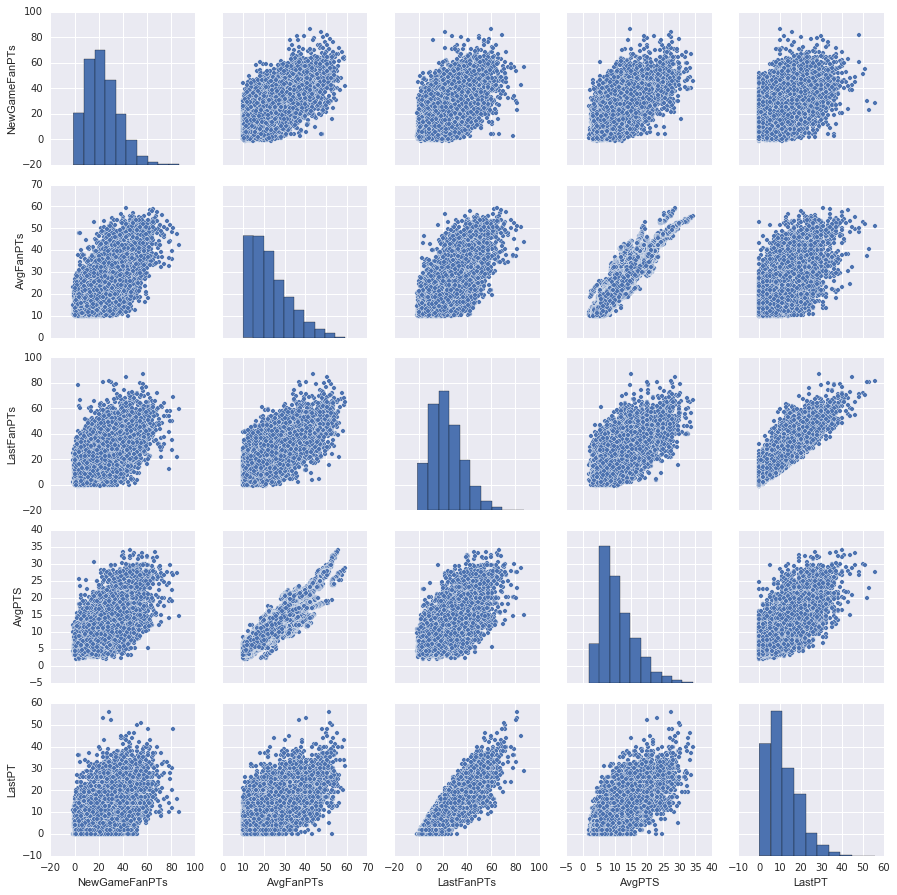

In [60]:
sns.pairplot(train[["NewGameFanPTs", "AvgFanPTs", "LastFanPTs","AvgPTS",'LastPT']])

From our observations, we can see that there exists nonlinear patterns, it would be difficult to fit a linear model for regression which requires a lot of variable transformation. We will use tree-based approach to do prediction.

## Baseline model - Random Forest Regression.

It can be understood as the sum of piecewise linear functions in contrast to the global linear and polynomial regression models. In other words, via the decision tree algorithm, we are subdividing the input space into smaller regions that become more manageable.

In [91]:
from sklearn.ensemble import RandomForestRegressor

In [92]:
forest = RandomForestRegressor(n_estimators = 1000, criterion ='mse',random_state = 1,n_jobs =-1) 

In [58]:
X_train = Train[predictors].values
y_train = Train[target].values
X_test = Test[predictors].values
y_test = Test[target].values

In [96]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [97]:
y_train_pred = forest.predict(X_train)

In [100]:
y_test_pred = forest.predict(X_test)

In [105]:
print('RMSE train: %.3f, test: %.3f'%(metrics.mean_squared_error(y_train, y_train_pred)**0.5,\
                                         metrics.mean_squared_error(y_test, y_test_pred)**0.5))

RMSE train: 3.573, test: 10.237


In [106]:
print('R^2 train: %.3f, test: %.3f' %(metrics.r2_score( y_train, y_train_pred),\
                                    metrics.r2_score( y_test, y_test_pred)))

R^2 train: 0.929, test: 0.493


####We have to deal with the significant overfitting issue!

##XGBoosting Implementation

In [7]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

Reasons:
- an efficient and scalable implementation of gradient boosting, 10 times faster than gradient boosting
- has more customizable parameters to control overfitting
- no need to do feature prepocessing and selection
- xgboost is more suited for the regression task than Adaboost


###General function

In [85]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=3, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        print "number of estomators : "+ str(cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
                
    return alg,dtrain_predictions

In [18]:
xgb1 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=500,
        max_depth=4,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [46]:
model1,train_predictions = modelfit(xgb1, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:24.0825206667+0.186514554473	cv-train-rmse:24.0752673333+0.0786852442428
[1]	cv-test-rmse:22.099788+0.202718813518	cv-train-rmse:22.0837163333+0.0708870396068
[2]	cv-test-rmse:20.3465816667+0.210410193146	cv-train-rmse:20.3230453333+0.0702417911756
[3]	cv-test-rmse:18.795311+0.221191964128	cv-train-rmse:18.7613786667+0.0625123068221
[4]	cv-test-rmse:17.4465806667+0.230611967267	cv-train-rmse:17.397027+0.0564086068078
[5]	cv-test-rmse:16.2726976667+0.239630260846	cv-train-rmse:16.213566+0.0491925526681
[6]	cv-test-rmse:15.2550703333+0.247054118914	cv-train-rmse:15.178606+0.0421230637379
[7]	cv-test-rmse:14.3750363333+0.25137428833	cv-train-rmse:14.282421+0.0349035362201
[8]	cv-test-rmse:13.6109233333+0.257457848337	cv-train-rmse:13.503053+0.0290223956282
[9]	cv-test-rmse:12.962524+0.253791679668	cv-train-rmse:12.8421406667+0.027565733249
[10]	cv-test-rmse:12.4086193333+0.242246473363	cv-train-rmse:12.272608+0.0304

number of estomators : 54


In [11]:
from ggplot import *

In [22]:
def plot_predictions(pred_label,data):     
    plot_obj = ggplot(aes(x='NewGameFanPTs', y=pred_label, colour='Rank'), data=data)+geom_point()+\
    ggtitle(pred_label+" Prediction Performance")+ geom_abline(intercept = 0, slope = 1)
    return(plot_obj)

In [49]:
with open('../Data/xgboost_model1.pickle', 'wb') as handle:
  pickle.dump((model1,train_predictions),handle)

In [19]:
import pickle
with open('../Data/train_set_02_29.pickle', 'rb') as handle:
  train_set = pickle.load(handle)

In [8]:
import pickle
with open('../Data/xgboost_model1.pickle', 'rb') as handle:
   model1,train_predictions = pickle.load(handle)

In [16]:
train['train_predict'] = train_predictions

In [17]:
train.shape

(11670, 106)

In [20]:
train['Rank'] = train_set['Rank'].values

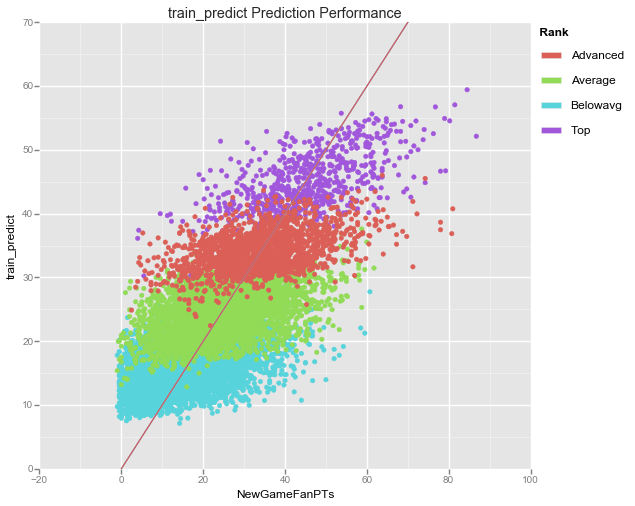

<ggplot: (285869465)>

In [23]:
plot_predictions('train_predict',train)

In [105]:
def get_performance(xgbmodel,train_data,test_data,predictors):
    train_predictions = xgbmodel.predict(train_data[predictors])
    print "\nModel Report"
    print "RMSE(Train) : %.4g" % metrics.mean_squared_error(train_data['NewGameFanPTs'], train_predictions)**0.5
    print "R^2 Score (Train): %f" % metrics.r2_score(train_data['NewGameFanPTs'], train_predictions)
    test_result = xgbmodel.predict(test_data[predictors])
    print "RMSE(Test) : %.4g" % metrics.mean_squared_error(test_data['NewGameFanPTs'], test_result)**0.5
    print 'R^2 Score (Test): %f' % metrics.r2_score(test_data['NewGameFanPTs'], test_result)

In [92]:
get_performance(model1,Train,Test,predictors)


Model Report
RMSE(Train) : 9.157
R^2 Score (Train): 0.532455
RMSE(Test) : 9.789
R^2 Score (Test): 0.536636


We had greatly reduced the overfitting but there's still some overfitting.

In [26]:
test['test_predict'] = test_result

In [27]:
with open('../Data/test_set_02_29.pickle', 'rb') as handle:
  test_set = pickle.load(handle)

In [28]:
test['Rank'] = test_set['Rank'].values

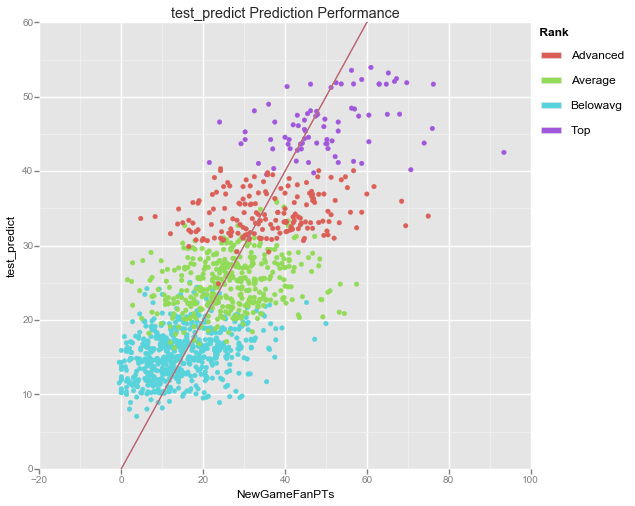

<ggplot: (287796689)>

In [29]:
plot_predictions('test_predict',test)

##Plot Feature Importance

In [50]:
def plot_importance(xgbmodel):
    feat_imp = pd.Series(xgbmodel.booster().get_fscore())
    feat_imp.sort(ascending=False)
    plt.figure(figsize=(10, 8))
    feat_imp[:30].plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')
    plt.show()

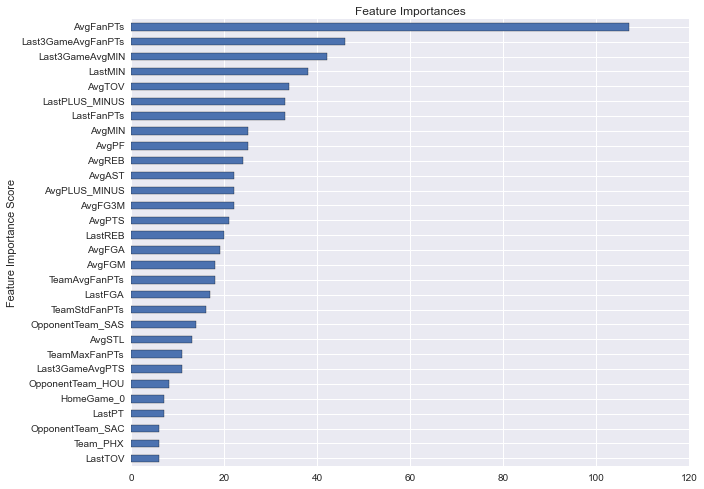

In [52]:
plot_importance(model1)

##Hyperparameters tuning

First, tune max_depth and min_child_weight

In [57]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [67]:
train,valid,y_train,y_valid = cross_validation.train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [143]:
def objective(space):
    clf = xgb.XGBRegressor(n_estimators = 54,
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight']
                            )

    eval_set  = [(train, y_train), (valid, y_valid)]

    clf.fit(train, y_train,
            eval_set=eval_set, eval_metric="rmse", 
            early_stopping_rounds=80,)

    pred = clf.predict(valid)
    rmse = metrics.mean_squared_error(y_valid, pred)**0.5
    print "RMSE:", rmse

    return{'loss':rmse, 'status': STATUS_OK }

In [144]:
space ={
        'max_depth': hp.quniform("x_max_depth", 3, 10, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1)
    }

In [145]:
trials = Trials()

In [146]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119452	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108751	validation_1-rmse:21.904499
[2]	validation_0-rmse:20.330938	validation_1-rmse:20.165867
[3]	validation_0-rmse:18.763113	validation_1-rmse:18.644665
[4]	validation_0-rmse:17.385504	validation_1-rmse:17.309132
[5]	validation_0-rmse:16.180544	validation_1-rmse:16.146364
[6]	validation_0-rmse:15.128831	validation_1-rmse:15.143385
[7]	validation_0-rmse:14.219110	validation_1-rmse:14.280494
[8]	validation_0-rmse:13.437551	validation_1-rmse:13.539398
[9]	validation_0-rmse:12.759530	validation_1-rmse:12.914319
[10]	validation_0-rmse:12.179878	validation_1-rmse:12.373984
[11]	validation_0-rmse:11.682115	validation_1-rmse:11.914609
[12]	validation_0-rmse:11.264492	validation_1-rmse:11.540384
[13]	validation_0-rmse:10.906609	validation_1-rmse:11.220879
[14]	validation_0-rmse:10.607087	validation_1-rmse:10.954255
[15]	validation_0-rmse:10.35

RMSE: 9.76218286957
RMSE:

[52]	validation_0-rmse:6.643716	validation_1-rmse:9.909328
[53]	validation_0-rmse:6.627889	validation_1-rmse:9.906797
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.89858706089
RMSE:

[53]	validation_0-rmse:9.322277	validation_1-rmse:9.769126
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125166	validation_1-rmse:23.869539
[1]	validation_0-rmse:22.121220	validation_1-rmse:21.901781
[2]	validation_0-rmse:20.350090	validation_1-rmse:20.160324
[3]	validation_0-rmse:18.790321	validation_1-rmse:18.639383
[4]	validation_0-rmse:17.423100	validation_1-rmse:17.306721
[5]	validation_0-rmse:16.228735	validation_1-rmse:16.148352
[6]	validation_0-rmse:15.190331	validation_1-rmse:15.143124
[7]	validation_0-rmse:14.290164	validation_1-rmse:14.277803
[8]	validation_0-rmse:13.515434	validation_1-rmse:13.535789
[9]	validation_0-rmse:12.850755	validation_1-rmse:12.903064
[10]	validation_0-rmse:12.284806	validation_1-rmse:12.372053
[11]	validation_0-rmse:11.804248	validation_1-rmse:11.926492
[12]	validation_0-rmse:11.395440	validation_1-rmse:11.551476
[13]	validation_0-rmse:11.050628	validation_1-rmse:11.236567
[14]	validation_0-rmse:10.7593

 9.7681076122
RMSE:

[52]	validation_0-rmse:9.070930	validation_1-rmse:9.759960
[53]	validation_0-rmse:9.062257	validation_1-rmse:9.757921
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.74794318121
RMSE:

[53]	validation_0-rmse:9.322277	validation_1-rmse:9.769126
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870937
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130415	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.7681076122
RMSE:

[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119453	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108780	validation_1-rmse:21.899841
[2]	validation_0-rmse:20.330469	validation_1-rmse:20.163578
[3]	validation_0-rmse:18.762249	validation_1-rmse:18.640898
[4]	validation_0-rmse:17.385029	validation_1-rmse:17.303635
[5]	validation_0-rmse:16.180042	validation_1-rmse:16.140490
[6]	validation_0-rmse:15.127542	validation_1-rmse:15.138482
[7]	validation_0-rmse:14.218494	validation_1-rmse:14.276127
[8]	validation_0-rmse:13.436828	validation_1-rmse:13.541518
[9]	validation_0-rmse:12.759549	validation_1-rmse:12.914835
[10]	validation_0-rmse:12.174829	validation_1-rmse:12.377197
[11]	validation_0-rmse:11.678432	validation_1-rmse:11.918400
[12]	validation_0-rmse:11.252916	validation_1-rmse:11.537907
[13]	validation_0-rmse:10.895549

 9.74369225425
RMSE:

[51]	validation_0-rmse:8.704488	validation_1-rmse:9.746226
[52]	validation_0-rmse:8.697091	validation_1-rmse:9.745442
[53]	validation_0-rmse:8.687620	validation_1-rmse:9.750560
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118504	validation_1-rmse:23.867538
[1]	validation_0-rmse:22.107159	validation_1-rmse:21.895554
[2]	validation_0-rmse:20.328880	validation_1-rmse:20.162146
[3]	validation_0-rmse:18.760860	validation_1-rmse:18.637259
[4]	validation_0-rmse:17.382998	validation_1-rmse:17.298481
[5]	validation_0-rmse:16.176622	validation_1-rmse:16.139572
[6]	validation_0-rmse:15.124510	validation_1-rmse:15.140079
[7]	validation_0-rmse:14.215490	validation_1-rmse:14.280216
[8]	validation_0-rmse:13.427588	validation_1-rmse:13.537717
[9]	validation_0-rmse:12.748179	validation_1-rmse:12.900035
[10]	validation_0-rmse:12.169394	validation_1-rmse:12.374255
[11]	validation_0-rmse:11.671995	validation_1-rmse:11.921474
[12]	validation_0-rmse:11.249841	v

 9.73933245035
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.090136	validation_1-rmse:23.898439
[1]	validation_0-rmse:22.044081	validation_1-rmse:21.941349
[2]	validation_0-rmse:20.213614	validation_1-rmse:20.232752
[3]	validation_0-rmse:18.586456	validation_1-rmse:18.719015
[4]	validation_0-rmse:17.133118	validation_1-rmse:17.406437
[5]	validation_0-rmse:15.845625	validation_1-rmse:16.261272
[6]	validation_0-rmse:14.704982	validation_1-rmse:15.267272
[7]	validation_0-rmse:13.695626	validation_1-rmse:14.413706
[8]	validation_0-rmse:12.786186	validation_1-rmse:13.671574
[9]	validation_0-rmse:11.976619	validation_1-rmse:13.061740
[10]	validation_0-rmse:11.263189	validation_1-rmse:12.531442
[11]	validation_0-rmse:10.654499	validation_1-rmse:12.101441
[12]	validation_0-rmse:10.095265	validation_1-rmse:11.716945
[13]	validation_0-rmse:9.615782	validation_1-rmse:11.391922
[14]	validation_0-rmse:9.183100	validation_1-rmse:11.142270
[15]	validation_0-rmse:8.78780

 9.73400319517
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868515
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305475
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153542
[6]	validation_0-rmse:15.064157	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923405
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	validation_1-rmse:11.551982
[13]	validation_0-rmse:10.707040	validation_1-rmse:11.244287
[14]	validation_0-rmse:10.386967	validation_1-rmse:10.976141
[15]	validation_0-rmse:10.11

 9.95385650204
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350679	validation_1-rmse:20.166935
[3]	validation_0-rmse:18.792606	validation_1-rmse:18.644255
[4]	validation_0-rmse:17.423862	validation_1-rmse:17.307022
[5]	validation_0-rmse:16.227867	validation_1-rmse:16.146116
[6]	validation_0-rmse:15.189373	validation_1-rmse:15.140632
[7]	validation_0-rmse:14.290694	validation_1-rmse:14.276140
[8]	validation_0-rmse:13.516099	validation_1-rmse:13.532732
[9]	validation_0-rmse:12.851384	validation_1-rmse:12.894465
[10]	validation_0-rmse:12.286320	validation_1-rmse:12.363894
[11]	validation_0-rmse:11.804134	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.396703	validation_1-rmse:11.543115
[13]	validation_0-rmse:11.050825	validation_1-rmse:11.230899
[14]	validation_0-rmse:10.758250	validation_1-rmse:10.964948
[15]	validation_0-rmse:10.51

 9.79008141593
RMSE:

[52]	validation_0-rmse:9.062033	validation_1-rmse:9.754549
[53]	validation_0-rmse:9.055693	validation_1-rmse:9.758328
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868517
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305475
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153543
[6]	validation_0-rmse:15.064156	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923405
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	validation_1-rmse:11.551982
[13]	validation_0-rmse:10.707040

 9.74367541987
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119452	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108751	validation_1-rmse:21.904499
[2]	validation_0-rmse:20.330938	validation_1-rmse:20.165867
[3]	validation_0-rmse:18.763113	validation_1-rmse:18.644665
[4]	validation_0-rmse:17.385504	validation_1-rmse:17.309132
[5]	validation_0-rmse:16.180544	validation_1-rmse:16.146364
[6]	validation_0-rmse:15.128831	validation_1-rmse:15.143385
[7]	validation_0-rmse:14.219110	validation_1-rmse:14.280494
[8]	validation_0-rmse:13.437551	validation_1-rmse:13.539398
[9]	validation_0-rmse:12.759530	validation_1-rmse:12.914319
[10]	validation_0-rmse:12.179878	validation_1-rmse:12.373985
[11]	validation_0-rmse:11.682115	validation_1-rmse:11.914609
[12]	validation_0-rmse:11.264492	validation_1-rmse:11.540384
[13]	validation_0-rmse:10.906609	validation_1-rmse:11.220879
[14]	validation_0-rmse:10.607087	validation_1-rmse:10.954255
[15]	validation_0-rmse:10.35

 9.79008141593
RMSE:

[51]	validation_0-rmse:8.671532	validation_1-rmse:9.775334
[52]	validation_0-rmse:8.665312	validation_1-rmse:9.783757
[53]	validation_0-rmse:8.658895	validation_1-rmse:9.782504
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125166	validation_1-rmse:23.869539
[1]	validation_0-rmse:22.121220	validation_1-rmse:21.901781
[2]	validation_0-rmse:20.350090	validation_1-rmse:20.160324
[3]	validation_0-rmse:18.790321	validation_1-rmse:18.639383
[4]	validation_0-rmse:17.423100	validation_1-rmse:17.306721
[5]	validation_0-rmse:16.228735	validation_1-rmse:16.148352
[6]	validation_0-rmse:15.190331	validation_1-rmse:15.143125
[7]	validation_0-rmse:14.290164	validation_1-rmse:14.277803
[8]	validation_0-rmse:13.515435	validation_1-rmse:13.535789
[9]	validation_0-rmse:12.850755	validation_1-rmse:12.903064
[10]	validation_0-rmse:12.284806	validation_1-rmse:12.372053
[11]	validation_0-rmse:11.804248	validation_1-rmse:11.926492
[12]	validation_0-rmse:11.395440	v

 9.76218286957
RMSE:

[53]	validation_0-rmse:9.062258	validation_1-rmse:9.757921
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125500	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424011	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228243	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541575
[9]	validation_0-rmse:12.851655	validation_1-rmse:12.899383
[10]	validation_0-rmse:12.286905	validation_1-rmse:12.369546
[11]	validation_0-rmse:11.804119	validation_1-rmse:11.917234
[12]	validation_0-rmse:11.396894	validation_1-rmse:11.545915
[13]	validation_0-rmse:11.050538	validation_1-rmse:11.230865
[14]	validation_0-rmse:10.7592

 9.74794318121
RMSE:

[50]	validation_0-rmse:9.079077	validation_1-rmse:9.750792
[51]	validation_0-rmse:9.067880	validation_1-rmse:9.752131
[52]	validation_0-rmse:9.064534	validation_1-rmse:9.751561
[53]	validation_0-rmse:9.057833	validation_1-rmse:9.745494
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.102386	validation_1-rmse:23.874811
[1]	validation_0-rmse:22.073999	validation_1-rmse:21.916313
[2]	validation_0-rmse:20.270346	validation_1-rmse:20.183939
[3]	validation_0-rmse:18.672546	validation_1-rmse:18.666513
[4]	validation_0-rmse:17.262098	validation_1-rmse:17.333586
[5]	validation_0-rmse:16.015272	validation_1-rmse:16.174528
[6]	validation_0-rmse:14.913672	validation_1-rmse:15.188372
[7]	validation_0-rmse:13.945785	validation_1-rmse:14.327907
[8]	validation_0-rmse:13.097056	validation_1-rmse:13.582752
[9]	validation_0-rmse:12.348711	validation_1-rmse:12.965114
[10]	validation_0-rmse:11.693074	validation_1-rmse:12.440165
[11]	validation_0-rmse:11.126057	val

 9.73161770846
RMSE:

[53]	validation_0-rmse:6.974106	validation_1-rmse:9.881714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.101097	validation_1-rmse:23.880947
[1]	validation_0-rmse:22.070105	validation_1-rmse:21.925936
[2]	validation_0-rmse:20.263256	validation_1-rmse:20.195496
[3]	validation_0-rmse:18.658989	validation_1-rmse:18.686071
[4]	validation_0-rmse:17.240969	validation_1-rmse:17.364414
[5]	validation_0-rmse:15.991707	validation_1-rmse:16.216274
[6]	validation_0-rmse:14.877168	validation_1-rmse:15.215716
[7]	validation_0-rmse:13.909206	validation_1-rmse:14.345072
[8]	validation_0-rmse:13.061710	validation_1-rmse:13.608484
[9]	validation_0-rmse:12.312884	validation_1-rmse:12.992924
[10]	validation_0-rmse:11.656476	validation_1-rmse:12.464072
[11]	validation_0-rmse:11.083660	validation_1-rmse:12.016108
[12]	validation_0-rmse:10.591274	validation_1-rmse:11.636943
[13]	validation_0-rmse:10.156296	validation_1-rmse:11.327071
[14]	validation_0-rmse:9.78198

 9.85888292379
RMSE:

[52]	validation_0-rmse:6.728412	validation_1-rmse:9.966475
[53]	validation_0-rmse:6.707061	validation_1-rmse:9.965500
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.903034
[2]	validation_0-rmse:20.350719	validation_1-rmse:20.166039
[3]	validation_0-rmse:18.792677	validation_1-rmse:18.644115
[4]	validation_0-rmse:17.423965	validation_1-rmse:17.311291
[5]	validation_0-rmse:16.228218	validation_1-rmse:16.147360
[6]	validation_0-rmse:15.189999	validation_1-rmse:15.143559
[7]	validation_0-rmse:14.291509	validation_1-rmse:14.282466
[8]	validation_0-rmse:13.517036	validation_1-rmse:13.538474
[9]	validation_0-rmse:12.852231	validation_1-rmse:12.903547
[10]	validation_0-rmse:12.287374	validation_1-rmse:12.374782
[11]	validation_0-rmse:11.804105	validation_1-rmse:11.926453
[12]	validation_0-rmse:11.395267	validation_1-rmse:11.547813
[13]	validation_0-rmse:11.050831

 9.94234177533
RMSE:

[53]	validation_0-rmse:9.066878	validation_1-rmse:9.751847
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108883	validation_1-rmse:23.873844
[1]	validation_0-rmse:22.085955	validation_1-rmse:21.912031
[2]	validation_0-rmse:20.292929	validation_1-rmse:20.175575
[3]	validation_0-rmse:18.706121	validation_1-rmse:18.651987
[4]	validation_0-rmse:17.303354	validation_1-rmse:17.321564
[5]	validation_0-rmse:16.069475	validation_1-rmse:16.165676
[6]	validation_0-rmse:14.991466	validation_1-rmse:15.162901
[7]	validation_0-rmse:14.045796	validation_1-rmse:14.308088
[8]	validation_0-rmse:13.217408	validation_1-rmse:13.576609
[9]	validation_0-rmse:12.497196	validation_1-rmse:12.945567
[10]	validation_0-rmse:11.871501	validation_1-rmse:12.412323
[11]	validation_0-rmse:11.341836	validation_1-rmse:11.960416
[12]	validation_0-rmse:10.881545	validation_1-rmse:11.589634
[13]	validation_0-rmse:10.486340	validation_1-rmse:11.277323
[14]	validation_0-rmse:10.1522

 9.73804059784
RMSE:

[52]	validation_0-rmse:7.650843	validation_1-rmse:9.875269
[53]	validation_0-rmse:7.647336	validation_1-rmse:9.874277
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108883	validation_1-rmse:23.873844
[1]	validation_0-rmse:22.085955	validation_1-rmse:21.912031
[2]	validation_0-rmse:20.292929	validation_1-rmse:20.175575
[3]	validation_0-rmse:18.706121	validation_1-rmse:18.651989
[4]	validation_0-rmse:17.303354	validation_1-rmse:17.321564
[5]	validation_0-rmse:16.069475	validation_1-rmse:16.165676
[6]	validation_0-rmse:14.991466	validation_1-rmse:15.162901
[7]	validation_0-rmse:14.045796	validation_1-rmse:14.308088
[8]	validation_0-rmse:13.217409	validation_1-rmse:13.576609
[9]	validation_0-rmse:12.497196	validation_1-rmse:12.945567
[10]	validation_0-rmse:11.871501	validation_1-rmse:12.412323
[11]	validation_0-rmse:11.341836	validation_1-rmse:11.960416
[12]	validation_0-rmse:10.881545	validation_1-rmse:11.589634
[13]	validation_0-rmse:10.486340

 9.85063765067
RMSE:

[51]	validation_0-rmse:7.659543	validation_1-rmse:9.871388
[52]	validation_0-rmse:7.650843	validation_1-rmse:9.875269
[53]	validation_0-rmse:7.647336	validation_1-rmse:9.874277
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114246	validation_1-rmse:23.871210
[1]	validation_0-rmse:22.097651	validation_1-rmse:21.910076
[2]	validation_0-rmse:20.310755	validation_1-rmse:20.170429
[3]	validation_0-rmse:18.730776	validation_1-rmse:18.647655
[4]	validation_0-rmse:17.341291	validation_1-rmse:17.313478
[5]	validation_0-rmse:16.121786	validation_1-rmse:16.156647
[6]	validation_0-rmse:15.056556	validation_1-rmse:15.156137
[7]	validation_0-rmse:14.128031	validation_1-rmse:14.292001
[8]	validation_0-rmse:13.322772	validation_1-rmse:13.551939
[9]	validation_0-rmse:12.626955	validation_1-rmse:12.921128
[10]	validation_0-rmse:12.023179	validation_1-rmse:12.384395
[11]	validation_0-rmse:11.508811	validation_1-rmse:11.938708
[12]	validation_0-rmse:11.065792	v

 9.85063765067
RMSE:

[52]	validation_0-rmse:8.121552	validation_1-rmse:9.783685
[53]	validation_0-rmse:8.102359	validation_1-rmse:9.787512
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.77837201453
RMSE:

[50]	validation_0-rmse:9.330546	validation_1-rmse:9.766217
[51]	validation_0-rmse:9.327536	validation_1-rmse:9.765511
[52]	validation_0-rmse:9.323603	validation_1-rmse:9.766790
[53]	validation_0-rmse:9.319542	validation_1-rmse:9.765909
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125156	validation_1-rmse:23.868093
[1]	validation_0-rmse:22.121227	validation_1-rmse:21.900354
[2]	validation_0-rmse:20.349997	validation_1-rmse:20.159048
[3]	validation_0-rmse:18.790304	validation_1-rmse:18.638243
[4]	validation_0-rmse:17.423092	validation_1-rmse:17.305687
[5]	validation_0-rmse:16.228697	validation_1-rmse:16.143099
[6]	validation_0-rmse:15.190405	validation_1-rmse:15.139666
[7]	validation_0-rmse:14.290030	validation_1-rmse:14.275728
[8]	validation_0-rmse:13.516379	validation_1-rmse:13.545489
[9]	validation_0-rmse:12.851646	validation_1-rmse:12.913272
[10]	validation_0-rmse:12.286069	validation_1-rmse:12.382055
[11]	validation_0-rmse:11.804087	val

 9.76446130605
RMSE:

[53]	validation_0-rmse:9.048592	validation_1-rmse:9.763805
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119829	validation_1-rmse:23.873726
[1]	validation_0-rmse:22.109529	validation_1-rmse:21.903923
[2]	validation_0-rmse:20.332310	validation_1-rmse:20.161713
[3]	validation_0-rmse:18.764997	validation_1-rmse:18.640116
[4]	validation_0-rmse:17.388548	validation_1-rmse:17.301804
[5]	validation_0-rmse:16.183619	validation_1-rmse:16.139210
[6]	validation_0-rmse:15.130906	validation_1-rmse:15.139318
[7]	validation_0-rmse:14.223783	validation_1-rmse:14.279951
[8]	validation_0-rmse:13.440709	validation_1-rmse:13.532317
[9]	validation_0-rmse:12.761030	validation_1-rmse:12.906916
[10]	validation_0-rmse:12.177477	validation_1-rmse:12.367263
[11]	validation_0-rmse:11.680354	validation_1-rmse:11.911634
[12]	validation_0-rmse:11.261236	validation_1-rmse:11.536205
[13]	validation_0-rmse:10.905053	validation_1-rmse:11.217029
[14]	validation_0-rmse:10.6041

 9.74617363243
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.087967	validation_1-rmse:23.896963
[1]	validation_0-rmse:22.038099	validation_1-rmse:21.950779
[2]	validation_0-rmse:20.208008	validation_1-rmse:20.237278
[3]	validation_0-rmse:18.577332	validation_1-rmse:18.743176
[4]	validation_0-rmse:17.124771	validation_1-rmse:17.418766
[5]	validation_0-rmse:15.830010	validation_1-rmse:16.282179
[6]	validation_0-rmse:14.676838	validation_1-rmse:15.296359
[7]	validation_0-rmse:13.655007	validation_1-rmse:14.452283
[8]	validation_0-rmse:12.750190	validation_1-rmse:13.727709
[9]	validation_0-rmse:11.932377	validation_1-rmse:13.100330
[10]	validation_0-rmse:11.204546	validation_1-rmse:12.563751
[11]	validation_0-rmse:10.564704	validation_1-rmse:12.118175
[12]	validation_0-rmse:9.998478	validation_1-rmse:11.749059
[13]	validation_0-rmse:9.488838	validation_1-rmse:11.452092
[14]	validation_0-rmse:9.057522	validation_1-rmse:11.208710
[15]	validation_0-rmse:8.660533

 9.75022055436
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.867561	validation_1-rmse:10.983952
[15]	validation_0-rmse:10.63

 10.0346199439
RMSE:

[51]	validation_0-rmse:9.325641	validation_1-rmse:9.772595
[52]	validation_0-rmse:9.317353	validation_1-rmse:9.768789
[53]	validation_0-rmse:9.314795	validation_1-rmse:9.766800
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.113857	validation_1-rmse:23.872263
[1]	validation_0-rmse:22.096809	validation_1-rmse:21.907171
[2]	validation_0-rmse:20.309233	validation_1-rmse:20.166334
[3]	validation_0-rmse:18.729822	validation_1-rmse:18.641249
[4]	validation_0-rmse:17.341362	validation_1-rmse:17.306488
[5]	validation_0-rmse:16.121990	validation_1-rmse:16.149832
[6]	validation_0-rmse:15.055247	validation_1-rmse:15.148977
[7]	validation_0-rmse:14.126789	validation_1-rmse:14.287689
[8]	validation_0-rmse:13.323073	validation_1-rmse:13.549180
[9]	validation_0-rmse:12.623780	validation_1-rmse:12.925584
[10]	validation_0-rmse:12.019390	validation_1-rmse:12.388813
[11]	validation_0-rmse:11.504107	validation_1-rmse:11.930157
[12]	validation_0-rmse:11.063813	v

 9.76663150095
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.109283	validation_1-rmse:23.875538
[1]	validation_0-rmse:22.087147	validation_1-rmse:21.910461
[2]	validation_0-rmse:20.294876	validation_1-rmse:20.174683
[3]	validation_0-rmse:18.708946	validation_1-rmse:18.653904
[4]	validation_0-rmse:17.307568	validation_1-rmse:17.320410
[5]	validation_0-rmse:16.073059	validation_1-rmse:16.175053
[6]	validation_0-rmse:14.992219	validation_1-rmse:15.167633
[7]	validation_0-rmse:14.048729	validation_1-rmse:14.303183
[8]	validation_0-rmse:13.219271	validation_1-rmse:13.575853
[9]	validation_0-rmse:12.500971	validation_1-rmse:12.951536
[10]	validation_0-rmse:11.888075	validation_1-rmse:12.415146
[11]	validation_0-rmse:11.358550	validation_1-rmse:11.976431
[12]	validation_0-rmse:10.899543	validation_1-rmse:11.603548
[13]	validation_0-rmse:10.504320	validation_1-rmse:11.289664
[14]	validation_0-rmse:10.159955	validation_1-rmse:11.032264
[15]	validation_0-rmse:9.860

 9.79247644046
RMSE:

[52]	validation_0-rmse:7.650815	validation_1-rmse:9.863156
[53]	validation_0-rmse:7.640891	validation_1-rmse:9.862238
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166325
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645823
[4]	validation_0-rmse:17.383093	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125703	validation_1-rmse:15.147164
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541144
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373088
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530

 9.84786765434
RMSE:

[51]	validation_0-rmse:8.665455	validation_1-rmse:9.765227
[52]	validation_0-rmse:8.655813	validation_1-rmse:9.762918
[53]	validation_0-rmse:8.642134	validation_1-rmse:9.764597
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870995
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902584
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899368
[10]	validation_0-rmse:12.285314	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925163
[12]	validation_0-rmse:11.393589	v

 9.75188769907
RMSE:

[52]	validation_0-rmse:9.056343	validation_1-rmse:9.760841
[53]	validation_0-rmse:9.048349	validation_1-rmse:9.758019
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.094837	validation_1-rmse:23.890549
[1]	validation_0-rmse:22.055319	validation_1-rmse:21.935938
[2]	validation_0-rmse:20.239483	validation_1-rmse:20.196146
[3]	validation_0-rmse:18.618792	validation_1-rmse:18.682037
[4]	validation_0-rmse:17.182804	validation_1-rmse:17.368244
[5]	validation_0-rmse:15.913301	validation_1-rmse:16.216597
[6]	validation_0-rmse:14.784159	validation_1-rmse:15.229875
[7]	validation_0-rmse:13.791485	validation_1-rmse:14.373952
[8]	validation_0-rmse:12.907171	validation_1-rmse:13.634924
[9]	validation_0-rmse:12.124948	validation_1-rmse:13.006335
[10]	validation_0-rmse:11.436294	validation_1-rmse:12.481003
[11]	validation_0-rmse:10.826564	validation_1-rmse:12.030574
[12]	validation_0-rmse:10.296558	validation_1-rmse:11.661356
[13]	validation_0-rmse:9.826165	

 9.74949531663
RMSE:

[53]	validation_0-rmse:5.905210	validation_1-rmse:9.982907
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.8675

 9.96886414623
RMSE:

[51]	validation_0-rmse:9.325641	validation_1-rmse:9.772594
[52]	validation_0-rmse:9.317353	validation_1-rmse:9.768789
[53]	validation_0-rmse:9.314795	validation_1-rmse:9.766800
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118504	validation_1-rmse:23.867538
[1]	validation_0-rmse:22.107159	validation_1-rmse:21.895554
[2]	validation_0-rmse:20.328880	validation_1-rmse:20.162146
[3]	validation_0-rmse:18.760860	validation_1-rmse:18.637259
[4]	validation_0-rmse:17.382998	validation_1-rmse:17.298481
[5]	validation_0-rmse:16.176622	validation_1-rmse:16.139572
[6]	validation_0-rmse:15.124510	validation_1-rmse:15.140079
[7]	validation_0-rmse:14.215490	validation_1-rmse:14.280215
[8]	validation_0-rmse:13.427588	validation_1-rmse:13.537717
[9]	validation_0-rmse:12.748179	validation_1-rmse:12.900035
[10]	validation_0-rmse:12.169394	validation_1-rmse:12.374255
[11]	validation_0-rmse:11.671995	validation_1-rmse:11.921474
[12]	validation_0-rmse:11.249841	v

 9.76663150095
RMSE:

[53]	validation_0-rmse:8.627577	validation_1-rmse:9.736968
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350700	validation_1-rmse:20.166082
[3]	validation_0-rmse:18.792671	validation_1-rmse:18.644098
[4]	validation_0-rmse:17.423922	validation_1-rmse:17.311901
[5]	validation_0-rmse:16.227905	validation_1-rmse:16.149160
[6]	validation_0-rmse:15.189571	validation_1-rmse:15.144203
[7]	validation_0-rmse:14.290784	validation_1-rmse:14.279242
[8]	validation_0-rmse:13.516116	validation_1-rmse:13.538309
[9]	validation_0-rmse:12.851455	validation_1-rmse:12.896580
[10]	validation_0-rmse:12.286273	validation_1-rmse:12.366405
[11]	validation_0-rmse:11.805215	validation_1-rmse:11.922660
[12]	validation_0-rmse:11.395301	validation_1-rmse:11.541790
[13]	validation_0-rmse:11.049396	validation_1-rmse:11.227733
[14]	validation_0-rmse:10.7577

 9.73400319517
RMSE:

[51]	validation_0-rmse:9.068666	validation_1-rmse:9.753603
[52]	validation_0-rmse:9.061409	validation_1-rmse:9.752932
[53]	validation_0-rmse:9.053139	validation_1-rmse:9.753023
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	v

 9.74115194877
RMSE:

[52]	validation_0-rmse:9.324184	validation_1-rmse:9.774826
[53]	validation_0-rmse:9.320870	validation_1-rmse:9.774102
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114719	validation_1-rmse:23.871033
[1]	validation_0-rmse:22.097746	validation_1-rmse:21.906008
[2]	validation_0-rmse:20.311754	validation_1-rmse:20.167156
[3]	validation_0-rmse:18.733755	validation_1-rmse:18.636290
[4]	validation_0-rmse:17.346663	validation_1-rmse:17.311470
[5]	validation_0-rmse:16.126913	validation_1-rmse:16.154016
[6]	validation_0-rmse:15.062671	validation_1-rmse:15.157742
[7]	validation_0-rmse:14.135468	validation_1-rmse:14.298212
[8]	validation_0-rmse:13.331877	validation_1-rmse:13.557668
[9]	validation_0-rmse:12.638297	validation_1-rmse:12.935003
[10]	validation_0-rmse:12.035796	validation_1-rmse:12.397744
[11]	validation_0-rmse:11.523155	validation_1-rmse:11.942334
[12]	validation_0-rmse:11.078750	validation_1-rmse:11.557848
[13]	validation_0-rmse:10.701609

 9.77183817303
RMSE:

[52]	validation_0-rmse:8.123719	validation_1-rmse:9.777025
[53]	validation_0-rmse:8.117562	validation_1-rmse:9.778175
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136039
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812

 9.7661328604
RMSE:

[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.74369225425
RMSE:

[50]	validation_0-rmse:9.335167	validation_1-rmse:9.777050
[51]	validation_0-rmse:9.331389	validation_1-rmse:9.778243
[52]	validation_0-rmse:9.328485	validation_1-rmse:9.777288
[53]	validation_0-rmse:9.323493	validation_1-rmse:9.777643
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119453	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108780	validation_1-rmse:21.899841
[2]	validation_0-rmse:20.330469	validation_1-rmse:20.163580
[3]	validation_0-rmse:18.762249	validation_1-rmse:18.640898
[4]	validation_0-rmse:17.385029	validation_1-rmse:17.303635
[5]	validation_0-rmse:16.180042	validation_1-rmse:16.140490
[6]	validation_0-rmse:15.127542	validation_1-rmse:15.138483
[7]	validation_0-rmse:14.218494	validation_1-rmse:14.276128
[8]	validation_0-rmse:13.436828	validation_1-rmse:13.541518
[9]	validation_0-rmse:12.759549	validation_1-rmse:12.914834
[10]	validation_0-rmse:12.174828	validation_1-rmse:12.377197
[11]	validation_0-rmse:11.678432	val

 9.77739733995
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.095596	validation_1-rmse:23.887850
[1]	validation_0-rmse:22.057529	validation_1-rmse:21.927790
[2]	validation_0-rmse:20.242239	validation_1-rmse:20.202366
[3]	validation_0-rmse:18.631035	validation_1-rmse:18.695095
[4]	validation_0-rmse:17.194372	validation_1-rmse:17.377607
[5]	validation_0-rmse:15.927068	validation_1-rmse:16.241430
[6]	validation_0-rmse:14.801593	validation_1-rmse:15.249487
[7]	validation_0-rmse:13.815429	validation_1-rmse:14.388331
[8]	validation_0-rmse:12.940395	validation_1-rmse:13.652433
[9]	validation_0-rmse:12.169173	validation_1-rmse:13.030581
[10]	validation_0-rmse:11.488798	validation_1-rmse:12.499797
[11]	validation_0-rmse:10.887458	validation_1-rmse:12.059912
[12]	validation_0-rmse:10.363106	validation_1-rmse:11.670189
[13]	validation_0-rmse:9.906373	validation_1-rmse:11.371608
[14]	validation_0-rmse:9.503635	validation_1-rmse:11.114083
[15]	validation_0-rmse:9.15772

 9.73933245035
RMSE:

[52]	validation_0-rmse:6.208552	validation_1-rmse:10.030241
[53]	validation_0-rmse:6.159427	validation_1-rmse:10.038890
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870993
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902584
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899367
[10]	validation_0-rmse:12.285315	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925164
[12]	validation_0-rmse:11.393589	validation_1-rmse:11.548536
[13]	validation_0-rmse:11.0475

 10.020470808
RMSE:

[53]	validation_0-rmse:9.048349	validation_1-rmse:9.758019
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166327
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645824
[4]	validation_0-rmse:17.383091	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177094	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125703	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541143
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373089
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530	validation_1-rmse:11.231712
[14]	validation_0-rmse:10.5834

 9.74949531663
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.107718	validation_1-rmse:23.874851
[1]	validation_0-rmse:22.083378	validation_1-rmse:21.908531
[2]	validation_0-rmse:20.287624	validation_1-rmse:20.171640
[3]	validation_0-rmse:18.699177	validation_1-rmse:18.650059
[4]	validation_0-rmse:17.294569	validation_1-rmse:17.318911
[5]	validation_0-rmse:16.058926	validation_1-rmse:16.161997
[6]	validation_0-rmse:14.973225	validation_1-rmse:15.158975
[7]	validation_0-rmse:14.021212	validation_1-rmse:14.307266
[8]	validation_0-rmse:13.194164	validation_1-rmse:13.569924
[9]	validation_0-rmse:12.472175	validation_1-rmse:12.932990
[10]	validation_0-rmse:11.849347	validation_1-rmse:12.402218
[11]	validation_0-rmse:11.312370	validation_1-rmse:11.955161
[12]	validation_0-rmse:10.850128	validation_1-rmse:11.583996
[13]	validation_0-rmse:10.446091	validation_1-rmse:11.265486
[14]	validation_0-rmse:10.086567	validation_1-rmse:11.004178
[15]	validation_0-rmse:9.790

 9.75188769907
RMSE:

[52]	validation_0-rmse:7.499014	validation_1-rmse:9.841902
[53]	validation_0-rmse:7.489391	validation_1-rmse:9.840468
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115158	validation_1-rmse:23.868734
[1]	validation_0-rmse:22.099049	validation_1-rmse:21.906725
[2]	validation_0-rmse:20.314474	validation_1-rmse:20.166620
[3]	validation_0-rmse:18.738155	validation_1-rmse:18.639286
[4]	validation_0-rmse:17.350060	validation_1-rmse:17.309387
[5]	validation_0-rmse:16.134439	validation_1-rmse:16.145292
[6]	validation_0-rmse:15.070882	validation_1-rmse:15.141561
[7]	validation_0-rmse:14.141226	validation_1-rmse:14.289040
[8]	validation_0-rmse:13.341045	validation_1-rmse:13.563207
[9]	validation_0-rmse:12.646539	validation_1-rmse:12.927448
[10]	validation_0-rmse:12.046831	validation_1-rmse:12.387367
[11]	validation_0-rmse:11.539705	validation_1-rmse:11.934971
[12]	validation_0-rmse:11.100721	validation_1-rmse:11.554044
[13]	validation_0-rmse:10.723804

 9.82675747553
RMSE:

[53]	validation_0-rmse:8.233302	validation_1-rmse:9.809882
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125166	validation_1-rmse:23.869539
[1]	validation_0-rmse:22.121220	validation_1-rmse:21.901781
[2]	validation_0-rmse:20.350090	validation_1-rmse:20.160324
[3]	validation_0-rmse:18.790321	validation_1-rmse:18.639383
[4]	validation_0-rmse:17.423100	validation_1-rmse:17.306721
[5]	validation_0-rmse:16.228735	validation_1-rmse:16.148352
[6]	validation_0-rmse:15.190331	validation_1-rmse:15.143124
[7]	validation_0-rmse:14.290165	validation_1-rmse:14.277803
[8]	validation_0-rmse:13.515434	validation_1-rmse:13.535789
[9]	validation_0-rmse:12.850755	validation_1-rmse:12.903064
[10]	validation_0-rmse:12.284806	validation_1-rmse:12.372053
[11]	validation_0-rmse:11.804248	validation_1-rmse:11.926492
[12]	validation_0-rmse:11.395440	validation_1-rmse:11.551477
[13]	validation_0-rmse:11.050628	validation_1-rmse:11.236567
[14]	validation_0-rmse:10.7593

 9.79350553913
RMSE:

[53]	validation_0-rmse:9.062258	validation_1-rmse:9.757921
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114719	validation_1-rmse:23.871033
[1]	validation_0-rmse:22.097746	validation_1-rmse:21.906008
[2]	validation_0-rmse:20.311754	validation_1-rmse:20.167156
[3]	validation_0-rmse:18.733755	validation_1-rmse:18.636290
[4]	validation_0-rmse:17.346663	validation_1-rmse:17.311470
[5]	validation_0-rmse:16.126913	validation_1-rmse:16.154016
[6]	validation_0-rmse:15.062671	validation_1-rmse:15.157742
[7]	validation_0-rmse:14.135468	validation_1-rmse:14.298212
[8]	validation_0-rmse:13.331877	validation_1-rmse:13.557669
[9]	validation_0-rmse:12.638297	validation_1-rmse:12.935003
[10]	validation_0-rmse:12.035796	validation_1-rmse:12.397744
[11]	validation_0-rmse:11.523155	validation_1-rmse:11.942334
[12]	validation_0-rmse:11.078750	validation_1-rmse:11.557848
[13]	validation_0-rmse:10.701609	validation_1-rmse:11.240788
[14]	validation_0-rmse:10.3772

 9.74794318121
RMSE:

[52]	validation_0-rmse:8.123719	validation_1-rmse:9.777025
[53]	validation_0-rmse:8.117562	validation_1-rmse:9.778174
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.7661328604
RMSE:

[51]	validation_0-rmse:9.330491	validation_1-rmse:9.770077
[52]	validation_0-rmse:9.324096	validation_1-rmse:9.768953
[53]	validation_0-rmse:9.322169	validation_1-rmse:9.768714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.101627	validation_1-rmse:23.881172
[1]	validation_0-rmse:22.072702	validation_1-rmse:21.924627
[2]	validation_0-rmse:20.267990	validation_1-rmse:20.196732
[3]	validation_0-rmse:18.665400	validation_1-rmse:18.672689
[4]	validation_0-rmse:17.252281	validation_1-rmse:17.341370
[5]	validation_0-rmse:16.003510	validation_1-rmse:16.192663
[6]	validation_0-rmse:14.897799	validation_1-rmse:15.196776
[7]	validation_0-rmse:13.933459	validation_1-rmse:14.339684
[8]	validation_0-rmse:13.083369	validation_1-rmse:13.608436
[9]	validation_0-rmse:12.345995	validation_1-rmse:12.980793
[10]	validation_0-rmse:11.694060	validation_1-rmse:12.459973
[11]	validation_0-rmse:11.123218	validation_1-rmse:12.020255
[12]	validation_0-rmse:10.622528	v

 9.76854295839
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119751	validation_1-rmse:23.871378
[1]	validation_0-rmse:22.109310	validation_1-rmse:21.902161
[2]	validation_0-rmse:20.331648	validation_1-rmse:20.162054
[3]	validation_0-rmse:18.764130	validation_1-rmse:18.640839
[4]	validation_0-rmse:17.387440	validation_1-rmse:17.301134
[5]	validation_0-rmse:16.182631	validation_1-rmse:16.137861
[6]	validation_0-rmse:15.131346	validation_1-rmse:15.134843
[7]	validation_0-rmse:14.221881	validation_1-rmse:14.271791
[8]	validation_0-rmse:13.441121	validation_1-rmse:13.530232
[9]	validation_0-rmse:12.763927	validation_1-rmse:12.899610
[10]	validation_0-rmse:12.180677	validation_1-rmse:12.364655
[11]	validation_0-rmse:11.684121	validation_1-rmse:11.911885
[12]	validation_0-rmse:11.259100	validation_1-rmse:11.532269
[13]	validation_0-rmse:10.902230	validation_1-rmse:11.215220
[14]	validation_0-rmse:10.599273	validation_1-rmse:10.950581
[15]	validation_0-rmse:10.34

 9.95063661971
RMSE:

[52]	validation_0-rmse:8.682778	validation_1-rmse:9.730370
[53]	validation_0-rmse:8.673928	validation_1-rmse:9.730251
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121809	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792759	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424009	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541575
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901683
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549856
[13]	validation_0-rmse:11.051099

 9.72011229099
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.903034
[2]	validation_0-rmse:20.350719	validation_1-rmse:20.166039
[3]	validation_0-rmse:18.792677	validation_1-rmse:18.644115
[4]	validation_0-rmse:17.423965	validation_1-rmse:17.311291
[5]	validation_0-rmse:16.228218	validation_1-rmse:16.147360
[6]	validation_0-rmse:15.189999	validation_1-rmse:15.143559
[7]	validation_0-rmse:14.291509	validation_1-rmse:14.282466
[8]	validation_0-rmse:13.517035	validation_1-rmse:13.538474
[9]	validation_0-rmse:12.852232	validation_1-rmse:12.903547
[10]	validation_0-rmse:12.287374	validation_1-rmse:12.374782
[11]	validation_0-rmse:11.804105	validation_1-rmse:11.926453
[12]	validation_0-rmse:11.395267	validation_1-rmse:11.547813
[13]	validation_0-rmse:11.050831	validation_1-rmse:11.233738
[14]	validation_0-rmse:10.757255	validation_1-rmse:10.966722
[15]	validation_0-rmse:10.51

 9.76500228725
RMSE:

[51]	validation_0-rmse:9.079919	validation_1-rmse:9.752168
[52]	validation_0-rmse:9.074804	validation_1-rmse:9.756012
[53]	validation_0-rmse:9.066878	validation_1-rmse:9.751847
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	v

 9.73804059784
RMSE:

[50]	validation_0-rmse:9.334394	validation_1-rmse:9.768347
[51]	validation_0-rmse:9.330491	validation_1-rmse:9.770077
[52]	validation_0-rmse:9.324097	validation_1-rmse:9.768953
[53]	validation_0-rmse:9.322169	validation_1-rmse:9.768714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870937
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130415	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681744	val

 9.76854295839
RMSE:

[51]	validation_0-rmse:8.698054	validation_1-rmse:9.760546
[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115250	validation_1-rmse:23.870365
[1]	validation_0-rmse:22.099380	validation_1-rmse:21.905857
[2]	validation_0-rmse:20.315393	validation_1-rmse:20.164949
[3]	validation_0-rmse:18.738968	validation_1-rmse:18.640654
[4]	validation_0-rmse:17.352116	validation_1-rmse:17.311104
[5]	validation_0-rmse:16.136631	validation_1-rmse:16.145720
[6]	validation_0-rmse:15.072879	validation_1-rmse:15.149531
[7]	validation_0-rmse:14.143773	validation_1-rmse:14.294322
[8]	validation_0-rmse:13.343202	validation_1-rmse:13.563546
[9]	validation_0-rmse:12.650122	validation_1-rmse:12.938823
[10]	validation_0-rmse:12.051878	validation_1-rmse:12.400793
[11]	validation_0-rmse:11.540086	validation_1-rmse:11.954816
[12]	validation_0-rmse:11.100945	v

 9.74369225425
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108076	validation_1-rmse:23.876911
[1]	validation_0-rmse:22.084330	validation_1-rmse:21.914036
[2]	validation_0-rmse:20.290602	validation_1-rmse:20.179276
[3]	validation_0-rmse:18.704983	validation_1-rmse:18.655910
[4]	validation_0-rmse:17.303205	validation_1-rmse:17.324123
[5]	validation_0-rmse:16.064722	validation_1-rmse:16.168077
[6]	validation_0-rmse:14.983688	validation_1-rmse:15.175918
[7]	validation_0-rmse:14.036115	validation_1-rmse:14.317983
[8]	validation_0-rmse:13.213545	validation_1-rmse:13.573871
[9]	validation_0-rmse:12.491740	validation_1-rmse:12.947763
[10]	validation_0-rmse:11.867005	validation_1-rmse:12.411826
[11]	validation_0-rmse:11.337382	validation_1-rmse:11.969263
[12]	validation_0-rmse:10.869182	validation_1-rmse:11.585228
[13]	validation_0-rmse:10.479053	validation_1-rmse:11.274881
[14]	validation_0-rmse:10.133140	validation_1-rmse:11.010114
[15]	validation_0-rmse:9.846

 9.77734275509
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119806	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135832
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276781
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532809
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.605724	validation_1-rmse:10.957897
[15]	validation_0-rmse:10.35

 9.8210188908
RMSE:

[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.8675

 9.74369225425
RMSE:

[50]	validation_0-rmse:9.339239	validation_1-rmse:9.770067
[51]	validation_0-rmse:9.334140	validation_1-rmse:9.766440
[52]	validation_0-rmse:9.327861	validation_1-rmse:9.766542
[53]	validation_0-rmse:9.321981	validation_1-rmse:9.766791
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424011	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541576
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	val

 9.76333881945
RMSE:

[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868515
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305473
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153543
[6]	validation_0-rmse:15.064156	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923406
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	validation_1-rmse:11.551982
[13]	validation_0-rmse:10.707040	validation_1-rmse:11.244287
[14]	validation_0-rmse:10.3869

 9.76500228725
RMSE:

[53]	validation_0-rmse:8.196437	validation_1-rmse:9.811401
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108076	validation_1-rmse:23.876911
[1]	validation_0-rmse:22.084330	validation_1-rmse:21.914036
[2]	validation_0-rmse:20.290602	validation_1-rmse:20.179276
[3]	validation_0-rmse:18.704983	validation_1-rmse:18.655910
[4]	validation_0-rmse:17.303205	validation_1-rmse:17.324121
[5]	validation_0-rmse:16.064722	validation_1-rmse:16.168077
[6]	validation_0-rmse:14.983688	validation_1-rmse:15.175917
[7]	validation_0-rmse:14.036114	validation_1-rmse:14.317983
[8]	validation_0-rmse:13.213545	validation_1-rmse:13.573871
[9]	validation_0-rmse:12.491739	validation_1-rmse:12.947763
[10]	validation_0-rmse:11.867005	validation_1-rmse:12.411826
[11]	validation_0-rmse:11.337382	validation_1-rmse:11.969263
[12]	validation_0-rmse:10.869182	validation_1-rmse:11.585228
[13]	validation_0-rmse:10.479053	validation_1-rmse:11.274880
[14]	validation_0-rmse:10.1331

 9.79008141593
RMSE:

[52]	validation_0-rmse:7.577668	validation_1-rmse:9.846579
[53]	validation_0-rmse:7.564812	validation_1-rmse:9.845976
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.094858	validation_1-rmse:23.886711
[1]	validation_0-rmse:22.055262	validation_1-rmse:21.929590
[2]	validation_0-rmse:20.241049	validation_1-rmse:20.202131
[3]	validation_0-rmse:18.624226	validation_1-rmse:18.700527
[4]	validation_0-rmse:17.186440	validation_1-rmse:17.373159
[5]	validation_0-rmse:15.915125	validation_1-rmse:16.229378
[6]	validation_0-rmse:14.786343	validation_1-rmse:15.228575
[7]	validation_0-rmse:13.802736	validation_1-rmse:14.359781
[8]	validation_0-rmse:12.926657	validation_1-rmse:13.624920
[9]	validation_0-rmse:12.139565	validation_1-rmse:13.008020
[10]	validation_0-rmse:11.451518	validation_1-rmse:12.483023
[11]	validation_0-rmse:10.839067	validation_1-rmse:12.033561
[12]	validation_0-rmse:10.322261	validation_1-rmse:11.649576
[13]	validation_0-rmse:9.863789	

 9.8210188908
RMSE:

[52]	validation_0-rmse:6.132743	validation_1-rmse:9.975215
[53]	validation_0-rmse:6.117352	validation_1-rmse:9.972376
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.102386	validation_1-rmse:23.874811
[1]	validation_0-rmse:22.073999	validation_1-rmse:21.916313
[2]	validation_0-rmse:20.270346	validation_1-rmse:20.183939
[3]	validation_0-rmse:18.672546	validation_1-rmse:18.666513
[4]	validation_0-rmse:17.262098	validation_1-rmse:17.333586
[5]	validation_0-rmse:16.015272	validation_1-rmse:16.174528
[6]	validation_0-rmse:14.913672	validation_1-rmse:15.188372
[7]	validation_0-rmse:13.945785	validation_1-rmse:14.327907
[8]	validation_0-rmse:13.097056	validation_1-rmse:13.582752
[9]	validation_0-rmse:12.348710	validation_1-rmse:12.965114
[10]	validation_0-rmse:11.693074	validation_1-rmse:12.440165
[11]	validation_0-rmse:11.126057	validation_1-rmse:11.993870
[12]	validation_0-rmse:10.640993	validation_1-rmse:11.609939
[13]	validation_0-rmse:10.226395

 9.95440971938
RMSE:

[52]	validation_0-rmse:6.989148	validation_1-rmse:9.882909
[53]	validation_0-rmse:6.974106	validation_1-rmse:9.881714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121809	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424009	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228243	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541576
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287329	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549856
[13]	validation_0-rmse:11.051099

 9.85888292379
RMSE:

[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136039
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530652
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178652	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.76500228725
RMSE:

[51]	validation_0-rmse:8.698053	validation_1-rmse:9.760546
[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689741	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	v

 9.74369225425
RMSE:

[50]	validation_0-rmse:9.334394	validation_1-rmse:9.768347
[51]	validation_0-rmse:9.330491	validation_1-rmse:9.770077
[52]	validation_0-rmse:9.324097	validation_1-rmse:9.768953
[53]	validation_0-rmse:9.322168	validation_1-rmse:9.768714
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119453	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108709	validation_1-rmse:21.900078
[2]	validation_0-rmse:20.330643	validation_1-rmse:20.163132
[3]	validation_0-rmse:18.762285	validation_1-rmse:18.641161
[4]	validation_0-rmse:17.384165	validation_1-rmse:17.301037
[5]	validation_0-rmse:16.178385	validation_1-rmse:16.140812
[6]	validation_0-rmse:15.126686	validation_1-rmse:15.138326
[7]	validation_0-rmse:14.216981	validation_1-rmse:14.281374
[8]	validation_0-rmse:13.428439	validation_1-rmse:13.538822
[9]	validation_0-rmse:12.751819	validation_1-rmse:12.916469
[10]	validation_0-rmse:12.175229	validation_1-rmse:12.389917
[11]	validation_0-rmse:11.678472	val

 9.76854295839
RMSE:

[53]	validation_0-rmse:8.658951	validation_1-rmse:9.749969
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166325
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645823
[4]	validation_0-rmse:17.383093	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125704	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541144
[9]	validation_0-rmse:12.748430	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373089
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530	validation_1-rmse:11.231712
[14]	validation_0-rmse:10.5834

 9.7378229842
RMSE:

[53]	validation_0-rmse:8.642134	validation_1-rmse:9.764597
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118883	validation_1-rmse:23.872766
[1]	validation_0-rmse:22.107664	validation_1-rmse:21.897884
[2]	validation_0-rmse:20.329414	validation_1-rmse:20.163563
[3]	validation_0-rmse:18.761871	validation_1-rmse:18.638470
[4]	validation_0-rmse:17.383341	validation_1-rmse:17.299757
[5]	validation_0-rmse:16.176590	validation_1-rmse:16.140339
[6]	validation_0-rmse:15.124516	validation_1-rmse:15.142480
[7]	validation_0-rmse:14.214164	validation_1-rmse:14.282411
[8]	validation_0-rmse:13.426016	validation_1-rmse:13.541087
[9]	validation_0-rmse:12.744389	validation_1-rmse:12.902369
[10]	validation_0-rmse:12.163025	validation_1-rmse:12.374441
[11]	validation_0-rmse:11.667450	validation_1-rmse:11.925297
[12]	validation_0-rmse:11.240463	validation_1-rmse:11.544260
[13]	validation_0-rmse:10.880295	validation_1-rmse:11.225542
[14]	validation_0-rmse:10.5785

 9.75188769907
RMSE:

[52]	validation_0-rmse:8.640171	validation_1-rmse:9.762031
[53]	validation_0-rmse:8.624881	validation_1-rmse:9.761436
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114719	validation_1-rmse:23.871033
[1]	validation_0-rmse:22.097975	validation_1-rmse:21.905947
[2]	validation_0-rmse:20.312920	validation_1-rmse:20.168171
[3]	validation_0-rmse:18.736301	validation_1-rmse:18.637247
[4]	validation_0-rmse:17.349380	validation_1-rmse:17.306141
[5]	validation_0-rmse:16.128122	validation_1-rmse:16.149075
[6]	validation_0-rmse:15.064150	validation_1-rmse:15.153623
[7]	validation_0-rmse:14.138247	validation_1-rmse:14.295528
[8]	validation_0-rmse:13.338133	validation_1-rmse:13.552767
[9]	validation_0-rmse:12.645053	validation_1-rmse:12.915622
[10]	validation_0-rmse:12.043626	validation_1-rmse:12.385106
[11]	validation_0-rmse:11.528996	validation_1-rmse:11.934857
[12]	validation_0-rmse:11.087811	validation_1-rmse:11.553062
[13]	validation_0-rmse:10.709161

 9.76085348005
RMSE:

[52]	validation_0-rmse:8.159282	validation_1-rmse:9.814359
[53]	validation_0-rmse:8.151196	validation_1-rmse:9.815246
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350700	validation_1-rmse:20.166082
[3]	validation_0-rmse:18.792671	validation_1-rmse:18.644098
[4]	validation_0-rmse:17.423944	validation_1-rmse:17.306942
[5]	validation_0-rmse:16.227959	validation_1-rmse:16.144316
[6]	validation_0-rmse:15.189623	validation_1-rmse:15.139480
[7]	validation_0-rmse:14.290290	validation_1-rmse:14.276546
[8]	validation_0-rmse:13.515338	validation_1-rmse:13.535547
[9]	validation_0-rmse:12.850622	validation_1-rmse:12.900493
[10]	validation_0-rmse:12.285645	validation_1-rmse:12.371776
[11]	validation_0-rmse:11.802147	validation_1-rmse:11.924234
[12]	validation_0-rmse:11.393323	validation_1-rmse:11.546952
[13]	validation_0-rmse:11.049051

 9.80022983414
RMSE:

[53]	validation_0-rmse:9.050888	validation_1-rmse:9.754887
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114077	validation_1-rmse:23.862095
[1]	validation_0-rmse:22.095541	validation_1-rmse:21.895798
[2]	validation_0-rmse:20.309149	validation_1-rmse:20.154129
[3]	validation_0-rmse:18.728537	validation_1-rmse:18.629217
[4]	validation_0-rmse:17.338757	validation_1-rmse:17.297756
[5]	validation_0-rmse:16.118223	validation_1-rmse:16.142570
[6]	validation_0-rmse:15.050549	validation_1-rmse:15.136881
[7]	validation_0-rmse:14.119853	validation_1-rmse:14.269995
[8]	validation_0-rmse:13.320621	validation_1-rmse:13.528469
[9]	validation_0-rmse:12.626575	validation_1-rmse:12.904289
[10]	validation_0-rmse:12.022202	validation_1-rmse:12.371134
[11]	validation_0-rmse:11.504106	validation_1-rmse:11.917998
[12]	validation_0-rmse:11.065584	validation_1-rmse:11.541173
[13]	validation_0-rmse:10.682165	validation_1-rmse:11.226892
[14]	validation_0-rmse:10.3608

 9.74366745023
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350681	validation_1-rmse:20.166935
[3]	validation_0-rmse:18.792606	validation_1-rmse:18.644255
[4]	validation_0-rmse:17.423862	validation_1-rmse:17.307022
[5]	validation_0-rmse:16.227867	validation_1-rmse:16.146116
[6]	validation_0-rmse:15.189373	validation_1-rmse:15.140632
[7]	validation_0-rmse:14.290694	validation_1-rmse:14.276140
[8]	validation_0-rmse:13.516099	validation_1-rmse:13.532732
[9]	validation_0-rmse:12.851384	validation_1-rmse:12.894465
[10]	validation_0-rmse:12.286320	validation_1-rmse:12.363894
[11]	validation_0-rmse:11.804134	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.396703	validation_1-rmse:11.543115
[13]	validation_0-rmse:11.050825	validation_1-rmse:11.230899
[14]	validation_0-rmse:10.758250	validation_1-rmse:10.964948
[15]	validation_0-rmse:10.51

 9.78506279543
RMSE:

[53]	validation_0-rmse:9.055693	validation_1-rmse:9.758327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870939
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135832
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136040
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276781
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178652	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532809
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.74367541987
RMSE:

[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941374
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810

 9.74369225425
RMSE:

[52]	validation_0-rmse:9.328485	validation_1-rmse:9.777288
[53]	validation_0-rmse:9.323493	validation_1-rmse:9.777643
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424009	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541576
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549857
[13]	validation_0-rmse:11.051099

 9.77739733995
RMSE:

[51]	validation_0-rmse:9.067062	validation_1-rmse:9.779227
[52]	validation_0-rmse:9.061259	validation_1-rmse:9.777136
[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114996	validation_1-rmse:23.868515
[1]	validation_0-rmse:22.098608	validation_1-rmse:21.905441
[2]	validation_0-rmse:20.313782	validation_1-rmse:20.167002
[3]	validation_0-rmse:18.737074	validation_1-rmse:18.637098
[4]	validation_0-rmse:17.351234	validation_1-rmse:17.305475
[5]	validation_0-rmse:16.131721	validation_1-rmse:16.153543
[6]	validation_0-rmse:15.064157	validation_1-rmse:15.154752
[7]	validation_0-rmse:14.137139	validation_1-rmse:14.292336
[8]	validation_0-rmse:13.336033	validation_1-rmse:13.551088
[9]	validation_0-rmse:12.642091	validation_1-rmse:12.923406
[10]	validation_0-rmse:12.040753	validation_1-rmse:12.385973
[11]	validation_0-rmse:11.522911	validation_1-rmse:11.939517
[12]	validation_0-rmse:11.080722	v

 9.76500228725
RMSE:

[53]	validation_0-rmse:8.196437	validation_1-rmse:9.811401
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898874
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166325
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645823
[4]	validation_0-rmse:17.383091	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125704	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541144
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373088
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934946
[12]	validation_0-rmse:11.247320	validation_1-rmse:11.554193
[13]	validation_0-rmse:10.886530	validation_1-rmse:11.231712
[14]	validation_0-rmse:10.5834

 9.79008141593
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245143
[14]	validation_0-rmse:10.867561	validation_1-rmse:10.983952
[15]	validation_0-rmse:10.63

 9.75188769907
RMSE:

[53]	validation_0-rmse:9.324332	validation_1-rmse:9.766327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108885	validation_1-rmse:23.873844
[1]	validation_0-rmse:22.085955	validation_1-rmse:21.912029
[2]	validation_0-rmse:20.292929	validation_1-rmse:20.175575
[3]	validation_0-rmse:18.706121	validation_1-rmse:18.651987
[4]	validation_0-rmse:17.303354	validation_1-rmse:17.321564
[5]	validation_0-rmse:16.069475	validation_1-rmse:16.165676
[6]	validation_0-rmse:14.991466	validation_1-rmse:15.162901
[7]	validation_0-rmse:14.045796	validation_1-rmse:14.308088
[8]	validation_0-rmse:13.217408	validation_1-rmse:13.576609
[9]	validation_0-rmse:12.497196	validation_1-rmse:12.945567
[10]	validation_0-rmse:11.871501	validation_1-rmse:12.412323
[11]	validation_0-rmse:11.341836	validation_1-rmse:11.960416
[12]	validation_0-rmse:10.881545	validation_1-rmse:11.589634
[13]	validation_0-rmse:10.486340	validation_1-rmse:11.277323
[14]	validation_0-rmse:10.1522

 9.76410867728
RMSE:

[52]	validation_0-rmse:7.650843	validation_1-rmse:9.875269
[53]	validation_0-rmse:7.647336	validation_1-rmse:9.874277
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870995
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902582
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899368
[10]	validation_0-rmse:12.285314	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925164
[12]	validation_0-rmse:11.393588	validation_1-rmse:11.548536
[13]	validation_0-rmse:11.047514

 9.85063765067
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114077	validation_1-rmse:23.862095
[1]	validation_0-rmse:22.095541	validation_1-rmse:21.895798
[2]	validation_0-rmse:20.309149	validation_1-rmse:20.154129
[3]	validation_0-rmse:18.728537	validation_1-rmse:18.629217
[4]	validation_0-rmse:17.338757	validation_1-rmse:17.297758
[5]	validation_0-rmse:16.118223	validation_1-rmse:16.142570
[6]	validation_0-rmse:15.050549	validation_1-rmse:15.136881
[7]	validation_0-rmse:14.119853	validation_1-rmse:14.269995
[8]	validation_0-rmse:13.320621	validation_1-rmse:13.528469
[9]	validation_0-rmse:12.626575	validation_1-rmse:12.904288
[10]	validation_0-rmse:12.022202	validation_1-rmse:12.371134
[11]	validation_0-rmse:11.504106	validation_1-rmse:11.917998
[12]	validation_0-rmse:11.065584	validation_1-rmse:11.541173
[13]	validation_0-rmse:10.682165	validation_1-rmse:11.226893
[14]	validation_0-rmse:10.360846	validation_1-rmse:10.957629
[15]	validation_0-rmse:10.08

 9.74949531663
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119452	validation_1-rmse:23.874191
[1]	validation_0-rmse:22.108780	validation_1-rmse:21.899841
[2]	validation_0-rmse:20.330469	validation_1-rmse:20.163578
[3]	validation_0-rmse:18.762249	validation_1-rmse:18.640898
[4]	validation_0-rmse:17.385029	validation_1-rmse:17.303635
[5]	validation_0-rmse:16.180042	validation_1-rmse:16.140490
[6]	validation_0-rmse:15.127542	validation_1-rmse:15.138482
[7]	validation_0-rmse:14.218495	validation_1-rmse:14.276127
[8]	validation_0-rmse:13.436828	validation_1-rmse:13.541518
[9]	validation_0-rmse:12.759549	validation_1-rmse:12.914835
[10]	validation_0-rmse:12.174829	validation_1-rmse:12.377197
[11]	validation_0-rmse:11.678432	validation_1-rmse:11.918400
[12]	validation_0-rmse:11.252915	validation_1-rmse:11.537907
[13]	validation_0-rmse:10.895549	validation_1-rmse:11.217936
[14]	validation_0-rmse:10.596009	validation_1-rmse:10.952752
[15]	validation_0-rmse:10.34

 9.78506279543
RMSE:

[53]	validation_0-rmse:8.687620	validation_1-rmse:9.750559
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.902874
[2]	validation_0-rmse:20.350679	validation_1-rmse:20.166935
[3]	validation_0-rmse:18.792606	validation_1-rmse:18.644255
[4]	validation_0-rmse:17.423862	validation_1-rmse:17.307022
[5]	validation_0-rmse:16.227865	validation_1-rmse:16.146116
[6]	validation_0-rmse:15.189373	validation_1-rmse:15.140631
[7]	validation_0-rmse:14.290693	validation_1-rmse:14.276140
[8]	validation_0-rmse:13.516099	validation_1-rmse:13.532732
[9]	validation_0-rmse:12.851384	validation_1-rmse:12.894465
[10]	validation_0-rmse:12.286320	validation_1-rmse:12.363894
[11]	validation_0-rmse:11.804134	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.396704	validation_1-rmse:11.543115
[13]	validation_0-rmse:11.050825	validation_1-rmse:11.230899
[14]	validation_0-rmse:10.7582

 9.73933245035
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248282	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245144
[14]	validation_0-rmse:10.867561	validation_1-rmse:10.983952
[15]	validation_0-rmse:10.63

 9.74367541987
RMSE:

[51]	validation_0-rmse:9.334622	validation_1-rmse:9.765124
[52]	validation_0-rmse:9.327148	validation_1-rmse:9.766423
[53]	validation_0-rmse:9.324332	validation_1-rmse:9.766327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108515	validation_1-rmse:23.873440
[1]	validation_0-rmse:22.085373	validation_1-rmse:21.909132
[2]	validation_0-rmse:20.291775	validation_1-rmse:20.175695
[3]	validation_0-rmse:18.706804	validation_1-rmse:18.654360
[4]	validation_0-rmse:17.306486	validation_1-rmse:17.326706
[5]	validation_0-rmse:16.072666	validation_1-rmse:16.158825
[6]	validation_0-rmse:14.998070	validation_1-rmse:15.157062
[7]	validation_0-rmse:14.051213	validation_1-rmse:14.322594
[8]	validation_0-rmse:13.232892	validation_1-rmse:13.574508
[9]	validation_0-rmse:12.509481	validation_1-rmse:12.947534
[10]	validation_0-rmse:11.892959	validation_1-rmse:12.413888
[11]	validation_0-rmse:11.356966	validation_1-rmse:11.966023
[12]	validation_0-rmse:10.898502	v

 9.76410867728
RMSE:

[53]	validation_0-rmse:7.644738	validation_1-rmse:9.828958
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119827	validation_1-rmse:23.873726
[1]	validation_0-rmse:22.109529	validation_1-rmse:21.903923
[2]	validation_0-rmse:20.332310	validation_1-rmse:20.161713
[3]	validation_0-rmse:18.764997	validation_1-rmse:18.640118
[4]	validation_0-rmse:17.388548	validation_1-rmse:17.301804
[5]	validation_0-rmse:16.183619	validation_1-rmse:16.139210
[6]	validation_0-rmse:15.130904	validation_1-rmse:15.139318
[7]	validation_0-rmse:14.223783	validation_1-rmse:14.279950
[8]	validation_0-rmse:13.440709	validation_1-rmse:13.532317
[9]	validation_0-rmse:12.761031	validation_1-rmse:12.906916
[10]	validation_0-rmse:12.177477	validation_1-rmse:12.367263
[11]	validation_0-rmse:11.680354	validation_1-rmse:11.911634
[12]	validation_0-rmse:11.261236	validation_1-rmse:11.536205
[13]	validation_0-rmse:10.905053	validation_1-rmse:11.217029
[14]	validation_0-rmse:10.6041

 9.80677787753
RMSE:

[51]	validation_0-rmse:8.734604	validation_1-rmse:9.759444
[52]	validation_0-rmse:8.730343	validation_1-rmse:9.767077
[53]	validation_0-rmse:8.727160	validation_1-rmse:9.765601
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115156	validation_1-rmse:23.868734
[1]	validation_0-rmse:22.099049	validation_1-rmse:21.906725
[2]	validation_0-rmse:20.314472	validation_1-rmse:20.166620
[3]	validation_0-rmse:18.738155	validation_1-rmse:18.639286
[4]	validation_0-rmse:17.350060	validation_1-rmse:17.309387
[5]	validation_0-rmse:16.134439	validation_1-rmse:16.145292
[6]	validation_0-rmse:15.070882	validation_1-rmse:15.141561
[7]	validation_0-rmse:14.141227	validation_1-rmse:14.289040
[8]	validation_0-rmse:13.341045	validation_1-rmse:13.563207
[9]	validation_0-rmse:12.646539	validation_1-rmse:12.927448
[10]	validation_0-rmse:12.046831	validation_1-rmse:12.387368
[11]	validation_0-rmse:11.539705	validation_1-rmse:11.934971
[12]	validation_0-rmse:11.100721	v

 9.75022055436
RMSE:

[53]	validation_0-rmse:8.233302	validation_1-rmse:9.809882
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121765	validation_1-rmse:21.903034
[2]	validation_0-rmse:20.350719	validation_1-rmse:20.166039
[3]	validation_0-rmse:18.792677	validation_1-rmse:18.644115
[4]	validation_0-rmse:17.423965	validation_1-rmse:17.311291
[5]	validation_0-rmse:16.228218	validation_1-rmse:16.147360
[6]	validation_0-rmse:15.189999	validation_1-rmse:15.143559
[7]	validation_0-rmse:14.291509	validation_1-rmse:14.282465
[8]	validation_0-rmse:13.517036	validation_1-rmse:13.538474
[9]	validation_0-rmse:12.852231	validation_1-rmse:12.903547
[10]	validation_0-rmse:12.287374	validation_1-rmse:12.374782
[11]	validation_0-rmse:11.804105	validation_1-rmse:11.926453
[12]	validation_0-rmse:11.395267	validation_1-rmse:11.547813
[13]	validation_0-rmse:11.050831	validation_1-rmse:11.233738
[14]	validation_0-rmse:10.7572

 9.79350553913
RMSE:

[53]	validation_0-rmse:9.066879	validation_1-rmse:9.751847
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.118504	validation_1-rmse:23.867538
[1]	validation_0-rmse:22.107159	validation_1-rmse:21.895554
[2]	validation_0-rmse:20.328880	validation_1-rmse:20.162146
[3]	validation_0-rmse:18.760860	validation_1-rmse:18.637259
[4]	validation_0-rmse:17.382998	validation_1-rmse:17.298481
[5]	validation_0-rmse:16.176620	validation_1-rmse:16.139572
[6]	validation_0-rmse:15.124510	validation_1-rmse:15.140079
[7]	validation_0-rmse:14.215490	validation_1-rmse:14.280215
[8]	validation_0-rmse:13.427588	validation_1-rmse:13.537717
[9]	validation_0-rmse:12.748179	validation_1-rmse:12.900035
[10]	validation_0-rmse:12.169394	validation_1-rmse:12.374255
[11]	validation_0-rmse:11.671995	validation_1-rmse:11.921474
[12]	validation_0-rmse:11.249841	validation_1-rmse:11.539772
[13]	validation_0-rmse:10.892729	validation_1-rmse:11.222568
[14]	validation_0-rmse:10.5914

 9.73804059784
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125498	validation_1-rmse:23.872169
[1]	validation_0-rmse:22.121807	validation_1-rmse:21.903767
[2]	validation_0-rmse:20.350807	validation_1-rmse:20.166128
[3]	validation_0-rmse:18.792757	validation_1-rmse:18.643270
[4]	validation_0-rmse:17.424011	validation_1-rmse:17.310432
[5]	validation_0-rmse:16.228245	validation_1-rmse:16.146519
[6]	validation_0-rmse:15.190017	validation_1-rmse:15.142735
[7]	validation_0-rmse:14.291623	validation_1-rmse:14.281490
[8]	validation_0-rmse:13.517049	validation_1-rmse:13.541575
[9]	validation_0-rmse:12.851656	validation_1-rmse:12.901682
[10]	validation_0-rmse:12.287328	validation_1-rmse:12.373976
[11]	validation_0-rmse:11.804548	validation_1-rmse:11.921461
[12]	validation_0-rmse:11.397122	validation_1-rmse:11.549856
[13]	validation_0-rmse:11.051099	validation_1-rmse:11.233347
[14]	validation_0-rmse:10.760569	validation_1-rmse:10.970658
[15]	validation_0-rmse:10.51

 9.73400319517
RMSE:

[51]	validation_0-rmse:9.067062	validation_1-rmse:9.779227
[52]	validation_0-rmse:9.061259	validation_1-rmse:9.777136
[53]	validation_0-rmse:9.054897	validation_1-rmse:9.777045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139490	validation_1-rmse:21.913464
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179655
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588052	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389184
[11]	validation_0-rmse:11.893561	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	v

 9.76500228725
RMSE:

[52]	validation_0-rmse:9.327861	validation_1-rmse:9.766542
[53]	validation_0-rmse:9.321981	validation_1-rmse:9.766791
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.114649	validation_1-rmse:23.871624
[1]	validation_0-rmse:22.097996	validation_1-rmse:21.908783
[2]	validation_0-rmse:20.311457	validation_1-rmse:20.165962
[3]	validation_0-rmse:18.731230	validation_1-rmse:18.637316
[4]	validation_0-rmse:17.342636	validation_1-rmse:17.304951
[5]	validation_0-rmse:16.123671	validation_1-rmse:16.144737
[6]	validation_0-rmse:15.057155	validation_1-rmse:15.138239
[7]	validation_0-rmse:14.129929	validation_1-rmse:14.277055
[8]	validation_0-rmse:13.328552	validation_1-rmse:13.536840
[9]	validation_0-rmse:12.632622	validation_1-rmse:12.907085
[10]	validation_0-rmse:12.033107	validation_1-rmse:12.377611
[11]	validation_0-rmse:11.521687	validation_1-rmse:11.932660
[12]	validation_0-rmse:11.077237	validation_1-rmse:11.549107
[13]	validation_0-rmse:10.702423

 9.76333881945
RMSE:

[51]	validation_0-rmse:8.161463	validation_1-rmse:9.802203
[52]	validation_0-rmse:8.146386	validation_1-rmse:9.798594
[53]	validation_0-rmse:8.141918	validation_1-rmse:9.800634
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119152	validation_1-rmse:23.871685
[1]	validation_0-rmse:22.108295	validation_1-rmse:21.898872
[2]	validation_0-rmse:20.330027	validation_1-rmse:20.166327
[3]	validation_0-rmse:18.761528	validation_1-rmse:18.645824
[4]	validation_0-rmse:17.383093	validation_1-rmse:17.306410
[5]	validation_0-rmse:16.177092	validation_1-rmse:16.147877
[6]	validation_0-rmse:15.125703	validation_1-rmse:15.147165
[7]	validation_0-rmse:14.217441	validation_1-rmse:14.286486
[8]	validation_0-rmse:13.429629	validation_1-rmse:13.541143
[9]	validation_0-rmse:12.748429	validation_1-rmse:12.907440
[10]	validation_0-rmse:12.167508	validation_1-rmse:12.373088
[11]	validation_0-rmse:11.672318	validation_1-rmse:11.934947
[12]	validation_0-rmse:11.247320	v

 9.78197894266
RMSE:

[53]	validation_0-rmse:8.642134	validation_1-rmse:9.764597
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.108515	validation_1-rmse:23.873440
[1]	validation_0-rmse:22.085373	validation_1-rmse:21.909132
[2]	validation_0-rmse:20.291775	validation_1-rmse:20.175695
[3]	validation_0-rmse:18.706804	validation_1-rmse:18.654360
[4]	validation_0-rmse:17.306486	validation_1-rmse:17.326706
[5]	validation_0-rmse:16.072666	validation_1-rmse:16.158825
[6]	validation_0-rmse:14.998070	validation_1-rmse:15.157062
[7]	validation_0-rmse:14.051213	validation_1-rmse:14.322594
[8]	validation_0-rmse:13.232892	validation_1-rmse:13.574508
[9]	validation_0-rmse:12.509481	validation_1-rmse:12.947535
[10]	validation_0-rmse:11.892959	validation_1-rmse:12.413888
[11]	validation_0-rmse:11.356966	validation_1-rmse:11.966023
[12]	validation_0-rmse:10.898502	validation_1-rmse:11.587814
[13]	validation_0-rmse:10.494452	validation_1-rmse:11.266457
[14]	validation_0-rmse:10.1416

 9.75188769907
RMSE:

[53]	validation_0-rmse:7.644738	validation_1-rmse:9.828958
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.101353	validation_1-rmse:23.879723
[1]	validation_0-rmse:22.071692	validation_1-rmse:21.924625
[2]	validation_0-rmse:20.266241	validation_1-rmse:20.189289
[3]	validation_0-rmse:18.665672	validation_1-rmse:18.668808
[4]	validation_0-rmse:17.250366	validation_1-rmse:17.331913
[5]	validation_0-rmse:15.998404	validation_1-rmse:16.182894
[6]	validation_0-rmse:14.889242	validation_1-rmse:15.189176
[7]	validation_0-rmse:13.923449	validation_1-rmse:14.335855
[8]	validation_0-rmse:13.069530	validation_1-rmse:13.599669
[9]	validation_0-rmse:12.318919	validation_1-rmse:12.977094
[10]	validation_0-rmse:11.667130	validation_1-rmse:12.445231
[11]	validation_0-rmse:11.104352	validation_1-rmse:11.996590
[12]	validation_0-rmse:10.611773	validation_1-rmse:11.624338
[13]	validation_0-rmse:10.185417	validation_1-rmse:11.318138
[14]	validation_0-rmse:9.82021

 9.80677787753
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.085802	validation_1-rmse:23.886879
[1]	validation_0-rmse:22.033358	validation_1-rmse:21.944372
[2]	validation_0-rmse:20.203941	validation_1-rmse:20.234087
[3]	validation_0-rmse:18.573984	validation_1-rmse:18.723074
[4]	validation_0-rmse:17.111151	validation_1-rmse:17.409723
[5]	validation_0-rmse:15.812243	validation_1-rmse:16.259211
[6]	validation_0-rmse:14.660277	validation_1-rmse:15.293710
[7]	validation_0-rmse:13.634568	validation_1-rmse:14.422128
[8]	validation_0-rmse:12.720007	validation_1-rmse:13.698142
[9]	validation_0-rmse:11.902884	validation_1-rmse:13.089090
[10]	validation_0-rmse:11.167542	validation_1-rmse:12.572839
[11]	validation_0-rmse:10.512725	validation_1-rmse:12.137167
[12]	validation_0-rmse:9.931074	validation_1-rmse:11.767857
[13]	validation_0-rmse:9.431188	validation_1-rmse:11.448429
[14]	validation_0-rmse:8.991429	validation_1-rmse:11.187758
[15]	validation_0-rmse:8.592946

 9.90504521797
RMSE:

[53]	validation_0-rmse:4.735243	validation_1-rmse:10.048619
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125355	validation_1-rmse:23.870993
[1]	validation_0-rmse:22.121552	validation_1-rmse:21.902584
[2]	validation_0-rmse:20.350391	validation_1-rmse:20.168465
[3]	validation_0-rmse:18.792181	validation_1-rmse:18.645884
[4]	validation_0-rmse:17.423407	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.148438
[6]	validation_0-rmse:15.188836	validation_1-rmse:15.142897
[7]	validation_0-rmse:14.289922	validation_1-rmse:14.282846
[8]	validation_0-rmse:13.515117	validation_1-rmse:13.535197
[9]	validation_0-rmse:12.850299	validation_1-rmse:12.899367
[10]	validation_0-rmse:12.285315	validation_1-rmse:12.372967
[11]	validation_0-rmse:11.801860	validation_1-rmse:11.925164
[12]	validation_0-rmse:11.393588	validation_1-rmse:11.548536
[13]	validation_0-rmse:11.047514	validation_1-rmse:11.228850
[14]	validation_0-rmse:10.757

 10.0432151851
RMSE:

[53]	validation_0-rmse:9.048349	validation_1-rmse:9.758018
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134533	validation_1-rmse:23.880251
[1]	validation_0-rmse:22.139492	validation_1-rmse:21.913465
[2]	validation_0-rmse:20.376436	validation_1-rmse:20.179657
[3]	validation_0-rmse:18.823933	validation_1-rmse:18.652596
[4]	validation_0-rmse:17.464779	validation_1-rmse:17.323027
[5]	validation_0-rmse:16.278755	validation_1-rmse:16.165907
[6]	validation_0-rmse:15.248283	validation_1-rmse:15.161869
[7]	validation_0-rmse:14.355941	validation_1-rmse:14.296026
[8]	validation_0-rmse:13.588053	validation_1-rmse:13.560268
[9]	validation_0-rmse:12.928704	validation_1-rmse:12.926874
[10]	validation_0-rmse:12.368402	validation_1-rmse:12.389183
[11]	validation_0-rmse:11.893560	validation_1-rmse:11.941375
[12]	validation_0-rmse:11.490301	validation_1-rmse:11.562636
[13]	validation_0-rmse:11.150810	validation_1-rmse:11.245143
[14]	validation_0-rmse:10.8675

 9.74949531663
RMSE:

[49]	validation_0-rmse:9.346030	validation_1-rmse:9.770050
[50]	validation_0-rmse:9.339005	validation_1-rmse:9.768903
[51]	validation_0-rmse:9.334622	validation_1-rmse:9.765124
[52]	validation_0-rmse:9.327148	validation_1-rmse:9.766423
[53]	validation_0-rmse:9.324332	validation_1-rmse:9.766327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.115250	validation_1-rmse:23.870365
[1]	validation_0-rmse:22.099380	validation_1-rmse:21.905857
[2]	validation_0-rmse:20.315393	validation_1-rmse:20.164949
[3]	validation_0-rmse:18.738968	validation_1-rmse:18.640654
[4]	validation_0-rmse:17.352116	validation_1-rmse:17.311104
[5]	validation_0-rmse:16.136631	validation_1-rmse:16.145720
[6]	validation_0-rmse:15.072879	validation_1-rmse:15.149531
[7]	validation_0-rmse:14.143773	validation_1-rmse:14.294322
[8]	validation_0-rmse:13.343202	validation_1-rmse:13.563546
[9]	validation_0-rmse:12.650122	validation_1-rmse:12.938823
[10]	validation_0-rmse:12.051878	valid

 9.76410867728
RMSE:

[53]	validation_0-rmse:8.220852	validation_1-rmse:9.795347
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119804	validation_1-rmse:23.870937
[1]	validation_0-rmse:22.109467	validation_1-rmse:21.902346
[2]	validation_0-rmse:20.332256	validation_1-rmse:20.160763
[3]	validation_0-rmse:18.764574	validation_1-rmse:18.640249
[4]	validation_0-rmse:17.387819	validation_1-rmse:17.300982
[5]	validation_0-rmse:16.183201	validation_1-rmse:16.135834
[6]	validation_0-rmse:15.130416	validation_1-rmse:15.136039
[7]	validation_0-rmse:14.223126	validation_1-rmse:14.276782
[8]	validation_0-rmse:13.439536	validation_1-rmse:13.530653
[9]	validation_0-rmse:12.761253	validation_1-rmse:12.905651
[10]	validation_0-rmse:12.178651	validation_1-rmse:12.362540
[11]	validation_0-rmse:11.681743	validation_1-rmse:11.910386
[12]	validation_0-rmse:11.263399	validation_1-rmse:11.532810
[13]	validation_0-rmse:10.907812	validation_1-rmse:11.217343
[14]	validation_0-rmse:10.6057

 9.77734275509
RMSE: 9.74369225425


[51]	validation_0-rmse:8.698053	validation_1-rmse:9.760545
[52]	validation_0-rmse:8.693553	validation_1-rmse:9.759564
[53]	validation_0-rmse:8.689742	validation_1-rmse:9.757808


In [148]:
print best

{'x_min_child': 8.0, 'x_max_depth': 5.0}


It informs us that the best values for 'min_child'is 8 and 'max_depth' is 5. We also lower the learning rate a little bit.

In [149]:
xgb2 = XGBRegressor(
        learning_rate =0.05,
        n_estimators=500,
        max_depth=5,
        min_child_weight=8,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [150]:
model2,train_predictions2 = modelfit(xgb2, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:25.2010256667+0.172917635697	cv-train-rmse:25.1954333333+0.081025298853
[1]	cv-test-rmse:24.1392263333+0.181470886121	cv-train-rmse:24.1287066667+0.0771935928487
[2]	cv-test-rmse:23.1377926667+0.184975665005	cv-train-rmse:23.1209773333+0.0774143437197
[3]	cv-test-rmse:22.1902153333+0.192150985941	cv-train-rmse:22.1661086667+0.0736054880623
[4]	cv-test-rmse:21.3024653333+0.199884762908	cv-train-rmse:21.26986+0.0696843295297
[5]	cv-test-rmse:20.4691753333+0.206784424251	cv-train-rmse:20.4296543333+0.0649374015717
[6]	cv-test-rmse:19.685456+0.214755306153	cv-train-rmse:19.6381473333+0.0616336730277
[7]	cv-test-rmse:18.9508286667+0.221507219787	cv-train-rmse:18.8926336667+0.0568435634488
[8]	cv-test-rmse:18.2574793333+0.227055170038	cv-train-rmse:18.1892273333+0.0522116660931
[9]	cv-test-rmse:17.613524+0.23120104636	cv-train-rmse:17.5337546667+0.050008094347
[10]	cv-test-rmse:17.0047033333+0.23329020754	cv-train-rmse

number of estomators : 116


[165]	cv-test-rmse:9.666566+0.0658554253548	cv-train-rmse:8.20685533333+0.0208800627287
Stopping. Best iteration: 115


In [151]:
get_performance(model2,Train,Test,predictors)


Model Report
RMSE(Train) : 8.787
R^2 Score (Train): 0.569483
RMSE(Test) : 9.771
R^2 Score (Test): 0.538342


Second, we tune gamma, subsample and colsample_bytree

In [152]:
space ={
        'gamma': hp.quniform('x_gamma', 0, 5, 1),
        'subsample': hp.uniform('x_subsample', 0.6, 1),
        'colsample_bytree':hp.uniform('x_colsample_bytree', 0.6, 1)
    }

In [153]:
def objective2(space):
    clf = xgb.XGBRegressor(n_estimators = 116, min_child_weight= 8, max_depth= 5,
                            gamma = space['gamma'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )

    eval_set  = [(train, y_train), (valid, y_valid)]

    clf.fit(train, y_train,
            eval_set=eval_set, eval_metric="rmse", 
            early_stopping_rounds=80,)

    pred = clf.predict(valid)
    rmse = metrics.mean_squared_error(y_valid, pred)**0.5
    print "RMSE:", rmse

    return{'loss':rmse, 'status': STATUS_OK }

In [154]:
trials2 = Trials()
best2 = fmin(fn=objective2,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials2)

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126789	validation_1-rmse:23.878237
[1]	validation_0-rmse:22.124826	validation_1-rmse:21.922064
[2]	validation_0-rmse:20.352905	validation_1-rmse:20.192919
[3]	validation_0-rmse:18.789398	validation_1-rmse:18.688505
[4]	validation_0-rmse:17.414106	validation_1-rmse:17.358503
[5]	validation_0-rmse:16.205496	validation_1-rmse:16.198759
[6]	validation_0-rmse:15.155968	validation_1-rmse:15.188241
[7]	validation_0-rmse:14.242295	validation_1-rmse:14.315313
[8]	validation_0-rmse:13.448403	validation_1-rmse:13.563632
[9]	validation_0-rmse:12.765539	validation_1-rmse:12.930742
[10]	validation_0-rmse:12.188256	validation_1-rmse:12.395614
[11]	validation_0-rmse:11.693309	validation_1-rmse:11.938180
[12]	validation_0-rmse:11.271472	validation_1-rmse:11.557682
[13]	validation_0-rmse:10.913477	validation_1-rmse:11.236663
[14]	validation_0-rmse:10.608736	validation_1-rmse:10.972716
[15]	validation_0-rmse:10.35

RMSE: 9.79870317395
RMSE:

[113]	validation_0-rmse:8.166027	validation_1-rmse:9.819551
[114]	validation_0-rmse:8.155551	validation_1-rmse:9.822313
[115]	validation_0-rmse:8.144117	validation_1-rmse:9.823274
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133444	validation_1-rmse:23.884390
[1]	validation_0-rmse:22.123480	validation_1-rmse:21.915781
[2]	validation_0-rmse:20.345863	validation_1-rmse:20.180212
[3]	validation_0-rmse:18.779995	validation_1-rmse:18.662741
[4]	validation_0-rmse:17.409195	validation_1-rmse:17.336287
[5]	validation_0-rmse:16.205696	validation_1-rmse:16.169262
[6]	validation_0-rmse:15.159589	validation_1-rmse:15.159322
[7]	validation_0-rmse:14.249791	validation_1-rmse:14.293721
[8]	validation_0-rmse:13.460686	validation_1-rmse:13.559590
[9]	validation_0-rmse:12.781100	validation_1-rmse:12.923602
[10]	validation_0-rmse:12.203833	validation_1-rmse:12.400131
[11]	validation_0-rmse:11.702780	validation_1-rmse:11.947088
[12]	validation_0-rmse:11.28163

 9.81008552214
RMSE:

[114]	validation_0-rmse:8.090216	validation_1-rmse:9.824493
[115]	validation_0-rmse:8.084769	validation_1-rmse:9.826836
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132261	validation_1-rmse:23.885199
[1]	validation_0-rmse:22.119873	validation_1-rmse:21.924295
[2]	validation_0-rmse:20.341627	validation_1-rmse:20.189417
[3]	validation_0-rmse:18.784870	validation_1-rmse:18.677368
[4]	validation_0-rmse:17.409548	validation_1-rmse:17.344622
[5]	validation_0-rmse:16.199026	validation_1-rmse:16.181158
[6]	validation_0-rmse:15.160953	validation_1-rmse:15.181281
[7]	validation_0-rmse:14.245774	validation_1-rmse:14.302865
[8]	validation_0-rmse:13.456416	validation_1-rmse:13.562582
[9]	validation_0-rmse:12.784269	validation_1-rmse:12.930317
[10]	validation_0-rmse:12.207435	validation_1-rmse:12.398188
[11]	validation_0-rmse:11.705964	validation_1-rmse:11.939461
[12]	validation_0-rmse:11.291209	validation_1-rmse:11.560348
[13]	validation_0-rmse:10.9324

 9.79235572652
RMSE:

[115]	validation_0-rmse:8.163294	validation_1-rmse:9.845638
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134249	validation_1-rmse:23.884916
[1]	validation_0-rmse:22.129753	validation_1-rmse:21.929428
[2]	validation_0-rmse:20.354683	validation_1-rmse:20.193130
[3]	validation_0-rmse:18.788706	validation_1-rmse:18.685637
[4]	validation_0-rmse:17.416294	validation_1-rmse:17.356945
[5]	validation_0-rmse:16.207043	validation_1-rmse:16.190111
[6]	validation_0-rmse:15.157804	validation_1-rmse:15.187006
[7]	validation_0-rmse:14.245325	validation_1-rmse:14.318686
[8]	validation_0-rmse:13.455589	validation_1-rmse:13.574474
[9]	validation_0-rmse:12.783983	validation_1-rmse:12.950662
[10]	validation_0-rmse:12.208634	validation_1-rmse:12.424952
[11]	validation_0-rmse:11.707335	validation_1-rmse:11.967547
[12]	validation_0-rmse:11.287247	validation_1-rmse:11.583241
[13]	validation_0-rmse:10.933614	validation_1-rmse:11.264316
[14]	validation_0-rmse:10.636

 9.83393963234
RMSE:

[113]	validation_0-rmse:8.143163	validation_1-rmse:9.834332
[114]	validation_0-rmse:8.132025	validation_1-rmse:9.832303
[115]	validation_0-rmse:8.126245	validation_1-rmse:9.833571
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125921	validation_1-rmse:23.884193
[1]	validation_0-rmse:22.123777	validation_1-rmse:21.923609
[2]	validation_0-rmse:20.343679	validation_1-rmse:20.180008
[3]	validation_0-rmse:18.781954	validation_1-rmse:18.667301
[4]	validation_0-rmse:17.404850	validation_1-rmse:17.335184
[5]	validation_0-rmse:16.196394	validation_1-rmse:16.167889
[6]	validation_0-rmse:15.146210	validation_1-rmse:15.157721
[7]	validation_0-rmse:14.233133	validation_1-rmse:14.286519
[8]	validation_0-rmse:13.448177	validation_1-rmse:13.545654
[9]	validation_0-rmse:12.767715	validation_1-rmse:12.917144
[10]	validation_0-rmse:12.192121	validation_1-rmse:12.382746
[11]	validation_0-rmse:11.699243	validation_1-rmse:11.931536
[12]	validation_0-rmse:11.28115

 9.81080526451
RMSE:

[114]	validation_0-rmse:8.152540	validation_1-rmse:9.804995
[115]	validation_0-rmse:8.144275	validation_1-rmse:9.805981
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133205	validation_1-rmse:23.882025
[1]	validation_0-rmse:22.121098	validation_1-rmse:21.910002
[2]	validation_0-rmse:20.346407	validation_1-rmse:20.178072
[3]	validation_0-rmse:18.780369	validation_1-rmse:18.666393
[4]	validation_0-rmse:17.408274	validation_1-rmse:17.343672
[5]	validation_0-rmse:16.203564	validation_1-rmse:16.183681
[6]	validation_0-rmse:15.153017	validation_1-rmse:15.172266
[7]	validation_0-rmse:14.243096	validation_1-rmse:14.316047
[8]	validation_0-rmse:13.448546	validation_1-rmse:13.566382
[9]	validation_0-rmse:12.775362	validation_1-rmse:12.939534
[10]	validation_0-rmse:12.199474	validation_1-rmse:12.412835
[11]	validation_0-rmse:11.699919	validation_1-rmse:11.957896
[12]	validation_0-rmse:11.277137	validation_1-rmse:11.578277
[13]	validation_0-rmse:10.9177

 9.77086365886
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132063	validation_1-rmse:23.884048
[1]	validation_0-rmse:22.113781	validation_1-rmse:21.904678
[2]	validation_0-rmse:20.333923	validation_1-rmse:20.165937
[3]	validation_0-rmse:18.775999	validation_1-rmse:18.645678
[4]	validation_0-rmse:17.401751	validation_1-rmse:17.314699
[5]	validation_0-rmse:16.193399	validation_1-rmse:16.146660
[6]	validation_0-rmse:15.155526	validation_1-rmse:15.146877
[7]	validation_0-rmse:14.237867	validation_1-rmse:14.271268
[8]	validation_0-rmse:13.446137	validation_1-rmse:13.526034
[9]	validation_0-rmse:12.770113	validation_1-rmse:12.900781
[10]	validation_0-rmse:12.194578	validation_1-rmse:12.376379
[11]	validation_0-rmse:11.693203	validation_1-rmse:11.915053
[12]	validation_0-rmse:11.276051	validation_1-rmse:11.539313
[13]	validation_0-rmse:10.918098	validation_1-rmse:11.221062
[14]	validation_0-rmse:10.620690	validation_1-rmse:10.958300
[15]	validation_0-rmse:10.37

 9.82486484538
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130581	validation_1-rmse:23.882814
[1]	validation_0-rmse:22.127237	validation_1-rmse:21.924099
[2]	validation_0-rmse:20.352297	validation_1-rmse:20.194065
[3]	validation_0-rmse:18.787880	validation_1-rmse:18.682529
[4]	validation_0-rmse:17.410601	validation_1-rmse:17.342129
[5]	validation_0-rmse:16.202599	validation_1-rmse:16.175783
[6]	validation_0-rmse:15.149869	validation_1-rmse:15.166679
[7]	validation_0-rmse:14.239483	validation_1-rmse:14.295192
[8]	validation_0-rmse:13.449604	validation_1-rmse:13.551400
[9]	validation_0-rmse:12.765782	validation_1-rmse:12.914479
[10]	validation_0-rmse:12.188690	validation_1-rmse:12.379127
[11]	validation_0-rmse:11.689041	validation_1-rmse:11.916853
[12]	validation_0-rmse:11.267516	validation_1-rmse:11.537039
[13]	validation_0-rmse:10.913951	validation_1-rmse:11.219954
[14]	validation_0-rmse:10.612464	validation_1-rmse:10.955917
[15]	validation_0-rmse:10.36

 9.805729411
RMSE:

[114]	validation_0-rmse:8.152837	validation_1-rmse:9.774945
[115]	validation_0-rmse:8.146433	validation_1-rmse:9.774762
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124660	validation_1-rmse:23.877989
[1]	validation_0-rmse:22.116083	validation_1-rmse:21.911842
[2]	validation_0-rmse:20.337971	validation_1-rmse:20.173979
[3]	validation_0-rmse:18.770988	validation_1-rmse:18.648891
[4]	validation_0-rmse:17.395763	validation_1-rmse:17.312706
[5]	validation_0-rmse:16.191664	validation_1-rmse:16.157089
[6]	validation_0-rmse:15.140059	validation_1-rmse:15.148785
[7]	validation_0-rmse:14.225821	validation_1-rmse:14.280210
[8]	validation_0-rmse:13.434915	validation_1-rmse:13.537872
[9]	validation_0-rmse:12.763001	validation_1-rmse:12.913624
[10]	validation_0-rmse:12.184747	validation_1-rmse:12.383223
[11]	validation_0-rmse:11.691873	validation_1-rmse:11.936996
[12]	validation_0-rmse:11.270397	validation_1-rmse:11.554445
[13]	validation_0-rmse:10.9136

 9.74690442172
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134743	validation_1-rmse:23.888161
[1]	validation_0-rmse:22.129877	validation_1-rmse:21.932125
[2]	validation_0-rmse:20.353952	validation_1-rmse:20.196039
[3]	validation_0-rmse:18.787563	validation_1-rmse:18.677649
[4]	validation_0-rmse:17.413733	validation_1-rmse:17.347790
[5]	validation_0-rmse:16.203222	validation_1-rmse:16.177887
[6]	validation_0-rmse:15.161488	validation_1-rmse:15.179738
[7]	validation_0-rmse:14.247746	validation_1-rmse:14.306970
[8]	validation_0-rmse:13.459598	validation_1-rmse:13.562807
[9]	validation_0-rmse:12.790535	validation_1-rmse:12.939056
[10]	validation_0-rmse:12.212461	validation_1-rmse:12.406408
[11]	validation_0-rmse:11.715503	validation_1-rmse:11.949229
[12]	validation_0-rmse:11.292607	validation_1-rmse:11.566033
[13]	validation_0-rmse:10.935895	validation_1-rmse:11.242573
[14]	validation_0-rmse:10.633105	validation_1-rmse:10.977425
[15]	validation_0-rmse:10.38

 9.74359945933
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124386	validation_1-rmse:23.879049
[1]	validation_0-rmse:22.116449	validation_1-rmse:21.909046
[2]	validation_0-rmse:20.337362	validation_1-rmse:20.174873
[3]	validation_0-rmse:18.773407	validation_1-rmse:18.663746
[4]	validation_0-rmse:17.397823	validation_1-rmse:17.328854
[5]	validation_0-rmse:16.191641	validation_1-rmse:16.171679
[6]	validation_0-rmse:15.140515	validation_1-rmse:15.161547
[7]	validation_0-rmse:14.229417	validation_1-rmse:14.292247
[8]	validation_0-rmse:13.437886	validation_1-rmse:13.547009
[9]	validation_0-rmse:12.763596	validation_1-rmse:12.921945
[10]	validation_0-rmse:12.184911	validation_1-rmse:12.389377
[11]	validation_0-rmse:11.687430	validation_1-rmse:11.937375
[12]	validation_0-rmse:11.264367	validation_1-rmse:11.556444
[13]	validation_0-rmse:10.904320	validation_1-rmse:11.240167
[14]	validation_0-rmse:10.595360	validation_1-rmse:10.971662
[15]	validation_0-rmse:10.34

 9.83131406608
RMSE:

[113]	validation_0-rmse:8.185576	validation_1-rmse:9.808425
[114]	validation_0-rmse:8.175358	validation_1-rmse:9.805307
[115]	validation_0-rmse:8.166979	validation_1-rmse:9.804309
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129305	validation_1-rmse:23.881191
[1]	validation_0-rmse:22.126364	validation_1-rmse:21.929651
[2]	validation_0-rmse:20.352861	validation_1-rmse:20.198666
[3]	validation_0-rmse:18.791212	validation_1-rmse:18.696218
[4]	validation_0-rmse:17.414602	validation_1-rmse:17.356283
[5]	validation_0-rmse:16.206079	validation_1-rmse:16.189987
[6]	validation_0-rmse:15.155986	validation_1-rmse:15.187281
[7]	validation_0-rmse:14.244473	validation_1-rmse:14.313297
[8]	validation_0-rmse:13.450997	validation_1-rmse:13.559926
[9]	validation_0-rmse:12.769591	validation_1-rmse:12.928941
[10]	validation_0-rmse:12.192036	validation_1-rmse:12.390572
[11]	validation_0-rmse:11.692961	validation_1-rmse:11.927263
[12]	validation_0-rmse:11.27112

 9.776169021
RMSE:

[114]	validation_0-rmse:8.169967	validation_1-rmse:9.794116
[115]	validation_0-rmse:8.158090	validation_1-rmse:9.798341
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132135	validation_1-rmse:23.883856
[1]	validation_0-rmse:22.122530	validation_1-rmse:21.928263
[2]	validation_0-rmse:20.342787	validation_1-rmse:20.191191
[3]	validation_0-rmse:18.789715	validation_1-rmse:18.677620
[4]	validation_0-rmse:17.413237	validation_1-rmse:17.342369
[5]	validation_0-rmse:16.206148	validation_1-rmse:16.179005
[6]	validation_0-rmse:15.167464	validation_1-rmse:15.178072
[7]	validation_0-rmse:14.249727	validation_1-rmse:14.297801
[8]	validation_0-rmse:13.459764	validation_1-rmse:13.561069
[9]	validation_0-rmse:12.787240	validation_1-rmse:12.932139
[10]	validation_0-rmse:12.210259	validation_1-rmse:12.401884
[11]	validation_0-rmse:11.709949	validation_1-rmse:11.946493
[12]	validation_0-rmse:11.289383	validation_1-rmse:11.562346
[13]	validation_0-rmse:10.9325

 9.76796722971
RMSE:

[115]	validation_0-rmse:8.177673	validation_1-rmse:9.839776
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.121456	validation_1-rmse:23.874613
[1]	validation_0-rmse:22.111940	validation_1-rmse:21.906212
[2]	validation_0-rmse:20.334755	validation_1-rmse:20.171497
[3]	validation_0-rmse:18.772263	validation_1-rmse:18.654356
[4]	validation_0-rmse:17.394943	validation_1-rmse:17.315039
[5]	validation_0-rmse:16.187838	validation_1-rmse:16.152969
[6]	validation_0-rmse:15.138162	validation_1-rmse:15.147788
[7]	validation_0-rmse:14.226988	validation_1-rmse:14.279049
[8]	validation_0-rmse:13.438080	validation_1-rmse:13.527384
[9]	validation_0-rmse:12.766681	validation_1-rmse:12.901892
[10]	validation_0-rmse:12.185665	validation_1-rmse:12.372158
[11]	validation_0-rmse:11.686246	validation_1-rmse:11.914775
[12]	validation_0-rmse:11.265855	validation_1-rmse:11.539512
[13]	validation_0-rmse:10.911125	validation_1-rmse:11.229782
[14]	validation_0-rmse:10.610

 9.82188495228
RMSE:

[114]	validation_0-rmse:8.143088	validation_1-rmse:9.799355
[115]	validation_0-rmse:8.132426	validation_1-rmse:9.801888
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125675	validation_1-rmse:23.877737
[1]	validation_0-rmse:22.123276	validation_1-rmse:21.924681
[2]	validation_0-rmse:20.347040	validation_1-rmse:20.187305
[3]	validation_0-rmse:18.785637	validation_1-rmse:18.673981
[4]	validation_0-rmse:17.409502	validation_1-rmse:17.341829
[5]	validation_0-rmse:16.202896	validation_1-rmse:16.184008
[6]	validation_0-rmse:15.150507	validation_1-rmse:15.173703
[7]	validation_0-rmse:14.236636	validation_1-rmse:14.301208
[8]	validation_0-rmse:13.444474	validation_1-rmse:13.550315
[9]	validation_0-rmse:12.770322	validation_1-rmse:12.928298
[10]	validation_0-rmse:12.194162	validation_1-rmse:12.393116
[11]	validation_0-rmse:11.697456	validation_1-rmse:11.935210
[12]	validation_0-rmse:11.279310	validation_1-rmse:11.554454
[13]	validation_0-rmse:10.9185

 9.77303959682
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132698	validation_1-rmse:23.880014
[1]	validation_0-rmse:22.121307	validation_1-rmse:21.910397
[2]	validation_0-rmse:20.344713	validation_1-rmse:20.182800
[3]	validation_0-rmse:18.776663	validation_1-rmse:18.662239
[4]	validation_0-rmse:17.403481	validation_1-rmse:17.336596
[5]	validation_0-rmse:16.198057	validation_1-rmse:16.175402
[6]	validation_0-rmse:15.152855	validation_1-rmse:15.172284
[7]	validation_0-rmse:14.240248	validation_1-rmse:14.305080
[8]	validation_0-rmse:13.448181	validation_1-rmse:13.561000
[9]	validation_0-rmse:12.776050	validation_1-rmse:12.938476
[10]	validation_0-rmse:12.196986	validation_1-rmse:12.411097
[11]	validation_0-rmse:11.698373	validation_1-rmse:11.967228
[12]	validation_0-rmse:11.279263	validation_1-rmse:11.590740
[13]	validation_0-rmse:10.920838	validation_1-rmse:11.273275
[14]	validation_0-rmse:10.617478	validation_1-rmse:11.000279
[15]	validation_0-rmse:10.36

 9.7707108071
RMSE:

[115]	validation_0-rmse:8.064004	validation_1-rmse:9.849039
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126419	validation_1-rmse:23.876320
[1]	validation_0-rmse:22.123985	validation_1-rmse:21.923004
[2]	validation_0-rmse:20.350048	validation_1-rmse:20.187778
[3]	validation_0-rmse:18.797102	validation_1-rmse:18.677671
[4]	validation_0-rmse:17.420689	validation_1-rmse:17.346268
[5]	validation_0-rmse:16.212830	validation_1-rmse:16.185051
[6]	validation_0-rmse:15.159849	validation_1-rmse:15.170849
[7]	validation_0-rmse:14.246421	validation_1-rmse:14.291589
[8]	validation_0-rmse:13.453684	validation_1-rmse:13.540091
[9]	validation_0-rmse:12.779808	validation_1-rmse:12.919032
[10]	validation_0-rmse:12.201034	validation_1-rmse:12.383107
[11]	validation_0-rmse:11.706876	validation_1-rmse:11.935425
[12]	validation_0-rmse:11.289452	validation_1-rmse:11.556243
[13]	validation_0-rmse:10.926125	validation_1-rmse:11.231794
[14]	validation_0-rmse:10.623

 9.81490062295
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124329	validation_1-rmse:23.877451
[1]	validation_0-rmse:22.123123	validation_1-rmse:21.916405
[2]	validation_0-rmse:20.344673	validation_1-rmse:20.180962
[3]	validation_0-rmse:18.787376	validation_1-rmse:18.663126
[4]	validation_0-rmse:17.408751	validation_1-rmse:17.330830
[5]	validation_0-rmse:16.202393	validation_1-rmse:16.168383
[6]	validation_0-rmse:15.151763	validation_1-rmse:15.159945
[7]	validation_0-rmse:14.236940	validation_1-rmse:14.291158
[8]	validation_0-rmse:13.449952	validation_1-rmse:13.541755
[9]	validation_0-rmse:12.773250	validation_1-rmse:12.903293
[10]	validation_0-rmse:12.193129	validation_1-rmse:12.366037
[11]	validation_0-rmse:11.700629	validation_1-rmse:11.910397
[12]	validation_0-rmse:11.277971	validation_1-rmse:11.529746
[13]	validation_0-rmse:10.919855	validation_1-rmse:11.209472
[14]	validation_0-rmse:10.615916	validation_1-rmse:10.943589
[15]	validation_0-rmse:10.35

 9.75685941513
RMSE:

[113]	validation_0-rmse:8.193377	validation_1-rmse:9.777361
[114]	validation_0-rmse:8.186604	validation_1-rmse:9.777943
[115]	validation_0-rmse:8.176035	validation_1-rmse:9.778316
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125006	validation_1-rmse:23.881916
[1]	validation_0-rmse:22.114258	validation_1-rmse:21.912779
[2]	validation_0-rmse:20.337156	validation_1-rmse:20.175041
[3]	validation_0-rmse:18.773293	validation_1-rmse:18.654762
[4]	validation_0-rmse:17.397379	validation_1-rmse:17.314558
[5]	validation_0-rmse:16.188679	validation_1-rmse:16.153572
[6]	validation_0-rmse:15.137735	validation_1-rmse:15.144850
[7]	validation_0-rmse:14.228638	validation_1-rmse:14.278769
[8]	validation_0-rmse:13.439783	validation_1-rmse:13.533307
[9]	validation_0-rmse:12.762178	validation_1-rmse:12.899168
[10]	validation_0-rmse:12.181450	validation_1-rmse:12.361831
[11]	validation_0-rmse:11.685197	validation_1-rmse:11.909119
[12]	validation_0-rmse:11.26226

 9.74807383505
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126448	validation_1-rmse:23.878101
[1]	validation_0-rmse:22.112757	validation_1-rmse:21.904804
[2]	validation_0-rmse:20.330887	validation_1-rmse:20.162027
[3]	validation_0-rmse:18.770262	validation_1-rmse:18.638962
[4]	validation_0-rmse:17.393036	validation_1-rmse:17.305023
[5]	validation_0-rmse:16.185301	validation_1-rmse:16.135675
[6]	validation_0-rmse:15.149227	validation_1-rmse:15.134486
[7]	validation_0-rmse:14.232249	validation_1-rmse:14.259431
[8]	validation_0-rmse:13.451770	validation_1-rmse:13.527505
[9]	validation_0-rmse:12.775084	validation_1-rmse:12.889568
[10]	validation_0-rmse:12.200203	validation_1-rmse:12.369804
[11]	validation_0-rmse:11.694499	validation_1-rmse:11.915992
[12]	validation_0-rmse:11.271054	validation_1-rmse:11.531726
[13]	validation_0-rmse:10.906305	validation_1-rmse:11.209706
[14]	validation_0-rmse:10.604655	validation_1-rmse:10.942477
[15]	validation_0-rmse:10.36

 9.77454291065
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119795	validation_1-rmse:23.870655
[1]	validation_0-rmse:22.117796	validation_1-rmse:21.908854
[2]	validation_0-rmse:20.339041	validation_1-rmse:20.175508
[3]	validation_0-rmse:18.774218	validation_1-rmse:18.654573
[4]	validation_0-rmse:17.395313	validation_1-rmse:17.317574
[5]	validation_0-rmse:16.190884	validation_1-rmse:16.156826
[6]	validation_0-rmse:15.141211	validation_1-rmse:15.145701
[7]	validation_0-rmse:14.229391	validation_1-rmse:14.281661
[8]	validation_0-rmse:13.443088	validation_1-rmse:13.537889
[9]	validation_0-rmse:12.771226	validation_1-rmse:12.909571
[10]	validation_0-rmse:12.193942	validation_1-rmse:12.378339
[11]	validation_0-rmse:11.701897	validation_1-rmse:11.934591
[12]	validation_0-rmse:11.283235	validation_1-rmse:11.547762
[13]	validation_0-rmse:10.926822	validation_1-rmse:11.231791
[14]	validation_0-rmse:10.624672	validation_1-rmse:10.965159
[15]	validation_0-rmse:10.36

 9.77173335654
RMSE:

[115]	validation_0-rmse:8.217720	validation_1-rmse:9.757497
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119652	validation_1-rmse:23.870985
[1]	validation_0-rmse:22.109240	validation_1-rmse:21.902380
[2]	validation_0-rmse:20.330935	validation_1-rmse:20.169617
[3]	validation_0-rmse:18.763655	validation_1-rmse:18.643909
[4]	validation_0-rmse:17.386820	validation_1-rmse:17.301739
[5]	validation_0-rmse:16.183367	validation_1-rmse:16.138138
[6]	validation_0-rmse:15.134551	validation_1-rmse:15.136671
[7]	validation_0-rmse:14.222260	validation_1-rmse:14.270779
[8]	validation_0-rmse:13.434924	validation_1-rmse:13.524032
[9]	validation_0-rmse:12.755995	validation_1-rmse:12.888622
[10]	validation_0-rmse:12.177207	validation_1-rmse:12.352070
[11]	validation_0-rmse:11.681034	validation_1-rmse:11.893674
[12]	validation_0-rmse:11.260065	validation_1-rmse:11.511828
[13]	validation_0-rmse:10.905121	validation_1-rmse:11.205454
[14]	validation_0-rmse:10.603

 9.7215541074
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.120050	validation_1-rmse:23.871208
[1]	validation_0-rmse:22.117970	validation_1-rmse:21.905312
[2]	validation_0-rmse:20.339758	validation_1-rmse:20.172350
[3]	validation_0-rmse:18.775230	validation_1-rmse:18.652813
[4]	validation_0-rmse:17.396877	validation_1-rmse:17.316462
[5]	validation_0-rmse:16.191231	validation_1-rmse:16.152508
[6]	validation_0-rmse:15.140610	validation_1-rmse:15.143775
[7]	validation_0-rmse:14.229136	validation_1-rmse:14.272833
[8]	validation_0-rmse:13.440348	validation_1-rmse:13.531381
[9]	validation_0-rmse:12.761393	validation_1-rmse:12.897123
[10]	validation_0-rmse:12.183484	validation_1-rmse:12.364094
[11]	validation_0-rmse:11.691046	validation_1-rmse:11.906929
[12]	validation_0-rmse:11.270034	validation_1-rmse:11.526392
[13]	validation_0-rmse:10.914562	validation_1-rmse:11.210049
[14]	validation_0-rmse:10.617099	validation_1-rmse:10.949389
[15]	validation_0-rmse:10.35

 9.75569164486
RMSE:

[114]	validation_0-rmse:8.174614	validation_1-rmse:9.804766
[115]	validation_0-rmse:8.167685	validation_1-rmse:9.805676
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131229	validation_1-rmse:23.883163
[1]	validation_0-rmse:22.117794	validation_1-rmse:21.909943
[2]	validation_0-rmse:20.343340	validation_1-rmse:20.179907
[3]	validation_0-rmse:18.777903	validation_1-rmse:18.668779
[4]	validation_0-rmse:17.403561	validation_1-rmse:17.330456
[5]	validation_0-rmse:16.192438	validation_1-rmse:16.166889
[6]	validation_0-rmse:15.148761	validation_1-rmse:15.172495
[7]	validation_0-rmse:14.236282	validation_1-rmse:14.306983
[8]	validation_0-rmse:13.451303	validation_1-rmse:13.574519
[9]	validation_0-rmse:12.778675	validation_1-rmse:12.940663
[10]	validation_0-rmse:12.198491	validation_1-rmse:12.408420
[11]	validation_0-rmse:11.699571	validation_1-rmse:11.952805
[12]	validation_0-rmse:11.282017	validation_1-rmse:11.568654
[13]	validation_0-rmse:10.9221

 9.78075594559
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124664	validation_1-rmse:23.879356
[1]	validation_0-rmse:22.115892	validation_1-rmse:21.910463
[2]	validation_0-rmse:20.336903	validation_1-rmse:20.176559
[3]	validation_0-rmse:18.769451	validation_1-rmse:18.648228
[4]	validation_0-rmse:17.393730	validation_1-rmse:17.317348
[5]	validation_0-rmse:16.188446	validation_1-rmse:16.158827
[6]	validation_0-rmse:15.137918	validation_1-rmse:15.147882
[7]	validation_0-rmse:14.228900	validation_1-rmse:14.283899
[8]	validation_0-rmse:13.439250	validation_1-rmse:13.531879
[9]	validation_0-rmse:12.761153	validation_1-rmse:12.895341
[10]	validation_0-rmse:12.181995	validation_1-rmse:12.363570
[11]	validation_0-rmse:11.687741	validation_1-rmse:11.921902
[12]	validation_0-rmse:11.265750	validation_1-rmse:11.546498
[13]	validation_0-rmse:10.907225	validation_1-rmse:11.227727
[14]	validation_0-rmse:10.601157	validation_1-rmse:10.965139
[15]	validation_0-rmse:10.35

 9.79567416247
RMSE:

[114]	validation_0-rmse:8.085217	validation_1-rmse:9.822022
[115]	validation_0-rmse:8.080952	validation_1-rmse:9.820997
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119755	validation_1-rmse:23.871061
[1]	validation_0-rmse:22.109341	validation_1-rmse:21.901957
[2]	validation_0-rmse:20.331190	validation_1-rmse:20.167278
[3]	validation_0-rmse:18.763969	validation_1-rmse:18.640226
[4]	validation_0-rmse:17.386341	validation_1-rmse:17.304296
[5]	validation_0-rmse:16.182436	validation_1-rmse:16.139204
[6]	validation_0-rmse:15.133602	validation_1-rmse:15.136643
[7]	validation_0-rmse:14.220941	validation_1-rmse:14.262506
[8]	validation_0-rmse:13.435218	validation_1-rmse:13.524930
[9]	validation_0-rmse:12.755566	validation_1-rmse:12.885907
[10]	validation_0-rmse:12.173341	validation_1-rmse:12.353804
[11]	validation_0-rmse:11.676572	validation_1-rmse:11.902453
[12]	validation_0-rmse:11.258497	validation_1-rmse:11.531362
[13]	validation_0-rmse:10.9009

 9.78811197321
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119751	validation_1-rmse:23.871376
[1]	validation_0-rmse:22.109524	validation_1-rmse:21.901920
[2]	validation_0-rmse:20.331806	validation_1-rmse:20.161076
[3]	validation_0-rmse:18.764217	validation_1-rmse:18.639807
[4]	validation_0-rmse:17.387451	validation_1-rmse:17.300035
[5]	validation_0-rmse:16.181610	validation_1-rmse:16.136164
[6]	validation_0-rmse:15.131321	validation_1-rmse:15.132718
[7]	validation_0-rmse:14.223764	validation_1-rmse:14.273222
[8]	validation_0-rmse:13.439597	validation_1-rmse:13.522958
[9]	validation_0-rmse:12.761200	validation_1-rmse:12.891110
[10]	validation_0-rmse:12.181488	validation_1-rmse:12.359469
[11]	validation_0-rmse:11.684462	validation_1-rmse:11.903732
[12]	validation_0-rmse:11.260145	validation_1-rmse:11.526098
[13]	validation_0-rmse:10.909492	validation_1-rmse:11.220911
[14]	validation_0-rmse:10.605474	validation_1-rmse:10.955841
[15]	validation_0-rmse:10.34

 9.74118502108
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130360	validation_1-rmse:23.880671
[1]	validation_0-rmse:22.124277	validation_1-rmse:21.925604
[2]	validation_0-rmse:20.346455	validation_1-rmse:20.183109
[3]	validation_0-rmse:18.789671	validation_1-rmse:18.664492
[4]	validation_0-rmse:17.410070	validation_1-rmse:17.326208
[5]	validation_0-rmse:16.200928	validation_1-rmse:16.159042
[6]	validation_0-rmse:15.162655	validation_1-rmse:15.173815
[7]	validation_0-rmse:14.242293	validation_1-rmse:14.296842
[8]	validation_0-rmse:13.454714	validation_1-rmse:13.550586
[9]	validation_0-rmse:12.780213	validation_1-rmse:12.914680
[10]	validation_0-rmse:12.204269	validation_1-rmse:12.385641
[11]	validation_0-rmse:11.700804	validation_1-rmse:11.929221
[12]	validation_0-rmse:11.283578	validation_1-rmse:11.552907
[13]	validation_0-rmse:10.922582	validation_1-rmse:11.228923
[14]	validation_0-rmse:10.627371	validation_1-rmse:10.960636
[15]	validation_0-rmse:10.37

 9.74869589361
RMSE:

[114]	validation_0-rmse:8.156575	validation_1-rmse:9.797118
[115]	validation_0-rmse:8.148775	validation_1-rmse:9.797047
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.136505	validation_1-rmse:23.888485
[1]	validation_0-rmse:22.115881	validation_1-rmse:21.908680
[2]	validation_0-rmse:20.329113	validation_1-rmse:20.163763
[3]	validation_0-rmse:18.771715	validation_1-rmse:18.655825
[4]	validation_0-rmse:17.394136	validation_1-rmse:17.320627
[5]	validation_0-rmse:16.186953	validation_1-rmse:16.147799
[6]	validation_0-rmse:15.153020	validation_1-rmse:15.159006
[7]	validation_0-rmse:14.241497	validation_1-rmse:14.290732
[8]	validation_0-rmse:13.450092	validation_1-rmse:13.546532
[9]	validation_0-rmse:12.779049	validation_1-rmse:12.919077
[10]	validation_0-rmse:12.208357	validation_1-rmse:12.393492
[11]	validation_0-rmse:11.703609	validation_1-rmse:11.939932
[12]	validation_0-rmse:11.281919	validation_1-rmse:11.561789
[13]	validation_0-rmse:10.9235

 9.77375464719
RMSE:

[113]	validation_0-rmse:8.165288	validation_1-rmse:9.819323
[114]	validation_0-rmse:8.157533	validation_1-rmse:9.820997
[115]	validation_0-rmse:8.146096	validation_1-rmse:9.819308
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124659	validation_1-rmse:23.880039
[1]	validation_0-rmse:22.120968	validation_1-rmse:21.923626
[2]	validation_0-rmse:20.339500	validation_1-rmse:20.184509
[3]	validation_0-rmse:18.776936	validation_1-rmse:18.673401
[4]	validation_0-rmse:17.400425	validation_1-rmse:17.344801
[5]	validation_0-rmse:16.191301	validation_1-rmse:16.176916
[6]	validation_0-rmse:15.140930	validation_1-rmse:15.166192
[7]	validation_0-rmse:14.231082	validation_1-rmse:14.290287
[8]	validation_0-rmse:13.444504	validation_1-rmse:13.540717
[9]	validation_0-rmse:12.766047	validation_1-rmse:12.908678
[10]	validation_0-rmse:12.190172	validation_1-rmse:12.378622
[11]	validation_0-rmse:11.694083	validation_1-rmse:11.922061
[12]	validation_0-rmse:11.27307

 9.81235356725
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127483	validation_1-rmse:23.878729
[1]	validation_0-rmse:22.119076	validation_1-rmse:21.908606
[2]	validation_0-rmse:20.344913	validation_1-rmse:20.180180
[3]	validation_0-rmse:18.778484	validation_1-rmse:18.659845
[4]	validation_0-rmse:17.401751	validation_1-rmse:17.327532
[5]	validation_0-rmse:16.194075	validation_1-rmse:16.168550
[6]	validation_0-rmse:15.145045	validation_1-rmse:15.165311
[7]	validation_0-rmse:14.231760	validation_1-rmse:14.291647
[8]	validation_0-rmse:13.440434	validation_1-rmse:13.555748
[9]	validation_0-rmse:12.759729	validation_1-rmse:12.929247
[10]	validation_0-rmse:12.182205	validation_1-rmse:12.393335
[11]	validation_0-rmse:11.685937	validation_1-rmse:11.945980
[12]	validation_0-rmse:11.265543	validation_1-rmse:11.564175
[13]	validation_0-rmse:10.905315	validation_1-rmse:11.243556
[14]	validation_0-rmse:10.598848	validation_1-rmse:10.976383
[15]	validation_0-rmse:10.35

 9.74768289776
RMSE:

[115]	validation_0-rmse:8.101280	validation_1-rmse:9.820177
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.121109	validation_1-rmse:23.873442
[1]	validation_0-rmse:22.119938	validation_1-rmse:21.919458
[2]	validation_0-rmse:20.340401	validation_1-rmse:20.187805
[3]	validation_0-rmse:18.778320	validation_1-rmse:18.679504
[4]	validation_0-rmse:17.400501	validation_1-rmse:17.344299
[5]	validation_0-rmse:16.194546	validation_1-rmse:16.175873
[6]	validation_0-rmse:15.144526	validation_1-rmse:15.166156
[7]	validation_0-rmse:14.231707	validation_1-rmse:14.300248
[8]	validation_0-rmse:13.444435	validation_1-rmse:13.551306
[9]	validation_0-rmse:12.768561	validation_1-rmse:12.928164
[10]	validation_0-rmse:12.189781	validation_1-rmse:12.390694
[11]	validation_0-rmse:11.693219	validation_1-rmse:11.940340
[12]	validation_0-rmse:11.274262	validation_1-rmse:11.560038
[13]	validation_0-rmse:10.920236	validation_1-rmse:11.245806
[14]	validation_0-rmse:10.620

 9.79704780068
RMSE:

[114]	validation_0-rmse:8.238891	validation_1-rmse:9.801461
[115]	validation_0-rmse:8.225099	validation_1-rmse:9.804677
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131872	validation_1-rmse:23.884096
[1]	validation_0-rmse:22.118841	validation_1-rmse:21.908926
[2]	validation_0-rmse:20.344339	validation_1-rmse:20.176571
[3]	validation_0-rmse:18.776033	validation_1-rmse:18.645826
[4]	validation_0-rmse:17.403578	validation_1-rmse:17.316786
[5]	validation_0-rmse:16.200323	validation_1-rmse:16.159126
[6]	validation_0-rmse:15.150542	validation_1-rmse:15.148355
[7]	validation_0-rmse:14.242116	validation_1-rmse:14.280319
[8]	validation_0-rmse:13.449615	validation_1-rmse:13.536545
[9]	validation_0-rmse:12.773311	validation_1-rmse:12.901446
[10]	validation_0-rmse:12.196143	validation_1-rmse:12.367007
[11]	validation_0-rmse:11.699933	validation_1-rmse:11.913947
[12]	validation_0-rmse:11.279664	validation_1-rmse:11.530865
[13]	validation_0-rmse:10.9184

 9.76496430868
RMSE:

[115]	validation_0-rmse:8.082241	validation_1-rmse:9.797048
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124926	validation_1-rmse:23.880297
[1]	validation_0-rmse:22.114935	validation_1-rmse:21.906591
[2]	validation_0-rmse:20.334280	validation_1-rmse:20.173027
[3]	validation_0-rmse:18.771465	validation_1-rmse:18.661158
[4]	validation_0-rmse:17.394978	validation_1-rmse:17.327141
[5]	validation_0-rmse:16.187290	validation_1-rmse:16.164261
[6]	validation_0-rmse:15.138514	validation_1-rmse:15.151439
[7]	validation_0-rmse:14.225086	validation_1-rmse:14.274872
[8]	validation_0-rmse:13.438195	validation_1-rmse:13.527253
[9]	validation_0-rmse:12.761220	validation_1-rmse:12.888705
[10]	validation_0-rmse:12.184196	validation_1-rmse:12.353695
[11]	validation_0-rmse:11.692691	validation_1-rmse:11.903315
[12]	validation_0-rmse:11.270265	validation_1-rmse:11.524320
[13]	validation_0-rmse:10.912698	validation_1-rmse:11.211531
[14]	validation_0-rmse:10.606

 9.77992001882
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138062	validation_1-rmse:23.883720
[1]	validation_0-rmse:22.117224	validation_1-rmse:21.902508
[2]	validation_0-rmse:20.331514	validation_1-rmse:20.157492
[3]	validation_0-rmse:18.770422	validation_1-rmse:18.645596
[4]	validation_0-rmse:17.393270	validation_1-rmse:17.312017
[5]	validation_0-rmse:16.182257	validation_1-rmse:16.150055
[6]	validation_0-rmse:15.148199	validation_1-rmse:15.152219
[7]	validation_0-rmse:14.236243	validation_1-rmse:14.279458
[8]	validation_0-rmse:13.450734	validation_1-rmse:13.542015
[9]	validation_0-rmse:12.778735	validation_1-rmse:12.907908
[10]	validation_0-rmse:12.206887	validation_1-rmse:12.387138
[11]	validation_0-rmse:11.704150	validation_1-rmse:11.938180
[12]	validation_0-rmse:11.285830	validation_1-rmse:11.564536
[13]	validation_0-rmse:10.927668	validation_1-rmse:11.246926
[14]	validation_0-rmse:10.616192	validation_1-rmse:10.972584
[15]	validation_0-rmse:10.36

 9.76585185289
RMSE:

[113]	validation_0-rmse:8.174599	validation_1-rmse:9.852636
[114]	validation_0-rmse:8.171284	validation_1-rmse:9.853338
[115]	validation_0-rmse:8.161800	validation_1-rmse:9.854103
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131260	validation_1-rmse:23.881464
[1]	validation_0-rmse:22.120550	validation_1-rmse:21.910038
[2]	validation_0-rmse:20.345575	validation_1-rmse:20.179346
[3]	validation_0-rmse:18.782110	validation_1-rmse:18.674034
[4]	validation_0-rmse:17.408895	validation_1-rmse:17.342785
[5]	validation_0-rmse:16.202894	validation_1-rmse:16.184011
[6]	validation_0-rmse:15.150899	validation_1-rmse:15.175893
[7]	validation_0-rmse:14.235800	validation_1-rmse:14.303489
[8]	validation_0-rmse:13.444682	validation_1-rmse:13.557576
[9]	validation_0-rmse:12.770385	validation_1-rmse:12.927283
[10]	validation_0-rmse:12.195436	validation_1-rmse:12.395693
[11]	validation_0-rmse:11.693537	validation_1-rmse:11.939599
[12]	validation_0-rmse:11.27129

 9.8403487436
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134087	validation_1-rmse:23.885439
[1]	validation_0-rmse:22.122456	validation_1-rmse:21.913752
[2]	validation_0-rmse:20.349134	validation_1-rmse:20.180641
[3]	validation_0-rmse:18.782621	validation_1-rmse:18.670311
[4]	validation_0-rmse:17.408302	validation_1-rmse:17.343138
[5]	validation_0-rmse:16.198219	validation_1-rmse:16.172842
[6]	validation_0-rmse:15.153457	validation_1-rmse:15.175310
[7]	validation_0-rmse:14.241971	validation_1-rmse:14.299397
[8]	validation_0-rmse:13.453338	validation_1-rmse:13.549896
[9]	validation_0-rmse:12.784371	validation_1-rmse:12.920682
[10]	validation_0-rmse:12.208305	validation_1-rmse:12.397291
[11]	validation_0-rmse:11.711142	validation_1-rmse:11.948176
[12]	validation_0-rmse:11.291985	validation_1-rmse:11.564824
[13]	validation_0-rmse:10.936801	validation_1-rmse:11.246945
[14]	validation_0-rmse:10.638300	validation_1-rmse:10.981142
[15]	validation_0-rmse:10.38

 9.80944934145
RMSE:

[113]	validation_0-rmse:8.142958	validation_1-rmse:9.843247
[114]	validation_0-rmse:8.132520	validation_1-rmse:9.841405
[115]	validation_0-rmse:8.122902	validation_1-rmse:9.843739
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131607	validation_1-rmse:23.877272
[1]	validation_0-rmse:22.118578	validation_1-rmse:21.903223
[2]	validation_0-rmse:20.342363	validation_1-rmse:20.168886
[3]	validation_0-rmse:18.780590	validation_1-rmse:18.645908
[4]	validation_0-rmse:17.401531	validation_1-rmse:17.309168
[5]	validation_0-rmse:16.192425	validation_1-rmse:16.137640
[6]	validation_0-rmse:15.153893	validation_1-rmse:15.146399
[7]	validation_0-rmse:14.239096	validation_1-rmse:14.269662
[8]	validation_0-rmse:13.452462	validation_1-rmse:13.532769
[9]	validation_0-rmse:12.776786	validation_1-rmse:12.897406
[10]	validation_0-rmse:12.197598	validation_1-rmse:12.370604
[11]	validation_0-rmse:11.697344	validation_1-rmse:11.909924
[12]	validation_0-rmse:11.27840

 9.81295932874
RMSE:

[114]	validation_0-rmse:8.109961	validation_1-rmse:9.758377
[115]	validation_0-rmse:8.101204	validation_1-rmse:9.758966
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132135	validation_1-rmse:23.876715
[1]	validation_0-rmse:22.118994	validation_1-rmse:21.902332
[2]	validation_0-rmse:20.342064	validation_1-rmse:20.166334
[3]	validation_0-rmse:18.779528	validation_1-rmse:18.645006
[4]	validation_0-rmse:17.401344	validation_1-rmse:17.305639
[5]	validation_0-rmse:16.191378	validation_1-rmse:16.133646
[6]	validation_0-rmse:15.152227	validation_1-rmse:15.142102
[7]	validation_0-rmse:14.235817	validation_1-rmse:14.270979
[8]	validation_0-rmse:13.448027	validation_1-rmse:13.529428
[9]	validation_0-rmse:12.773243	validation_1-rmse:12.895698
[10]	validation_0-rmse:12.195519	validation_1-rmse:12.369452
[11]	validation_0-rmse:11.692355	validation_1-rmse:11.910891
[12]	validation_0-rmse:11.274771	validation_1-rmse:11.528248
[13]	validation_0-rmse:10.9171

 9.74093479121
RMSE:

[113]	validation_0-rmse:8.134081	validation_1-rmse:9.792195
[114]	validation_0-rmse:8.124626	validation_1-rmse:9.790247
[115]	validation_0-rmse:8.118555	validation_1-rmse:9.790504
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128227	validation_1-rmse:23.884150
[1]	validation_0-rmse:22.119488	validation_1-rmse:21.922112
[2]	validation_0-rmse:20.340115	validation_1-rmse:20.185078
[3]	validation_0-rmse:18.778086	validation_1-rmse:18.665945
[4]	validation_0-rmse:17.399420	validation_1-rmse:17.334810
[5]	validation_0-rmse:16.190287	validation_1-rmse:16.166536
[6]	validation_0-rmse:15.150737	validation_1-rmse:15.165382
[7]	validation_0-rmse:14.232904	validation_1-rmse:14.294832
[8]	validation_0-rmse:13.447598	validation_1-rmse:13.556159
[9]	validation_0-rmse:12.774783	validation_1-rmse:12.924134
[10]	validation_0-rmse:12.197299	validation_1-rmse:12.393661
[11]	validation_0-rmse:11.696639	validation_1-rmse:11.939838
[12]	validation_0-rmse:11.27883

 9.76938664593
RMSE:

[115]	validation_0-rmse:8.147523	validation_1-rmse:9.836116
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133921	validation_1-rmse:23.882217
[1]	validation_0-rmse:22.128897	validation_1-rmse:21.924206
[2]	validation_0-rmse:20.352407	validation_1-rmse:20.187494
[3]	validation_0-rmse:18.789660	validation_1-rmse:18.675833
[4]	validation_0-rmse:17.414684	validation_1-rmse:17.344250
[5]	validation_0-rmse:16.206097	validation_1-rmse:16.176544
[6]	validation_0-rmse:15.159522	validation_1-rmse:15.174867
[7]	validation_0-rmse:14.246566	validation_1-rmse:14.307256
[8]	validation_0-rmse:13.458941	validation_1-rmse:13.572550
[9]	validation_0-rmse:12.788726	validation_1-rmse:12.950583
[10]	validation_0-rmse:12.211143	validation_1-rmse:12.425849
[11]	validation_0-rmse:11.710540	validation_1-rmse:11.963046
[12]	validation_0-rmse:11.290548	validation_1-rmse:11.580997
[13]	validation_0-rmse:10.930578	validation_1-rmse:11.269221
[14]	validation_0-rmse:10.631

 9.81517019005
RMSE:

[115]	validation_0-rmse:8.146049	validation_1-rmse:9.862114
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132532	validation_1-rmse:23.881960
[1]	validation_0-rmse:22.117807	validation_1-rmse:21.905537
[2]	validation_0-rmse:20.344782	validation_1-rmse:20.177479
[3]	validation_0-rmse:18.782227	validation_1-rmse:18.662718
[4]	validation_0-rmse:17.404039	validation_1-rmse:17.327837
[5]	validation_0-rmse:16.195135	validation_1-rmse:16.156502
[6]	validation_0-rmse:15.156036	validation_1-rmse:15.164778
[7]	validation_0-rmse:14.242403	validation_1-rmse:14.291528
[8]	validation_0-rmse:13.453285	validation_1-rmse:13.549473
[9]	validation_0-rmse:12.779889	validation_1-rmse:12.913705
[10]	validation_0-rmse:12.200772	validation_1-rmse:12.386307
[11]	validation_0-rmse:11.696739	validation_1-rmse:11.927783
[12]	validation_0-rmse:11.277393	validation_1-rmse:11.544954
[13]	validation_0-rmse:10.921962	validation_1-rmse:11.225244
[14]	validation_0-rmse:10.620

 9.8331611842
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134146	validation_1-rmse:23.883762
[1]	validation_0-rmse:22.113520	validation_1-rmse:21.902370
[2]	validation_0-rmse:20.334024	validation_1-rmse:20.169538
[3]	validation_0-rmse:18.773598	validation_1-rmse:18.652483
[4]	validation_0-rmse:17.394312	validation_1-rmse:17.318279
[5]	validation_0-rmse:16.183836	validation_1-rmse:16.147627
[6]	validation_0-rmse:15.150078	validation_1-rmse:15.151873
[7]	validation_0-rmse:14.234134	validation_1-rmse:14.275313
[8]	validation_0-rmse:13.441980	validation_1-rmse:13.528940
[9]	validation_0-rmse:12.769854	validation_1-rmse:12.904949
[10]	validation_0-rmse:12.189703	validation_1-rmse:12.375558
[11]	validation_0-rmse:11.685262	validation_1-rmse:11.914412
[12]	validation_0-rmse:11.265095	validation_1-rmse:11.531469
[13]	validation_0-rmse:10.910166	validation_1-rmse:11.213416
[14]	validation_0-rmse:10.606183	validation_1-rmse:10.945345
[15]	validation_0-rmse:10.36

 9.81488937642
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131367	validation_1-rmse:23.883158
[1]	validation_0-rmse:22.124083	validation_1-rmse:21.919716
[2]	validation_0-rmse:20.348467	validation_1-rmse:20.181450
[3]	validation_0-rmse:18.789862	validation_1-rmse:18.668116
[4]	validation_0-rmse:17.410074	validation_1-rmse:17.334499
[5]	validation_0-rmse:16.202095	validation_1-rmse:16.172672
[6]	validation_0-rmse:15.162681	validation_1-rmse:15.181285
[7]	validation_0-rmse:14.245461	validation_1-rmse:14.303122
[8]	validation_0-rmse:13.455975	validation_1-rmse:13.556173
[9]	validation_0-rmse:12.779329	validation_1-rmse:12.924674
[10]	validation_0-rmse:12.201370	validation_1-rmse:12.392142
[11]	validation_0-rmse:11.705744	validation_1-rmse:11.931493
[12]	validation_0-rmse:11.287434	validation_1-rmse:11.550475
[13]	validation_0-rmse:10.926224	validation_1-rmse:11.234716
[14]	validation_0-rmse:10.627330	validation_1-rmse:10.968027
[15]	validation_0-rmse:10.37

 9.80746772146
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129618	validation_1-rmse:23.881777
[1]	validation_0-rmse:22.111122	validation_1-rmse:21.903847
[2]	validation_0-rmse:20.333633	validation_1-rmse:20.166658
[3]	validation_0-rmse:18.774549	validation_1-rmse:18.655762
[4]	validation_0-rmse:17.399792	validation_1-rmse:17.324732
[5]	validation_0-rmse:16.196291	validation_1-rmse:16.163574
[6]	validation_0-rmse:15.157957	validation_1-rmse:15.163170
[7]	validation_0-rmse:14.242055	validation_1-rmse:14.288120
[8]	validation_0-rmse:13.455807	validation_1-rmse:13.551486
[9]	validation_0-rmse:12.779879	validation_1-rmse:12.917710
[10]	validation_0-rmse:12.202463	validation_1-rmse:12.397354
[11]	validation_0-rmse:11.701058	validation_1-rmse:11.938709
[12]	validation_0-rmse:11.286197	validation_1-rmse:11.559695
[13]	validation_0-rmse:10.925003	validation_1-rmse:11.242121
[14]	validation_0-rmse:10.631578	validation_1-rmse:10.980807
[15]	validation_0-rmse:10.38

 9.79280242481
RMSE:

[114]	validation_0-rmse:8.137991	validation_1-rmse:9.872272
[115]	validation_0-rmse:8.131739	validation_1-rmse:9.871316
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.138062	validation_1-rmse:23.891954
[1]	validation_0-rmse:22.122942	validation_1-rmse:21.929071
[2]	validation_0-rmse:20.343010	validation_1-rmse:20.187450
[3]	validation_0-rmse:18.787271	validation_1-rmse:18.675339
[4]	validation_0-rmse:17.405865	validation_1-rmse:17.332184
[5]	validation_0-rmse:16.198597	validation_1-rmse:16.170410
[6]	validation_0-rmse:15.164282	validation_1-rmse:15.178965
[7]	validation_0-rmse:14.250980	validation_1-rmse:14.300318
[8]	validation_0-rmse:13.465328	validation_1-rmse:13.564444
[9]	validation_0-rmse:12.795047	validation_1-rmse:12.940023
[10]	validation_0-rmse:12.219063	validation_1-rmse:12.408757
[11]	validation_0-rmse:11.714125	validation_1-rmse:11.943173
[12]	validation_0-rmse:11.298193	validation_1-rmse:11.568503
[13]	validation_0-rmse:10.9445

 9.85270481874
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132439	validation_1-rmse:23.882637
[1]	validation_0-rmse:22.121115	validation_1-rmse:21.909931
[2]	validation_0-rmse:20.345377	validation_1-rmse:20.176222
[3]	validation_0-rmse:18.778839	validation_1-rmse:18.655535
[4]	validation_0-rmse:17.407160	validation_1-rmse:17.326639
[5]	validation_0-rmse:16.199516	validation_1-rmse:16.158981
[6]	validation_0-rmse:15.151199	validation_1-rmse:15.150082
[7]	validation_0-rmse:14.240343	validation_1-rmse:14.279506
[8]	validation_0-rmse:13.449426	validation_1-rmse:13.536013
[9]	validation_0-rmse:12.776164	validation_1-rmse:12.909673
[10]	validation_0-rmse:12.201528	validation_1-rmse:12.381014
[11]	validation_0-rmse:11.702324	validation_1-rmse:11.931492
[12]	validation_0-rmse:11.286817	validation_1-rmse:11.555534
[13]	validation_0-rmse:10.930232	validation_1-rmse:11.236700
[14]	validation_0-rmse:10.634347	validation_1-rmse:10.970345
[15]	validation_0-rmse:10.37

 9.84341884135
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130051	validation_1-rmse:23.880898
[1]	validation_0-rmse:22.117512	validation_1-rmse:21.915157
[2]	validation_0-rmse:20.338455	validation_1-rmse:20.182673
[3]	validation_0-rmse:18.781776	validation_1-rmse:18.671907
[4]	validation_0-rmse:17.406189	validation_1-rmse:17.340219
[5]	validation_0-rmse:16.199902	validation_1-rmse:16.178726
[6]	validation_0-rmse:15.164063	validation_1-rmse:15.177098
[7]	validation_0-rmse:14.245585	validation_1-rmse:14.299418
[8]	validation_0-rmse:13.460641	validation_1-rmse:13.557674
[9]	validation_0-rmse:12.785768	validation_1-rmse:12.925214
[10]	validation_0-rmse:12.213249	validation_1-rmse:12.395792
[11]	validation_0-rmse:11.715662	validation_1-rmse:11.938707
[12]	validation_0-rmse:11.298282	validation_1-rmse:11.553218
[13]	validation_0-rmse:10.937250	validation_1-rmse:11.228485
[14]	validation_0-rmse:10.638725	validation_1-rmse:10.957553
[15]	validation_0-rmse:10.39

 9.81049962159
RMSE:

[113]	validation_0-rmse:8.186376	validation_1-rmse:9.828228
[114]	validation_0-rmse:8.177414	validation_1-rmse:9.825850
[115]	validation_0-rmse:8.170411	validation_1-rmse:9.824150
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132473	validation_1-rmse:23.879318
[1]	validation_0-rmse:22.121431	validation_1-rmse:21.907778
[2]	validation_0-rmse:20.346251	validation_1-rmse:20.179455
[3]	validation_0-rmse:18.777006	validation_1-rmse:18.652277
[4]	validation_0-rmse:17.402742	validation_1-rmse:17.325172
[5]	validation_0-rmse:16.193804	validation_1-rmse:16.155880
[6]	validation_0-rmse:15.148754	validation_1-rmse:15.153597
[7]	validation_0-rmse:14.236834	validation_1-rmse:14.279998
[8]	validation_0-rmse:13.448043	validation_1-rmse:13.541014
[9]	validation_0-rmse:12.774592	validation_1-rmse:12.912665
[10]	validation_0-rmse:12.197401	validation_1-rmse:12.386046
[11]	validation_0-rmse:11.697767	validation_1-rmse:11.930637
[12]	validation_0-rmse:11.27960

 9.80644165374
RMSE:

[115]	validation_0-rmse:8.108376	validation_1-rmse:9.812135
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132261	validation_1-rmse:23.884134
[1]	validation_0-rmse:22.126509	validation_1-rmse:21.923552
[2]	validation_0-rmse:20.350462	validation_1-rmse:20.187635
[3]	validation_0-rmse:18.791643	validation_1-rmse:18.672201
[4]	validation_0-rmse:17.414534	validation_1-rmse:17.334507
[5]	validation_0-rmse:16.205833	validation_1-rmse:16.162064
[6]	validation_0-rmse:15.166743	validation_1-rmse:15.167977
[7]	validation_0-rmse:14.250853	validation_1-rmse:14.288867
[8]	validation_0-rmse:13.463478	validation_1-rmse:13.552558
[9]	validation_0-rmse:12.788512	validation_1-rmse:12.918498
[10]	validation_0-rmse:12.210319	validation_1-rmse:12.388776
[11]	validation_0-rmse:11.713713	validation_1-rmse:11.925311
[12]	validation_0-rmse:11.292994	validation_1-rmse:11.546371
[13]	validation_0-rmse:10.932173	validation_1-rmse:11.234758
[14]	validation_0-rmse:10.633

 9.79382107143
RMSE:

[114]	validation_0-rmse:8.171339	validation_1-rmse:9.835443
[115]	validation_0-rmse:8.163667	validation_1-rmse:9.835235
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132038	validation_1-rmse:23.884615
[1]	validation_0-rmse:22.122639	validation_1-rmse:21.915434
[2]	validation_0-rmse:20.347046	validation_1-rmse:20.185638
[3]	validation_0-rmse:18.782970	validation_1-rmse:18.677059
[4]	validation_0-rmse:17.410488	validation_1-rmse:17.349167
[5]	validation_0-rmse:16.202480	validation_1-rmse:16.185122
[6]	validation_0-rmse:15.150075	validation_1-rmse:15.176791
[7]	validation_0-rmse:14.240757	validation_1-rmse:14.314094
[8]	validation_0-rmse:13.447088	validation_1-rmse:13.567506
[9]	validation_0-rmse:12.763172	validation_1-rmse:12.934449
[10]	validation_0-rmse:12.187984	validation_1-rmse:12.403999
[11]	validation_0-rmse:11.687691	validation_1-rmse:11.945991
[12]	validation_0-rmse:11.265874	validation_1-rmse:11.562228
[13]	validation_0-rmse:10.9089

 9.81496966055
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130159	validation_1-rmse:23.879400
[1]	validation_0-rmse:22.116493	validation_1-rmse:21.916113
[2]	validation_0-rmse:20.338596	validation_1-rmse:20.181250
[3]	validation_0-rmse:18.780514	validation_1-rmse:18.666414
[4]	validation_0-rmse:17.406645	validation_1-rmse:17.331682
[5]	validation_0-rmse:16.201105	validation_1-rmse:16.172337
[6]	validation_0-rmse:15.163065	validation_1-rmse:15.172404
[7]	validation_0-rmse:14.245813	validation_1-rmse:14.294093
[8]	validation_0-rmse:13.466605	validation_1-rmse:13.562689
[9]	validation_0-rmse:12.792004	validation_1-rmse:12.927486
[10]	validation_0-rmse:12.214848	validation_1-rmse:12.399206
[11]	validation_0-rmse:11.712984	validation_1-rmse:11.949409
[12]	validation_0-rmse:11.296603	validation_1-rmse:11.573061
[13]	validation_0-rmse:10.937832	validation_1-rmse:11.250307
[14]	validation_0-rmse:10.639180	validation_1-rmse:10.980342
[15]	validation_0-rmse:10.39

 9.79083415688
RMSE:

[113]	validation_0-rmse:8.184166	validation_1-rmse:9.799667
[114]	validation_0-rmse:8.174868	validation_1-rmse:9.792261
[115]	validation_0-rmse:8.166368	validation_1-rmse:9.791489
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132965	validation_1-rmse:23.882530
[1]	validation_0-rmse:22.114830	validation_1-rmse:21.903337
[2]	validation_0-rmse:20.338308	validation_1-rmse:20.164818
[3]	validation_0-rmse:18.777575	validation_1-rmse:18.649315
[4]	validation_0-rmse:17.402407	validation_1-rmse:17.313135
[5]	validation_0-rmse:16.194447	validation_1-rmse:16.150202
[6]	validation_0-rmse:15.157725	validation_1-rmse:15.159040
[7]	validation_0-rmse:14.239962	validation_1-rmse:14.287135
[8]	validation_0-rmse:13.452686	validation_1-rmse:13.551692
[9]	validation_0-rmse:12.780121	validation_1-rmse:12.923676
[10]	validation_0-rmse:12.200665	validation_1-rmse:12.397536
[11]	validation_0-rmse:11.700310	validation_1-rmse:11.947297
[12]	validation_0-rmse:11.27864

 9.77777517373
RMSE:

[115]	validation_0-rmse:8.130711	validation_1-rmse:9.894981
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126713	validation_1-rmse:23.878645
[1]	validation_0-rmse:22.119230	validation_1-rmse:21.911316
[2]	validation_0-rmse:20.343721	validation_1-rmse:20.177866
[3]	validation_0-rmse:18.780779	validation_1-rmse:18.669687
[4]	validation_0-rmse:17.403292	validation_1-rmse:17.333107
[5]	validation_0-rmse:16.197113	validation_1-rmse:16.171646
[6]	validation_0-rmse:15.147827	validation_1-rmse:15.162694
[7]	validation_0-rmse:14.233318	validation_1-rmse:14.289718
[8]	validation_0-rmse:13.442225	validation_1-rmse:13.538122
[9]	validation_0-rmse:12.767153	validation_1-rmse:12.915781
[10]	validation_0-rmse:12.189723	validation_1-rmse:12.379531
[11]	validation_0-rmse:11.697955	validation_1-rmse:11.929935
[12]	validation_0-rmse:11.276594	validation_1-rmse:11.550797
[13]	validation_0-rmse:10.919282	validation_1-rmse:11.227074
[14]	validation_0-rmse:10.618

 9.86626569812
RMSE:

[113]	validation_0-rmse:8.161573	validation_1-rmse:9.796824
[114]	validation_0-rmse:8.148998	validation_1-rmse:9.795309
[115]	validation_0-rmse:8.138337	validation_1-rmse:9.797751
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131886	validation_1-rmse:23.883104
[1]	validation_0-rmse:22.124693	validation_1-rmse:21.922192
[2]	validation_0-rmse:20.351864	validation_1-rmse:20.182180
[3]	validation_0-rmse:18.789303	validation_1-rmse:18.664982
[4]	validation_0-rmse:17.413908	validation_1-rmse:17.330788
[5]	validation_0-rmse:16.203199	validation_1-rmse:16.163565
[6]	validation_0-rmse:15.160735	validation_1-rmse:15.165277
[7]	validation_0-rmse:14.245988	validation_1-rmse:14.293220
[8]	validation_0-rmse:13.456082	validation_1-rmse:13.548002
[9]	validation_0-rmse:12.785197	validation_1-rmse:12.917894
[10]	validation_0-rmse:12.208821	validation_1-rmse:12.379101
[11]	validation_0-rmse:11.712218	validation_1-rmse:11.926297
[12]	validation_0-rmse:11.29371

 9.76641685565
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133802	validation_1-rmse:23.878897
[1]	validation_0-rmse:22.122826	validation_1-rmse:21.906197
[2]	validation_0-rmse:20.347069	validation_1-rmse:20.173218
[3]	validation_0-rmse:18.781956	validation_1-rmse:18.662737
[4]	validation_0-rmse:17.407778	validation_1-rmse:17.329821
[5]	validation_0-rmse:16.201651	validation_1-rmse:16.162830
[6]	validation_0-rmse:15.152342	validation_1-rmse:15.151682
[7]	validation_0-rmse:14.245005	validation_1-rmse:14.292878
[8]	validation_0-rmse:13.451563	validation_1-rmse:13.551188
[9]	validation_0-rmse:12.777273	validation_1-rmse:12.919943
[10]	validation_0-rmse:12.199942	validation_1-rmse:12.396849
[11]	validation_0-rmse:11.697741	validation_1-rmse:11.946403
[12]	validation_0-rmse:11.278512	validation_1-rmse:11.566502
[13]	validation_0-rmse:10.921661	validation_1-rmse:11.249033
[14]	validation_0-rmse:10.624279	validation_1-rmse:10.982558
[15]	validation_0-rmse:10.37

 9.80633058596
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131294	validation_1-rmse:23.877451
[1]	validation_0-rmse:22.121454	validation_1-rmse:21.907455
[2]	validation_0-rmse:20.346449	validation_1-rmse:20.176821
[3]	validation_0-rmse:18.778315	validation_1-rmse:18.651686
[4]	validation_0-rmse:17.404688	validation_1-rmse:17.326069
[5]	validation_0-rmse:16.195839	validation_1-rmse:16.159906
[6]	validation_0-rmse:15.150340	validation_1-rmse:15.159431
[7]	validation_0-rmse:14.240458	validation_1-rmse:14.286697
[8]	validation_0-rmse:13.451790	validation_1-rmse:13.542990
[9]	validation_0-rmse:12.778403	validation_1-rmse:12.910718
[10]	validation_0-rmse:12.199483	validation_1-rmse:12.387891
[11]	validation_0-rmse:11.700894	validation_1-rmse:11.927434
[12]	validation_0-rmse:11.284307	validation_1-rmse:11.549477
[13]	validation_0-rmse:10.926638	validation_1-rmse:11.232453
[14]	validation_0-rmse:10.621999	validation_1-rmse:10.961986
[15]	validation_0-rmse:10.37

 9.80474211229
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130205	validation_1-rmse:23.882118
[1]	validation_0-rmse:22.122723	validation_1-rmse:21.922890
[2]	validation_0-rmse:20.347000	validation_1-rmse:20.186499
[3]	validation_0-rmse:18.787413	validation_1-rmse:18.670033
[4]	validation_0-rmse:17.408104	validation_1-rmse:17.330894
[5]	validation_0-rmse:16.200525	validation_1-rmse:16.165934
[6]	validation_0-rmse:15.163232	validation_1-rmse:15.173947
[7]	validation_0-rmse:14.247785	validation_1-rmse:14.300829
[8]	validation_0-rmse:13.460040	validation_1-rmse:13.562506
[9]	validation_0-rmse:12.783587	validation_1-rmse:12.932252
[10]	validation_0-rmse:12.204346	validation_1-rmse:12.400725
[11]	validation_0-rmse:11.706616	validation_1-rmse:11.941345
[12]	validation_0-rmse:11.288637	validation_1-rmse:11.556504
[13]	validation_0-rmse:10.930610	validation_1-rmse:11.239030
[14]	validation_0-rmse:10.635111	validation_1-rmse:10.972617
[15]	validation_0-rmse:10.38

 9.81006139126
RMSE:

[115]	validation_0-rmse:8.142317	validation_1-rmse:9.786042
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133284	validation_1-rmse:23.884218
[1]	validation_0-rmse:22.121515	validation_1-rmse:21.913010
[2]	validation_0-rmse:20.346334	validation_1-rmse:20.180332
[3]	validation_0-rmse:18.777334	validation_1-rmse:18.648773
[4]	validation_0-rmse:17.404696	validation_1-rmse:17.320080
[5]	validation_0-rmse:16.198742	validation_1-rmse:16.152733
[6]	validation_0-rmse:15.148731	validation_1-rmse:15.146580
[7]	validation_0-rmse:14.237133	validation_1-rmse:14.270874
[8]	validation_0-rmse:13.443744	validation_1-rmse:13.527085
[9]	validation_0-rmse:12.770875	validation_1-rmse:12.895320
[10]	validation_0-rmse:12.194170	validation_1-rmse:12.359360
[11]	validation_0-rmse:11.699153	validation_1-rmse:11.911984
[12]	validation_0-rmse:11.276460	validation_1-rmse:11.528214
[13]	validation_0-rmse:10.918307	validation_1-rmse:11.205932
[14]	validation_0-rmse:10.618

 9.76911726463
RMSE:

[115]	validation_0-rmse:8.069764	validation_1-rmse:9.779820
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.134809	validation_1-rmse:23.885925
[1]	validation_0-rmse:22.115047	validation_1-rmse:21.907303
[2]	validation_0-rmse:20.333017	validation_1-rmse:20.162767
[3]	validation_0-rmse:18.774469	validation_1-rmse:18.649977
[4]	validation_0-rmse:17.395283	validation_1-rmse:17.311666
[5]	validation_0-rmse:16.186466	validation_1-rmse:16.146059
[6]	validation_0-rmse:15.150329	validation_1-rmse:15.148766
[7]	validation_0-rmse:14.239321	validation_1-rmse:14.276079
[8]	validation_0-rmse:13.447858	validation_1-rmse:13.531157
[9]	validation_0-rmse:12.780178	validation_1-rmse:12.895237
[10]	validation_0-rmse:12.205960	validation_1-rmse:12.365623
[11]	validation_0-rmse:11.701243	validation_1-rmse:11.905168
[12]	validation_0-rmse:11.283957	validation_1-rmse:11.538067
[13]	validation_0-rmse:10.930732	validation_1-rmse:11.225500
[14]	validation_0-rmse:10.624

 9.76075584119
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125776	validation_1-rmse:23.877817
[1]	validation_0-rmse:22.118673	validation_1-rmse:21.911739
[2]	validation_0-rmse:20.342930	validation_1-rmse:20.174816
[3]	validation_0-rmse:18.780416	validation_1-rmse:18.664595
[4]	validation_0-rmse:17.405132	validation_1-rmse:17.332338
[5]	validation_0-rmse:16.197390	validation_1-rmse:16.171537
[6]	validation_0-rmse:15.145234	validation_1-rmse:15.165452
[7]	validation_0-rmse:14.233168	validation_1-rmse:14.298279
[8]	validation_0-rmse:13.441290	validation_1-rmse:13.549062
[9]	validation_0-rmse:12.768883	validation_1-rmse:12.930183
[10]	validation_0-rmse:12.193603	validation_1-rmse:12.399223
[11]	validation_0-rmse:11.698709	validation_1-rmse:11.945521
[12]	validation_0-rmse:11.277392	validation_1-rmse:11.563970
[13]	validation_0-rmse:10.917879	validation_1-rmse:11.248551
[14]	validation_0-rmse:10.619396	validation_1-rmse:10.981093
[15]	validation_0-rmse:10.36

 9.8637339246
RMSE:

[114]	validation_0-rmse:8.122087	validation_1-rmse:9.793880
[115]	validation_0-rmse:8.105113	validation_1-rmse:9.791234
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131271	validation_1-rmse:23.883694
[1]	validation_0-rmse:22.124210	validation_1-rmse:21.923012
[2]	validation_0-rmse:20.350359	validation_1-rmse:20.190659
[3]	validation_0-rmse:18.783813	validation_1-rmse:18.670288
[4]	validation_0-rmse:17.408714	validation_1-rmse:17.337776
[5]	validation_0-rmse:16.198700	validation_1-rmse:16.167217
[6]	validation_0-rmse:15.158154	validation_1-rmse:15.163367
[7]	validation_0-rmse:14.245432	validation_1-rmse:14.291857
[8]	validation_0-rmse:13.453852	validation_1-rmse:13.543827
[9]	validation_0-rmse:12.782481	validation_1-rmse:12.918498
[10]	validation_0-rmse:12.202521	validation_1-rmse:12.388794
[11]	validation_0-rmse:11.704252	validation_1-rmse:11.934518
[12]	validation_0-rmse:11.286085	validation_1-rmse:11.545495
[13]	validation_0-rmse:10.9268

 9.77119528522
RMSE:

[114]	validation_0-rmse:8.156425	validation_1-rmse:9.823424
[115]	validation_0-rmse:8.148758	validation_1-rmse:9.826766
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128633	validation_1-rmse:23.881645
[1]	validation_0-rmse:22.125252	validation_1-rmse:21.929522
[2]	validation_0-rmse:20.351278	validation_1-rmse:20.200336
[3]	validation_0-rmse:18.789251	validation_1-rmse:18.699776
[4]	validation_0-rmse:17.413229	validation_1-rmse:17.364197
[5]	validation_0-rmse:16.203934	validation_1-rmse:16.199606
[6]	validation_0-rmse:15.153496	validation_1-rmse:15.196633
[7]	validation_0-rmse:14.240234	validation_1-rmse:14.322039
[8]	validation_0-rmse:13.449192	validation_1-rmse:13.569715
[9]	validation_0-rmse:12.768824	validation_1-rmse:12.941827
[10]	validation_0-rmse:12.193911	validation_1-rmse:12.410785
[11]	validation_0-rmse:11.698904	validation_1-rmse:11.958902
[12]	validation_0-rmse:11.278841	validation_1-rmse:11.580785
[13]	validation_0-rmse:10.9270

 9.80640717896
RMSE:

[112]	validation_0-rmse:8.213226	validation_1-rmse:9.812544
[113]	validation_0-rmse:8.205372	validation_1-rmse:9.812596
[114]	validation_0-rmse:8.195812	validation_1-rmse:9.813152
[115]	validation_0-rmse:8.186620	validation_1-rmse:9.816304
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124992	validation_1-rmse:23.880594
[1]	validation_0-rmse:22.122011	validation_1-rmse:21.921772
[2]	validation_0-rmse:20.343723	validation_1-rmse:20.181732
[3]	validation_0-rmse:18.784458	validation_1-rmse:18.670053
[4]	validation_0-rmse:17.407425	validation_1-rmse:17.345722
[5]	validation_0-rmse:16.200701	validation_1-rmse:16.182682
[6]	validation_0-rmse:15.149694	validation_1-rmse:15.177409
[7]	validation_0-rmse:14.234596	validation_1-rmse:14.310264
[8]	validation_0-rmse:13.445090	validation_1-rmse:13.563165
[9]	validation_0-rmse:12.769858	validation_1-rmse:12.940810
[10]	validation_0-rmse:12.189078	validation_1-rmse:12.406057
[11]	validation_0-rmse:11.697900

 9.78629300149
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.121405	validation_1-rmse:23.873278
[1]	validation_0-rmse:22.111696	validation_1-rmse:21.902554
[2]	validation_0-rmse:20.334576	validation_1-rmse:20.162989
[3]	validation_0-rmse:18.768192	validation_1-rmse:18.641340
[4]	validation_0-rmse:17.390104	validation_1-rmse:17.302437
[5]	validation_0-rmse:16.185646	validation_1-rmse:16.141851
[6]	validation_0-rmse:15.135795	validation_1-rmse:15.140565
[7]	validation_0-rmse:14.229810	validation_1-rmse:14.284213
[8]	validation_0-rmse:13.442715	validation_1-rmse:13.540008
[9]	validation_0-rmse:12.765748	validation_1-rmse:12.908056
[10]	validation_0-rmse:12.184105	validation_1-rmse:12.371492
[11]	validation_0-rmse:11.685854	validation_1-rmse:11.911546
[12]	validation_0-rmse:11.264548	validation_1-rmse:11.537179
[13]	validation_0-rmse:10.908564	validation_1-rmse:11.226449
[14]	validation_0-rmse:10.604234	validation_1-rmse:10.957581
[15]	validation_0-rmse:10.34

 9.76466639783
RMSE:

[115]	validation_0-rmse:8.171988	validation_1-rmse:9.766464
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.121105	validation_1-rmse:23.872997
[1]	validation_0-rmse:22.111290	validation_1-rmse:21.904499
[2]	validation_0-rmse:20.333982	validation_1-rmse:20.163982
[3]	validation_0-rmse:18.767693	validation_1-rmse:18.639626
[4]	validation_0-rmse:17.391558	validation_1-rmse:17.305353
[5]	validation_0-rmse:16.189043	validation_1-rmse:16.144224
[6]	validation_0-rmse:15.141934	validation_1-rmse:15.138734
[7]	validation_0-rmse:14.228200	validation_1-rmse:14.266915
[8]	validation_0-rmse:13.441815	validation_1-rmse:13.521730
[9]	validation_0-rmse:12.762750	validation_1-rmse:12.884365
[10]	validation_0-rmse:12.183013	validation_1-rmse:12.348782
[11]	validation_0-rmse:11.683210	validation_1-rmse:11.900972
[12]	validation_0-rmse:11.263156	validation_1-rmse:11.524413
[13]	validation_0-rmse:10.907363	validation_1-rmse:11.210904
[14]	validation_0-rmse:10.602

 9.72727721383
RMSE:

[114]	validation_0-rmse:8.169307	validation_1-rmse:9.769681
[115]	validation_0-rmse:8.156118	validation_1-rmse:9.770368
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125040	validation_1-rmse:23.880415
[1]	validation_0-rmse:22.115393	validation_1-rmse:21.912483
[2]	validation_0-rmse:20.337608	validation_1-rmse:20.178545
[3]	validation_0-rmse:18.769512	validation_1-rmse:18.647449
[4]	validation_0-rmse:17.396530	validation_1-rmse:17.312330
[5]	validation_0-rmse:16.190048	validation_1-rmse:16.158463
[6]	validation_0-rmse:15.137578	validation_1-rmse:15.148675
[7]	validation_0-rmse:14.222629	validation_1-rmse:14.278370
[8]	validation_0-rmse:13.430749	validation_1-rmse:13.531667
[9]	validation_0-rmse:12.755229	validation_1-rmse:12.909101
[10]	validation_0-rmse:12.179399	validation_1-rmse:12.377285
[11]	validation_0-rmse:11.688887	validation_1-rmse:11.929988
[12]	validation_0-rmse:11.267444	validation_1-rmse:11.552288
[13]	validation_0-rmse:10.9121

 9.74196250727
RMSE:

[113]	validation_0-rmse:8.136759	validation_1-rmse:9.802560
[114]	validation_0-rmse:8.123430	validation_1-rmse:9.802291
[115]	validation_0-rmse:8.112976	validation_1-rmse:9.803811
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125122	validation_1-rmse:23.882450
[1]	validation_0-rmse:22.113939	validation_1-rmse:21.909758
[2]	validation_0-rmse:20.335941	validation_1-rmse:20.171146
[3]	validation_0-rmse:18.769354	validation_1-rmse:18.648066
[4]	validation_0-rmse:17.393787	validation_1-rmse:17.314901
[5]	validation_0-rmse:16.185162	validation_1-rmse:16.156940
[6]	validation_0-rmse:15.135705	validation_1-rmse:15.149587
[7]	validation_0-rmse:14.225494	validation_1-rmse:14.282112
[8]	validation_0-rmse:13.434258	validation_1-rmse:13.541549
[9]	validation_0-rmse:12.759399	validation_1-rmse:12.911222
[10]	validation_0-rmse:12.176858	validation_1-rmse:12.373693
[11]	validation_0-rmse:11.680031	validation_1-rmse:11.919329
[12]	validation_0-rmse:11.25714

 9.77288550128
RMSE:

[115]	validation_0-rmse:8.152699	validation_1-rmse:9.813367
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124290	validation_1-rmse:23.878994
[1]	validation_0-rmse:22.114094	validation_1-rmse:21.908251
[2]	validation_0-rmse:20.334076	validation_1-rmse:20.178293
[3]	validation_0-rmse:18.767691	validation_1-rmse:18.652744
[4]	validation_0-rmse:17.393230	validation_1-rmse:17.318535
[5]	validation_0-rmse:16.186541	validation_1-rmse:16.160704
[6]	validation_0-rmse:15.136226	validation_1-rmse:15.148739
[7]	validation_0-rmse:14.227721	validation_1-rmse:14.283979
[8]	validation_0-rmse:13.436826	validation_1-rmse:13.542714
[9]	validation_0-rmse:12.758857	validation_1-rmse:12.913899
[10]	validation_0-rmse:12.179402	validation_1-rmse:12.378181
[11]	validation_0-rmse:11.686582	validation_1-rmse:11.928327
[12]	validation_0-rmse:11.265973	validation_1-rmse:11.546732
[13]	validation_0-rmse:10.902790	validation_1-rmse:11.223074
[14]	validation_0-rmse:10.603

 9.78025679529
RMSE:

[115]	validation_0-rmse:8.141402	validation_1-rmse:9.811876
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125340	validation_1-rmse:23.880619
[1]	validation_0-rmse:22.115097	validation_1-rmse:21.913107
[2]	validation_0-rmse:20.335110	validation_1-rmse:20.180845
[3]	validation_0-rmse:18.772865	validation_1-rmse:18.666862
[4]	validation_0-rmse:17.396210	validation_1-rmse:17.333385
[5]	validation_0-rmse:16.189724	validation_1-rmse:16.171202
[6]	validation_0-rmse:15.142299	validation_1-rmse:15.163252
[7]	validation_0-rmse:14.228490	validation_1-rmse:14.289351
[8]	validation_0-rmse:13.440967	validation_1-rmse:13.536306
[9]	validation_0-rmse:12.765889	validation_1-rmse:12.901394
[10]	validation_0-rmse:12.186714	validation_1-rmse:12.368663
[11]	validation_0-rmse:11.693054	validation_1-rmse:11.912505
[12]	validation_0-rmse:11.272915	validation_1-rmse:11.531597
[13]	validation_0-rmse:10.913667	validation_1-rmse:11.218099
[14]	validation_0-rmse:10.613

 9.7819180501
RMSE:

[115]	validation_0-rmse:8.142161	validation_1-rmse:9.752327
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.123720	validation_1-rmse:23.875614
[1]	validation_0-rmse:22.121725	validation_1-rmse:21.910927
[2]	validation_0-rmse:20.342020	validation_1-rmse:20.178448
[3]	validation_0-rmse:18.781628	validation_1-rmse:18.664791
[4]	validation_0-rmse:17.403021	validation_1-rmse:17.333279
[5]	validation_0-rmse:16.197086	validation_1-rmse:16.171665
[6]	validation_0-rmse:15.147519	validation_1-rmse:15.159903
[7]	validation_0-rmse:14.233348	validation_1-rmse:14.290094
[8]	validation_0-rmse:13.445222	validation_1-rmse:13.540931
[9]	validation_0-rmse:12.768572	validation_1-rmse:12.907274
[10]	validation_0-rmse:12.190900	validation_1-rmse:12.370480
[11]	validation_0-rmse:11.693160	validation_1-rmse:11.913412
[12]	validation_0-rmse:11.270929	validation_1-rmse:11.532916
[13]	validation_0-rmse:10.915525	validation_1-rmse:11.228026
[14]	validation_0-rmse:10.613

 9.7343965885
RMSE:

[113]	validation_0-rmse:8.163304	validation_1-rmse:9.781177
[114]	validation_0-rmse:8.153812	validation_1-rmse:9.783197
[115]	validation_0-rmse:8.142281	validation_1-rmse:9.785793
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.121387	validation_1-rmse:23.873474
[1]	validation_0-rmse:22.120625	validation_1-rmse:21.906225
[2]	validation_0-rmse:20.341805	validation_1-rmse:20.174330
[3]	validation_0-rmse:18.780109	validation_1-rmse:18.660202
[4]	validation_0-rmse:17.402107	validation_1-rmse:17.322338
[5]	validation_0-rmse:16.197874	validation_1-rmse:16.164379
[6]	validation_0-rmse:15.147642	validation_1-rmse:15.154819
[7]	validation_0-rmse:14.235345	validation_1-rmse:14.279881
[8]	validation_0-rmse:13.450493	validation_1-rmse:13.543452
[9]	validation_0-rmse:12.771686	validation_1-rmse:12.909315
[10]	validation_0-rmse:12.194438	validation_1-rmse:12.372802
[11]	validation_0-rmse:11.701988	validation_1-rmse:11.923876
[12]	validation_0-rmse:11.28308

 9.76276364527
RMSE:

[114]	validation_0-rmse:8.200097	validation_1-rmse:9.803473
[115]	validation_0-rmse:8.197525	validation_1-rmse:9.801978
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125196	validation_1-rmse:23.879622
[1]	validation_0-rmse:22.115421	validation_1-rmse:21.912294
[2]	validation_0-rmse:20.337448	validation_1-rmse:20.172052
[3]	validation_0-rmse:18.773993	validation_1-rmse:18.650925
[4]	validation_0-rmse:17.398554	validation_1-rmse:17.310341
[5]	validation_0-rmse:16.191401	validation_1-rmse:16.143173
[6]	validation_0-rmse:15.141150	validation_1-rmse:15.134165
[7]	validation_0-rmse:14.231907	validation_1-rmse:14.278765
[8]	validation_0-rmse:13.443398	validation_1-rmse:13.530567
[9]	validation_0-rmse:12.764284	validation_1-rmse:12.897987
[10]	validation_0-rmse:12.184091	validation_1-rmse:12.358679
[11]	validation_0-rmse:11.690771	validation_1-rmse:11.908298
[12]	validation_0-rmse:11.269400	validation_1-rmse:11.528794
[13]	validation_0-rmse:10.9114

 9.77631152495
RMSE:

[113]	validation_0-rmse:8.155614	validation_1-rmse:9.800891
[114]	validation_0-rmse:8.144922	validation_1-rmse:9.799481
[115]	validation_0-rmse:8.137015	validation_1-rmse:9.799338
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125002	validation_1-rmse:23.880548
[1]	validation_0-rmse:22.121725	validation_1-rmse:21.918194
[2]	validation_0-rmse:20.341995	validation_1-rmse:20.173626
[3]	validation_0-rmse:18.779566	validation_1-rmse:18.668591
[4]	validation_0-rmse:17.402588	validation_1-rmse:17.334295
[5]	validation_0-rmse:16.194199	validation_1-rmse:16.169895
[6]	validation_0-rmse:15.144092	validation_1-rmse:15.156679
[7]	validation_0-rmse:14.231701	validation_1-rmse:14.285337
[8]	validation_0-rmse:13.445310	validation_1-rmse:13.544183
[9]	validation_0-rmse:12.766691	validation_1-rmse:12.914786
[10]	validation_0-rmse:12.190315	validation_1-rmse:12.381084
[11]	validation_0-rmse:11.694794	validation_1-rmse:11.924394
[12]	validation_0-rmse:11.27790

 9.77984413815
RMSE:

[115]	validation_0-rmse:8.138509	validation_1-rmse:9.837869
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124962	validation_1-rmse:23.878311
[1]	validation_0-rmse:22.115658	validation_1-rmse:21.911507
[2]	validation_0-rmse:20.337778	validation_1-rmse:20.174297
[3]	validation_0-rmse:18.774086	validation_1-rmse:18.663935
[4]	validation_0-rmse:17.399179	validation_1-rmse:17.333727
[5]	validation_0-rmse:16.192837	validation_1-rmse:16.176090
[6]	validation_0-rmse:15.142679	validation_1-rmse:15.163900
[7]	validation_0-rmse:14.225680	validation_1-rmse:14.292391
[8]	validation_0-rmse:13.434399	validation_1-rmse:13.542279
[9]	validation_0-rmse:12.760999	validation_1-rmse:12.915248
[10]	validation_0-rmse:12.184302	validation_1-rmse:12.382708
[11]	validation_0-rmse:11.692364	validation_1-rmse:11.938264
[12]	validation_0-rmse:11.271113	validation_1-rmse:11.558969
[13]	validation_0-rmse:10.912889	validation_1-rmse:11.248034
[14]	validation_0-rmse:10.605

 9.81231654187
RMSE:

[114]	validation_0-rmse:8.156065	validation_1-rmse:9.802043
[115]	validation_0-rmse:8.139240	validation_1-rmse:9.801911
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126650	validation_1-rmse:23.878582
[1]	validation_0-rmse:22.119165	validation_1-rmse:21.911917
[2]	validation_0-rmse:20.345060	validation_1-rmse:20.183935
[3]	validation_0-rmse:18.781454	validation_1-rmse:18.675896
[4]	validation_0-rmse:17.405266	validation_1-rmse:17.346401
[5]	validation_0-rmse:16.199528	validation_1-rmse:16.185970
[6]	validation_0-rmse:15.150375	validation_1-rmse:15.181021
[7]	validation_0-rmse:14.240101	validation_1-rmse:14.313831
[8]	validation_0-rmse:13.448018	validation_1-rmse:13.564702
[9]	validation_0-rmse:12.767233	validation_1-rmse:12.935882
[10]	validation_0-rmse:12.191863	validation_1-rmse:12.403165
[11]	validation_0-rmse:11.696736	validation_1-rmse:11.948703
[12]	validation_0-rmse:11.275390	validation_1-rmse:11.570434
[13]	validation_0-rmse:10.9178

 9.78927686315
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125179	validation_1-rmse:23.879583
[1]	validation_0-rmse:22.122709	validation_1-rmse:21.917685
[2]	validation_0-rmse:20.343754	validation_1-rmse:20.175430
[3]	validation_0-rmse:18.780237	validation_1-rmse:18.656237
[4]	validation_0-rmse:17.402361	validation_1-rmse:17.323812
[5]	validation_0-rmse:16.193977	validation_1-rmse:16.153605
[6]	validation_0-rmse:15.143383	validation_1-rmse:15.146194
[7]	validation_0-rmse:14.230962	validation_1-rmse:14.273480
[8]	validation_0-rmse:13.442707	validation_1-rmse:13.522949
[9]	validation_0-rmse:12.765583	validation_1-rmse:12.888676
[10]	validation_0-rmse:12.186646	validation_1-rmse:12.352927
[11]	validation_0-rmse:11.692691	validation_1-rmse:11.900908
[12]	validation_0-rmse:11.271543	validation_1-rmse:11.515495
[13]	validation_0-rmse:10.915070	validation_1-rmse:11.207403
[14]	validation_0-rmse:10.608314	validation_1-rmse:10.939191
[15]	validation_0-rmse:10.35

 9.7818236546
RMSE:

[113]	validation_0-rmse:8.155920	validation_1-rmse:9.770515
[114]	validation_0-rmse:8.144969	validation_1-rmse:9.772010
[115]	validation_0-rmse:8.134599	validation_1-rmse:9.773210
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.120316	validation_1-rmse:23.872688
[1]	validation_0-rmse:22.119534	validation_1-rmse:21.906454
[2]	validation_0-rmse:20.341125	validation_1-rmse:20.173790
[3]	validation_0-rmse:18.779745	validation_1-rmse:18.656841
[4]	validation_0-rmse:17.401543	validation_1-rmse:17.318565
[5]	validation_0-rmse:16.197338	validation_1-rmse:16.160555
[6]	validation_0-rmse:15.146615	validation_1-rmse:15.148970
[7]	validation_0-rmse:14.234390	validation_1-rmse:14.284844
[8]	validation_0-rmse:13.451128	validation_1-rmse:13.547314
[9]	validation_0-rmse:12.776404	validation_1-rmse:12.919847
[10]	validation_0-rmse:12.197317	validation_1-rmse:12.385935
[11]	validation_0-rmse:11.700290	validation_1-rmse:11.926721
[12]	validation_0-rmse:11.27836

 9.75001185623
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.123486	validation_1-rmse:23.875866
[1]	validation_0-rmse:22.113300	validation_1-rmse:21.905291
[2]	validation_0-rmse:20.336174	validation_1-rmse:20.169260
[3]	validation_0-rmse:18.771936	validation_1-rmse:18.647333
[4]	validation_0-rmse:17.393963	validation_1-rmse:17.316690
[5]	validation_0-rmse:16.187386	validation_1-rmse:16.157223
[6]	validation_0-rmse:15.138066	validation_1-rmse:15.156066
[7]	validation_0-rmse:14.229807	validation_1-rmse:14.294837
[8]	validation_0-rmse:13.443294	validation_1-rmse:13.545435
[9]	validation_0-rmse:12.768660	validation_1-rmse:12.914532
[10]	validation_0-rmse:12.187441	validation_1-rmse:12.375719
[11]	validation_0-rmse:11.688754	validation_1-rmse:11.914498
[12]	validation_0-rmse:11.266933	validation_1-rmse:11.533738
[13]	validation_0-rmse:10.907436	validation_1-rmse:11.216282
[14]	validation_0-rmse:10.604734	validation_1-rmse:10.951985
[15]	validation_0-rmse:10.35

 9.75082631729
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126474	validation_1-rmse:23.878540
[1]	validation_0-rmse:22.124155	validation_1-rmse:21.923414
[2]	validation_0-rmse:20.349878	validation_1-rmse:20.187096
[3]	validation_0-rmse:18.786798	validation_1-rmse:18.679665
[4]	validation_0-rmse:17.411819	validation_1-rmse:17.349813
[5]	validation_0-rmse:16.204845	validation_1-rmse:16.187412
[6]	validation_0-rmse:15.152945	validation_1-rmse:15.181230
[7]	validation_0-rmse:14.240154	validation_1-rmse:14.312579
[8]	validation_0-rmse:13.448503	validation_1-rmse:13.554203
[9]	validation_0-rmse:12.773082	validation_1-rmse:12.933115
[10]	validation_0-rmse:12.196869	validation_1-rmse:12.401673
[11]	validation_0-rmse:11.700822	validation_1-rmse:11.949992
[12]	validation_0-rmse:11.284228	validation_1-rmse:11.573452
[13]	validation_0-rmse:10.926604	validation_1-rmse:11.250042
[14]	validation_0-rmse:10.619905	validation_1-rmse:10.982727
[15]	validation_0-rmse:10.36

 9.74898981633
RMSE:

[114]	validation_0-rmse:8.168755	validation_1-rmse:9.776008
[115]	validation_0-rmse:8.159081	validation_1-rmse:9.776679
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.122488	validation_1-rmse:23.875174
[1]	validation_0-rmse:22.120008	validation_1-rmse:21.919546
[2]	validation_0-rmse:20.340471	validation_1-rmse:20.185820
[3]	validation_0-rmse:18.779259	validation_1-rmse:18.670969
[4]	validation_0-rmse:17.401257	validation_1-rmse:17.341709
[5]	validation_0-rmse:16.195364	validation_1-rmse:16.177896
[6]	validation_0-rmse:15.144298	validation_1-rmse:15.165732
[7]	validation_0-rmse:14.230099	validation_1-rmse:14.291545
[8]	validation_0-rmse:13.445386	validation_1-rmse:13.544660
[9]	validation_0-rmse:12.769797	validation_1-rmse:12.910923
[10]	validation_0-rmse:12.190060	validation_1-rmse:12.371231
[11]	validation_0-rmse:11.696265	validation_1-rmse:11.917974
[12]	validation_0-rmse:11.274025	validation_1-rmse:11.539191
[13]	validation_0-rmse:10.9181

 9.75482559458
RMSE:

[115]	validation_0-rmse:8.169762	validation_1-rmse:9.786096
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.119877	validation_1-rmse:23.871052
[1]	validation_0-rmse:22.109667	validation_1-rmse:21.901670
[2]	validation_0-rmse:20.332153	validation_1-rmse:20.161341
[3]	validation_0-rmse:18.767525	validation_1-rmse:18.635836
[4]	validation_0-rmse:17.390194	validation_1-rmse:17.308361
[5]	validation_0-rmse:16.184652	validation_1-rmse:16.144983
[6]	validation_0-rmse:15.135118	validation_1-rmse:15.134982
[7]	validation_0-rmse:14.223431	validation_1-rmse:14.271170
[8]	validation_0-rmse:13.437064	validation_1-rmse:13.529634
[9]	validation_0-rmse:12.764119	validation_1-rmse:12.897922
[10]	validation_0-rmse:12.185959	validation_1-rmse:12.362551
[11]	validation_0-rmse:11.693366	validation_1-rmse:11.916160
[12]	validation_0-rmse:11.276223	validation_1-rmse:11.541287
[13]	validation_0-rmse:10.920244	validation_1-rmse:11.220317
[14]	validation_0-rmse:10.619

 9.75096374989
RMSE:

[114]	validation_0-rmse:8.207010	validation_1-rmse:9.768128
[115]	validation_0-rmse:8.200065	validation_1-rmse:9.771140
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130432	validation_1-rmse:23.882385
[1]	validation_0-rmse:22.126358	validation_1-rmse:21.926559
[2]	validation_0-rmse:20.351791	validation_1-rmse:20.203384
[3]	validation_0-rmse:18.790226	validation_1-rmse:18.703554
[4]	validation_0-rmse:17.414198	validation_1-rmse:17.364677
[5]	validation_0-rmse:16.206663	validation_1-rmse:16.203686
[6]	validation_0-rmse:15.154455	validation_1-rmse:15.194230
[7]	validation_0-rmse:14.242066	validation_1-rmse:14.321640
[8]	validation_0-rmse:13.453377	validation_1-rmse:13.568921
[9]	validation_0-rmse:12.773262	validation_1-rmse:12.927166
[10]	validation_0-rmse:12.196281	validation_1-rmse:12.389783
[11]	validation_0-rmse:11.699834	validation_1-rmse:11.931587
[12]	validation_0-rmse:11.279150	validation_1-rmse:11.551394
[13]	validation_0-rmse:10.9261

 9.73702266613
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125477	validation_1-rmse:23.877602
[1]	validation_0-rmse:22.122257	validation_1-rmse:21.924194
[2]	validation_0-rmse:20.345312	validation_1-rmse:20.188269
[3]	validation_0-rmse:18.782684	validation_1-rmse:18.678646
[4]	validation_0-rmse:17.406317	validation_1-rmse:17.345974
[5]	validation_0-rmse:16.199362	validation_1-rmse:16.187216
[6]	validation_0-rmse:15.147331	validation_1-rmse:15.178722
[7]	validation_0-rmse:14.236574	validation_1-rmse:14.316493
[8]	validation_0-rmse:13.444868	validation_1-rmse:13.567677
[9]	validation_0-rmse:12.771016	validation_1-rmse:12.948668
[10]	validation_0-rmse:12.195638	validation_1-rmse:12.415840
[11]	validation_0-rmse:11.700558	validation_1-rmse:11.964021
[12]	validation_0-rmse:11.280981	validation_1-rmse:11.587062
[13]	validation_0-rmse:10.920819	validation_1-rmse:11.267763
[14]	validation_0-rmse:10.612924	validation_1-rmse:10.996202
[15]	validation_0-rmse:10.36

 9.80395105203
RMSE:

[114]	validation_0-rmse:8.109205	validation_1-rmse:9.848638
[115]	validation_0-rmse:8.102046	validation_1-rmse:9.851433
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127703	validation_1-rmse:23.879074
[1]	validation_0-rmse:22.123077	validation_1-rmse:21.919121
[2]	validation_0-rmse:20.350098	validation_1-rmse:20.188259
[3]	validation_0-rmse:18.786697	validation_1-rmse:18.677488
[4]	validation_0-rmse:17.411085	validation_1-rmse:17.346684
[5]	validation_0-rmse:16.203840	validation_1-rmse:16.187784
[6]	validation_0-rmse:15.152658	validation_1-rmse:15.180394
[7]	validation_0-rmse:14.240057	validation_1-rmse:14.308064
[8]	validation_0-rmse:13.447584	validation_1-rmse:13.555879
[9]	validation_0-rmse:12.769552	validation_1-rmse:12.929112
[10]	validation_0-rmse:12.193780	validation_1-rmse:12.393515
[11]	validation_0-rmse:11.696237	validation_1-rmse:11.938615
[12]	validation_0-rmse:11.274923	validation_1-rmse:11.560445
[13]	validation_0-rmse:10.9194

 9.82145330784
RMSE:

[115]	validation_0-rmse:8.159929	validation_1-rmse:9.808145
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124908	validation_1-rmse:23.878130
[1]	validation_0-rmse:22.114546	validation_1-rmse:21.907188
[2]	validation_0-rmse:20.337843	validation_1-rmse:20.171133
[3]	validation_0-rmse:18.772741	validation_1-rmse:18.644632
[4]	validation_0-rmse:17.395214	validation_1-rmse:17.315252
[5]	validation_0-rmse:16.186365	validation_1-rmse:16.156200
[6]	validation_0-rmse:15.137005	validation_1-rmse:15.144044
[7]	validation_0-rmse:14.225154	validation_1-rmse:14.279490
[8]	validation_0-rmse:13.437323	validation_1-rmse:13.532284
[9]	validation_0-rmse:12.760924	validation_1-rmse:12.899946
[10]	validation_0-rmse:12.179961	validation_1-rmse:12.362060
[11]	validation_0-rmse:11.689634	validation_1-rmse:11.913950
[12]	validation_0-rmse:11.268323	validation_1-rmse:11.535972
[13]	validation_0-rmse:10.909931	validation_1-rmse:11.224558
[14]	validation_0-rmse:10.613

 9.78218959335
RMSE:

[113]	validation_0-rmse:8.168300	validation_1-rmse:9.795650
[114]	validation_0-rmse:8.165296	validation_1-rmse:9.793590
[115]	validation_0-rmse:8.154838	validation_1-rmse:9.792480
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124401	validation_1-rmse:23.879404
[1]	validation_0-rmse:22.114033	validation_1-rmse:21.907042
[2]	validation_0-rmse:20.335499	validation_1-rmse:20.175711
[3]	validation_0-rmse:18.768188	validation_1-rmse:18.647144
[4]	validation_0-rmse:17.394768	validation_1-rmse:17.315561
[5]	validation_0-rmse:16.188425	validation_1-rmse:16.156288
[6]	validation_0-rmse:15.137212	validation_1-rmse:15.143849
[7]	validation_0-rmse:14.225026	validation_1-rmse:14.274595
[8]	validation_0-rmse:13.434741	validation_1-rmse:13.529840
[9]	validation_0-rmse:12.762149	validation_1-rmse:12.907713
[10]	validation_0-rmse:12.182994	validation_1-rmse:12.374513
[11]	validation_0-rmse:11.689500	validation_1-rmse:11.932324
[12]	validation_0-rmse:11.26779

 9.76272515041
RMSE:

[114]	validation_0-rmse:8.130468	validation_1-rmse:9.773278
[115]	validation_0-rmse:8.122934	validation_1-rmse:9.773957
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125399	validation_1-rmse:23.881128
[1]	validation_0-rmse:22.114607	validation_1-rmse:21.912169
[2]	validation_0-rmse:20.334435	validation_1-rmse:20.179232
[3]	validation_0-rmse:18.766325	validation_1-rmse:18.652163
[4]	validation_0-rmse:17.390579	validation_1-rmse:17.320454
[5]	validation_0-rmse:16.184845	validation_1-rmse:16.155933
[6]	validation_0-rmse:15.134562	validation_1-rmse:15.148271
[7]	validation_0-rmse:14.225309	validation_1-rmse:14.287042
[8]	validation_0-rmse:13.437337	validation_1-rmse:13.534097
[9]	validation_0-rmse:12.760984	validation_1-rmse:12.895238
[10]	validation_0-rmse:12.181979	validation_1-rmse:12.364029
[11]	validation_0-rmse:11.687762	validation_1-rmse:11.913483
[12]	validation_0-rmse:11.266978	validation_1-rmse:11.535950
[13]	validation_0-rmse:10.9094

 9.7480076275
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.121414	validation_1-rmse:23.873724
[1]	validation_0-rmse:22.119881	validation_1-rmse:21.917208
[2]	validation_0-rmse:20.340153	validation_1-rmse:20.184008
[3]	validation_0-rmse:18.777214	validation_1-rmse:18.674889
[4]	validation_0-rmse:17.399263	validation_1-rmse:17.336357
[5]	validation_0-rmse:16.194838	validation_1-rmse:16.173143
[6]	validation_0-rmse:15.143888	validation_1-rmse:15.164160
[7]	validation_0-rmse:14.232567	validation_1-rmse:14.292654
[8]	validation_0-rmse:13.445341	validation_1-rmse:13.538369
[9]	validation_0-rmse:12.768418	validation_1-rmse:12.901215
[10]	validation_0-rmse:12.189728	validation_1-rmse:12.363224
[11]	validation_0-rmse:11.692576	validation_1-rmse:11.900775
[12]	validation_0-rmse:11.269361	validation_1-rmse:11.519685
[13]	validation_0-rmse:10.914474	validation_1-rmse:11.211219
[14]	validation_0-rmse:10.612444	validation_1-rmse:10.946233
[15]	validation_0-rmse:10.35

 9.76405523268
RMSE:

[113]	validation_0-rmse:8.171353	validation_1-rmse:9.777955
[114]	validation_0-rmse:8.164804	validation_1-rmse:9.777942
[115]	validation_0-rmse:8.152220	validation_1-rmse:9.778141
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131592	validation_1-rmse:23.881788
[1]	validation_0-rmse:22.119543	validation_1-rmse:21.909843
[2]	validation_0-rmse:20.344118	validation_1-rmse:20.176689
[3]	validation_0-rmse:18.781364	validation_1-rmse:18.669853
[4]	validation_0-rmse:17.408470	validation_1-rmse:17.334911
[5]	validation_0-rmse:16.201372	validation_1-rmse:16.172729
[6]	validation_0-rmse:15.149098	validation_1-rmse:15.156092
[7]	validation_0-rmse:14.237758	validation_1-rmse:14.283432
[8]	validation_0-rmse:13.445046	validation_1-rmse:13.529880
[9]	validation_0-rmse:12.769709	validation_1-rmse:12.902574
[10]	validation_0-rmse:12.192121	validation_1-rmse:12.373625
[11]	validation_0-rmse:11.693209	validation_1-rmse:11.925181
[12]	validation_0-rmse:11.27394

 9.75145157848
RMSE:

[114]	validation_0-rmse:8.116995	validation_1-rmse:9.827372
[115]	validation_0-rmse:8.106220	validation_1-rmse:9.830268
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124828	validation_1-rmse:23.877075
[1]	validation_0-rmse:22.116831	validation_1-rmse:21.912291
[2]	validation_0-rmse:20.339832	validation_1-rmse:20.173306
[3]	validation_0-rmse:18.776314	validation_1-rmse:18.664534
[4]	validation_0-rmse:17.399681	validation_1-rmse:17.324192
[5]	validation_0-rmse:16.193497	validation_1-rmse:16.166143
[6]	validation_0-rmse:15.143603	validation_1-rmse:15.159022
[7]	validation_0-rmse:14.226948	validation_1-rmse:14.286102
[8]	validation_0-rmse:13.435892	validation_1-rmse:13.530384
[9]	validation_0-rmse:12.762365	validation_1-rmse:12.905949
[10]	validation_0-rmse:12.186620	validation_1-rmse:12.374640
[11]	validation_0-rmse:11.694942	validation_1-rmse:11.924551
[12]	validation_0-rmse:11.273868	validation_1-rmse:11.543740
[13]	validation_0-rmse:10.9136

 9.80663312117
RMSE:

[115]	validation_0-rmse:8.103945	validation_1-rmse:9.815703
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.120029	validation_1-rmse:23.872303
[1]	validation_0-rmse:22.110376	validation_1-rmse:21.901760
[2]	validation_0-rmse:20.331854	validation_1-rmse:20.164213
[3]	validation_0-rmse:18.768400	validation_1-rmse:18.641321
[4]	validation_0-rmse:17.392385	validation_1-rmse:17.303020
[5]	validation_0-rmse:16.187387	validation_1-rmse:16.142365
[6]	validation_0-rmse:15.140156	validation_1-rmse:15.133611
[7]	validation_0-rmse:14.229207	validation_1-rmse:14.269036
[8]	validation_0-rmse:13.443484	validation_1-rmse:13.529446
[9]	validation_0-rmse:12.771007	validation_1-rmse:12.898583
[10]	validation_0-rmse:12.192121	validation_1-rmse:12.364527
[11]	validation_0-rmse:11.693453	validation_1-rmse:11.912581
[12]	validation_0-rmse:11.279298	validation_1-rmse:11.534925
[13]	validation_0-rmse:10.919153	validation_1-rmse:11.209650
[14]	validation_0-rmse:10.618

 9.78595126328
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.125097	validation_1-rmse:23.878628
[1]	validation_0-rmse:22.121635	validation_1-rmse:21.921909
[2]	validation_0-rmse:20.342686	validation_1-rmse:20.184919
[3]	validation_0-rmse:18.779119	validation_1-rmse:18.678492
[4]	validation_0-rmse:17.402382	validation_1-rmse:17.351370
[5]	validation_0-rmse:16.196672	validation_1-rmse:16.189499
[6]	validation_0-rmse:15.145610	validation_1-rmse:15.179999
[7]	validation_0-rmse:14.230075	validation_1-rmse:14.309879
[8]	validation_0-rmse:13.436069	validation_1-rmse:13.560114
[9]	validation_0-rmse:12.765198	validation_1-rmse:12.938720
[10]	validation_0-rmse:12.187531	validation_1-rmse:12.400310
[11]	validation_0-rmse:11.695889	validation_1-rmse:11.948577
[12]	validation_0-rmse:11.275163	validation_1-rmse:11.566816
[13]	validation_0-rmse:10.917928	validation_1-rmse:11.240399
[14]	validation_0-rmse:10.614268	validation_1-rmse:10.974402
[15]	validation_0-rmse:10.36

 9.73812632818
RMSE:

[115]	validation_0-rmse:8.101103	validation_1-rmse:9.825087
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124743	validation_1-rmse:23.880104
[1]	validation_0-rmse:22.113478	validation_1-rmse:21.906183
[2]	validation_0-rmse:20.333344	validation_1-rmse:20.171663
[3]	validation_0-rmse:18.769911	validation_1-rmse:18.655813
[4]	validation_0-rmse:17.395144	validation_1-rmse:17.325497
[5]	validation_0-rmse:16.188297	validation_1-rmse:16.158588
[6]	validation_0-rmse:15.137323	validation_1-rmse:15.145039
[7]	validation_0-rmse:14.227708	validation_1-rmse:14.277146
[8]	validation_0-rmse:13.440982	validation_1-rmse:13.539260
[9]	validation_0-rmse:12.765635	validation_1-rmse:12.914955
[10]	validation_0-rmse:12.189090	validation_1-rmse:12.383480
[11]	validation_0-rmse:11.695565	validation_1-rmse:11.929254
[12]	validation_0-rmse:11.273801	validation_1-rmse:11.546659
[13]	validation_0-rmse:10.917256	validation_1-rmse:11.229960
[14]	validation_0-rmse:10.609

 9.80729433702
RMSE:

[114]	validation_0-rmse:8.112405	validation_1-rmse:9.788291
[115]	validation_0-rmse:8.103276	validation_1-rmse:9.786085
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.124584	validation_1-rmse:23.877012
[1]	validation_0-rmse:22.114872	validation_1-rmse:21.909546
[2]	validation_0-rmse:20.335039	validation_1-rmse:20.176746
[3]	validation_0-rmse:18.767937	validation_1-rmse:18.646608
[4]	validation_0-rmse:17.394484	validation_1-rmse:17.312654
[5]	validation_0-rmse:16.188225	validation_1-rmse:16.157043
[6]	validation_0-rmse:15.137202	validation_1-rmse:15.149104
[7]	validation_0-rmse:14.222204	validation_1-rmse:14.276324
[8]	validation_0-rmse:13.430812	validation_1-rmse:13.528845
[9]	validation_0-rmse:12.757430	validation_1-rmse:12.906939
[10]	validation_0-rmse:12.178845	validation_1-rmse:12.377959
[11]	validation_0-rmse:11.684879	validation_1-rmse:11.925440
[12]	validation_0-rmse:11.263083	validation_1-rmse:11.546600
[13]	validation_0-rmse:10.9076

 9.75549173053
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.122162	validation_1-rmse:23.873579
[1]	validation_0-rmse:22.121218	validation_1-rmse:21.911903
[2]	validation_0-rmse:20.341990	validation_1-rmse:20.181255
[3]	validation_0-rmse:18.784510	validation_1-rmse:18.674711
[4]	validation_0-rmse:17.406277	validation_1-rmse:17.341194
[5]	validation_0-rmse:16.200907	validation_1-rmse:16.174103
[6]	validation_0-rmse:15.151283	validation_1-rmse:15.163507
[7]	validation_0-rmse:14.237180	validation_1-rmse:14.289169
[8]	validation_0-rmse:13.450079	validation_1-rmse:13.538562
[9]	validation_0-rmse:12.774223	validation_1-rmse:12.897837
[10]	validation_0-rmse:12.195656	validation_1-rmse:12.360580
[11]	validation_0-rmse:11.700898	validation_1-rmse:11.902802
[12]	validation_0-rmse:11.283605	validation_1-rmse:11.527641
[13]	validation_0-rmse:10.929241	validation_1-rmse:11.216524
[14]	validation_0-rmse:10.627564	validation_1-rmse:10.946814
[15]	validation_0-rmse:10.37

 9.75895434563
RMSE:

[114]	validation_0-rmse:8.185637	validation_1-rmse:9.773140
[115]	validation_0-rmse:8.176205	validation_1-rmse:9.773298
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.126598	validation_1-rmse:23.878696
[1]	validation_0-rmse:22.116735	validation_1-rmse:21.910505
[2]	validation_0-rmse:20.343611	validation_1-rmse:20.179461
[3]	validation_0-rmse:18.779121	validation_1-rmse:18.670403
[4]	validation_0-rmse:17.404657	validation_1-rmse:17.332544
[5]	validation_0-rmse:16.196442	validation_1-rmse:16.177687
[6]	validation_0-rmse:15.143713	validation_1-rmse:15.170761
[7]	validation_0-rmse:14.233327	validation_1-rmse:14.306791
[8]	validation_0-rmse:13.440968	validation_1-rmse:13.560587
[9]	validation_0-rmse:12.762480	validation_1-rmse:12.933432
[10]	validation_0-rmse:12.185496	validation_1-rmse:12.405015
[11]	validation_0-rmse:11.690821	validation_1-rmse:11.955370
[12]	validation_0-rmse:11.269966	validation_1-rmse:11.572731
[13]	validation_0-rmse:10.9065

 9.74738049024
RMSE:

[114]	validation_0-rmse:8.136907	validation_1-rmse:9.786176
[115]	validation_0-rmse:8.126717	validation_1-rmse:9.787791
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131069	validation_1-rmse:23.882439
[1]	validation_0-rmse:22.119904	validation_1-rmse:21.910027
[2]	validation_0-rmse:20.345152	validation_1-rmse:20.177282
[3]	validation_0-rmse:18.781631	validation_1-rmse:18.667168
[4]	validation_0-rmse:17.407192	validation_1-rmse:17.337700
[5]	validation_0-rmse:16.197893	validation_1-rmse:16.173584
[6]	validation_0-rmse:15.146604	validation_1-rmse:15.163658
[7]	validation_0-rmse:14.235560	validation_1-rmse:14.290873
[8]	validation_0-rmse:13.444897	validation_1-rmse:13.556719
[9]	validation_0-rmse:12.760761	validation_1-rmse:12.920594
[10]	validation_0-rmse:12.185298	validation_1-rmse:12.391585
[11]	validation_0-rmse:11.684722	validation_1-rmse:11.934924
[12]	validation_0-rmse:11.266644	validation_1-rmse:11.555977
[13]	validation_0-rmse:10.9084

 9.76945403168
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.135695	validation_1-rmse:23.884817
[1]	validation_0-rmse:22.125214	validation_1-rmse:21.914635
[2]	validation_0-rmse:20.349333	validation_1-rmse:20.182280
[3]	validation_0-rmse:18.784304	validation_1-rmse:18.668852
[4]	validation_0-rmse:17.413437	validation_1-rmse:17.338938
[5]	validation_0-rmse:16.206215	validation_1-rmse:16.174261
[6]	validation_0-rmse:15.154234	validation_1-rmse:15.165404
[7]	validation_0-rmse:14.241001	validation_1-rmse:14.293723
[8]	validation_0-rmse:13.448917	validation_1-rmse:13.537865
[9]	validation_0-rmse:12.773827	validation_1-rmse:12.911285
[10]	validation_0-rmse:12.196972	validation_1-rmse:12.387566
[11]	validation_0-rmse:11.699464	validation_1-rmse:11.931017
[12]	validation_0-rmse:11.280737	validation_1-rmse:11.546019
[13]	validation_0-rmse:10.923159	validation_1-rmse:11.227708
[14]	validation_0-rmse:10.629732	validation_1-rmse:10.966779
[15]	validation_0-rmse:10.37

 9.78415722263
RMSE: 9.7640997427


In [155]:
print best2

{'x_colsample_bytree': 0.760790706848694, 'x_subsample': 0.9981525135125716, 'x_gamma': 5.0}


Before proceeding, we have to re-calibrate the number of boosting rounds for the updated parameters.

In [156]:
xgb3 = XGBRegressor(
        learning_rate =0.05,
        n_estimators=500,
        max_depth=5,
        min_child_weight=8,
        gamma=3,
        subsample=1,
        colsample_bytree=0.76,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [157]:
model3,train_predictions3 = modelfit(xgb3, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:25.2024346667+0.174564497109	cv-train-rmse:25.1968023333+0.0786272778381
[1]	cv-test-rmse:24.1415836667+0.182318588071	cv-train-rmse:24.128746+0.0755468706566
[2]	cv-test-rmse:23.1374993333+0.190579789163	cv-train-rmse:23.1189213333+0.0719599939148
[3]	cv-test-rmse:22.1974423333+0.194120705996	cv-train-rmse:22.1699326667+0.0703927042116
[4]	cv-test-rmse:21.3105833333+0.200232043517	cv-train-rmse:21.2740193333+0.0685056635534
[5]	cv-test-rmse:20.4751323333+0.206129814567	cv-train-rmse:20.4310116667+0.0643700272401
[6]	cv-test-rmse:19.6904456667+0.211231855783	cv-train-rmse:19.637193+0.0607327853524
[7]	cv-test-rmse:18.9547333333+0.216864860504	cv-train-rmse:18.891343+0.0576593784739
[8]	cv-test-rmse:18.2647393333+0.222512230013	cv-train-rmse:18.191845+0.0539048987755
[9]	cv-test-rmse:17.6170686667+0.225648040485	cv-train-rmse:17.5335253333+0.0516591161193
[10]	cv-test-rmse:17.0132843333+0.229333041279	cv-train-rms

number of estomators : 115


[164]	cv-test-rmse:9.680173+0.0632069740192	cv-train-rmse:8.26942066667+0.0344758296041
Stopping. Best iteration: 114


In [136]:
get_performance(model3,Train,Test,predictors)


Model Report
RMSE(Train) : 8.784
R^2 Score (Train): 0.569690
RMSE(Test) : 9.787
R^2 Score (Test): 0.536767


Still improving... Let's last tune the regularization parameters.

In [137]:
space ={
        'reg_alpha': hp.uniform('x_reg_alpha', 1e-5, 1),
        'reg_lambda': hp.uniform('x_reg_lambda', 1e-5, 1),
      }
def objective3(space):
    clf = xgb.XGBRegressor(n_estimators = 113, max_depth=4,min_child_weight=4, gamma=3,subsample=1,colsample_bytree=0.95,
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda']
                            )

    eval_set  = [(train, y_train), (valid, y_valid)]

    clf.fit(train, y_train,
            eval_set=eval_set, eval_metric="rmse", 
            early_stopping_rounds=80,)

    pred = clf.predict(valid)
    rmse = metrics.mean_squared_error(y_valid, pred)**0.5
    print "RMSE:", rmse

    return{'loss':rmse, 'status': STATUS_OK }


In [138]:
trials3 = Trials()
best3 = fmin(fn=objective3,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials3)

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131531	validation_1-rmse:23.879295
[1]	validation_0-rmse:22.123404	validation_1-rmse:21.907520
[2]	validation_0-rmse:20.349865	validation_1-rmse:20.170454
[3]	validation_0-rmse:18.788988	validation_1-rmse:18.641907
[4]	validation_0-rmse:17.419937	validation_1-rmse:17.308619
[5]	validation_0-rmse:16.224571	validation_1-rmse:16.146456
[6]	validation_0-rmse:15.186381	validation_1-rmse:15.136473
[7]	validation_0-rmse:14.287295	validation_1-rmse:14.274505
[8]	validation_0-rmse:13.511924	validation_1-rmse:13.533791
[9]	validation_0-rmse:12.847569	validation_1-rmse:12.902193
[10]	validation_0-rmse:12.281413	validation_1-rmse:12.369632
[11]	validation_0-rmse:11.798875	validation_1-rmse:11.916033
[12]	validation_0-rmse:11.388891	validation_1-rmse:11.536188
[13]	validation_0-rmse:11.045949	validation_1-rmse:11.225469
[14]	validation_0-rmse:10.754850	validation_1-rmse:10.958529
[15]	validation_0-rmse:10.50

RMSE: 9.70694596924
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130394	validation_1-rmse:23.875750
[1]	validation_0-rmse:22.121462	validation_1-rmse:21.903206
[2]	validation_0-rmse:20.347349	validation_1-rmse:20.165756
[3]	validation_0-rmse:18.786041	validation_1-rmse:18.636295
[4]	validation_0-rmse:17.416573	validation_1-rmse:17.302347
[5]	validation_0-rmse:16.221058	validation_1-rmse:16.142031
[6]	validation_0-rmse:15.182802	validation_1-rmse:15.134735
[7]	validation_0-rmse:14.283624	validation_1-rmse:14.270673
[8]	validation_0-rmse:13.508298	validation_1-rmse:13.530929
[9]	validation_0-rmse:12.844113	validation_1-rmse:12.899884
[10]	validation_0-rmse:12.276857	validation_1-rmse:12.364896
[11]	validation_0-rmse:11.794752	validation_1-rmse:11.911353
[12]	validation_0-rmse:11.386336	validation_1-rmse:11.534415
[13]	validation_0-rmse:11.043373	validation_1-rmse:11.224008
[14]	validation_0-rmse:10.752466	validation_1-rmse:10.954530
[15]	validation_0-rmse:10.50

 9.73611701339
RMSE:

[112]	validation_0-rmse:8.722978	validation_1-rmse:9.744088
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127996	validation_1-rmse:23.872036
[1]	validation_0-rmse:22.117264	validation_1-rmse:21.901136
[2]	validation_0-rmse:20.341949	validation_1-rmse:20.160603
[3]	validation_0-rmse:18.779654	validation_1-rmse:18.633751
[4]	validation_0-rmse:17.409788	validation_1-rmse:17.301138
[5]	validation_0-rmse:16.213902	validation_1-rmse:16.136608
[6]	validation_0-rmse:15.175277	validation_1-rmse:15.133389
[7]	validation_0-rmse:14.275865	validation_1-rmse:14.268929
[8]	validation_0-rmse:13.501463	validation_1-rmse:13.523803
[9]	validation_0-rmse:12.837012	validation_1-rmse:12.885019
[10]	validation_0-rmse:12.271892	validation_1-rmse:12.349023
[11]	validation_0-rmse:11.789937	validation_1-rmse:11.896640
[12]	validation_0-rmse:11.381482	validation_1-rmse:11.516153
[13]	validation_0-rmse:11.038595	validation_1-rmse:11.205014
[14]	validation_0-rmse:10.747

 9.7180275617
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130495	validation_1-rmse:23.875837
[1]	validation_0-rmse:22.121624	validation_1-rmse:21.903360
[2]	validation_0-rmse:20.347559	validation_1-rmse:20.165945
[3]	validation_0-rmse:18.786293	validation_1-rmse:18.636518
[4]	validation_0-rmse:17.416849	validation_1-rmse:17.302572
[5]	validation_0-rmse:16.221350	validation_1-rmse:16.142271
[6]	validation_0-rmse:15.183092	validation_1-rmse:15.134984
[7]	validation_0-rmse:14.283910	validation_1-rmse:14.270918
[8]	validation_0-rmse:13.508570	validation_1-rmse:13.531157
[9]	validation_0-rmse:12.844368	validation_1-rmse:12.900094
[10]	validation_0-rmse:12.277095	validation_1-rmse:12.365089
[11]	validation_0-rmse:11.794982	validation_1-rmse:11.911529
[12]	validation_0-rmse:11.386535	validation_1-rmse:11.534563
[13]	validation_0-rmse:11.043568	validation_1-rmse:11.224136
[14]	validation_0-rmse:10.752642	validation_1-rmse:10.954640
[15]	validation_0-rmse:10.50

 9.71236178357
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132486	validation_1-rmse:23.880154
[1]	validation_0-rmse:22.125065	validation_1-rmse:21.908449
[2]	validation_0-rmse:20.351969	validation_1-rmse:20.168335
[3]	validation_0-rmse:18.791454	validation_1-rmse:18.644180
[4]	validation_0-rmse:17.422562	validation_1-rmse:17.310999
[5]	validation_0-rmse:16.227343	validation_1-rmse:16.148972
[6]	validation_0-rmse:15.189238	validation_1-rmse:15.139048
[7]	validation_0-rmse:14.289465	validation_1-rmse:14.275829
[8]	validation_0-rmse:13.513452	validation_1-rmse:13.525844
[9]	validation_0-rmse:12.847706	validation_1-rmse:12.893200
[10]	validation_0-rmse:12.281660	validation_1-rmse:12.361873
[11]	validation_0-rmse:11.798705	validation_1-rmse:11.910110
[12]	validation_0-rmse:11.391348	validation_1-rmse:11.528919
[13]	validation_0-rmse:11.046473	validation_1-rmse:11.205184
[14]	validation_0-rmse:10.757265	validation_1-rmse:10.940309
[15]	validation_0-rmse:10.51

 9.72573150211
RMSE:

[111]	validation_0-rmse:8.726748	validation_1-rmse:9.725380
[112]	validation_0-rmse:8.720581	validation_1-rmse:9.726583
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130806	validation_1-rmse:23.876120
[1]	validation_0-rmse:22.122152	validation_1-rmse:21.903868
[2]	validation_0-rmse:20.348259	validation_1-rmse:20.166592
[3]	validation_0-rmse:18.787125	validation_1-rmse:18.637896
[4]	validation_0-rmse:17.417778	validation_1-rmse:17.304031
[5]	validation_0-rmse:16.222294	validation_1-rmse:16.144453
[6]	validation_0-rmse:15.183967	validation_1-rmse:15.137097
[7]	validation_0-rmse:14.284741	validation_1-rmse:14.273246
[8]	validation_0-rmse:13.509408	validation_1-rmse:13.533069
[9]	validation_0-rmse:12.844934	validation_1-rmse:12.899059
[10]	validation_0-rmse:12.279214	validation_1-rmse:12.365032
[11]	validation_0-rmse:11.797200	validation_1-rmse:11.913652
[12]	validation_0-rmse:11.388233	validation_1-rmse:11.534770
[13]	validation_0-rmse:11.0451

 9.70062173375
RMSE:

[112]	validation_0-rmse:8.725452	validation_1-rmse:9.749727
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128263	validation_1-rmse:23.872269
[1]	validation_0-rmse:22.117746	validation_1-rmse:21.901514
[2]	validation_0-rmse:20.342564	validation_1-rmse:20.161106
[3]	validation_0-rmse:18.780382	validation_1-rmse:18.634329
[4]	validation_0-rmse:17.410583	validation_1-rmse:17.301750
[5]	validation_0-rmse:16.214746	validation_1-rmse:16.137983
[6]	validation_0-rmse:15.176137	validation_1-rmse:15.134678
[7]	validation_0-rmse:14.276766	validation_1-rmse:14.274062
[8]	validation_0-rmse:13.502313	validation_1-rmse:13.528744
[9]	validation_0-rmse:12.837838	validation_1-rmse:12.890230
[10]	validation_0-rmse:12.271924	validation_1-rmse:12.360210
[11]	validation_0-rmse:11.790173	validation_1-rmse:11.907110
[12]	validation_0-rmse:11.382564	validation_1-rmse:11.525495
[13]	validation_0-rmse:11.038539	validation_1-rmse:11.213384
[14]	validation_0-rmse:10.748

 9.72262616059
RMSE:

[112]	validation_0-rmse:8.722070	validation_1-rmse:9.774486
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131384	validation_1-rmse:23.876652
[1]	validation_0-rmse:22.123161	validation_1-rmse:21.904835
[2]	validation_0-rmse:20.349566	validation_1-rmse:20.167814
[3]	validation_0-rmse:18.788664	validation_1-rmse:18.638760
[4]	validation_0-rmse:17.419464	validation_1-rmse:17.305017
[5]	validation_0-rmse:16.224125	validation_1-rmse:16.144035
[6]	validation_0-rmse:15.185982	validation_1-rmse:15.135830
[7]	validation_0-rmse:14.286928	validation_1-rmse:14.274029
[8]	validation_0-rmse:13.511333	validation_1-rmse:13.533167
[9]	validation_0-rmse:12.845812	validation_1-rmse:12.901003
[10]	validation_0-rmse:12.279066	validation_1-rmse:12.367010
[11]	validation_0-rmse:11.797595	validation_1-rmse:11.914839
[12]	validation_0-rmse:11.390223	validation_1-rmse:11.536913
[13]	validation_0-rmse:11.044596	validation_1-rmse:11.217816
[14]	validation_0-rmse:10.754

 9.74501701622
RMSE:

[111]	validation_0-rmse:8.704908	validation_1-rmse:9.730977
[112]	validation_0-rmse:8.701438	validation_1-rmse:9.731290
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132027	validation_1-rmse:23.879736
[1]	validation_0-rmse:22.124273	validation_1-rmse:21.907713
[2]	validation_0-rmse:20.350958	validation_1-rmse:20.167381
[3]	validation_0-rmse:18.790264	validation_1-rmse:18.643089
[4]	validation_0-rmse:17.421299	validation_1-rmse:17.309858
[5]	validation_0-rmse:16.226015	validation_1-rmse:16.147772
[6]	validation_0-rmse:15.187873	validation_1-rmse:15.137822
[7]	validation_0-rmse:14.288732	validation_1-rmse:14.274850
[8]	validation_0-rmse:13.513013	validation_1-rmse:13.532581
[9]	validation_0-rmse:12.847408	validation_1-rmse:12.899730
[10]	validation_0-rmse:12.280787	validation_1-rmse:12.366303
[11]	validation_0-rmse:11.799292	validation_1-rmse:11.916227
[12]	validation_0-rmse:11.388925	validation_1-rmse:11.535189
[13]	validation_0-rmse:11.0449

 9.70377859933
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129913	validation_1-rmse:23.875299
[1]	validation_0-rmse:22.120625	validation_1-rmse:21.902405
[2]	validation_0-rmse:20.346256	validation_1-rmse:20.164762
[3]	validation_0-rmse:18.784725	validation_1-rmse:18.634611
[4]	validation_0-rmse:17.415094	validation_1-rmse:17.301161
[5]	validation_0-rmse:16.219490	validation_1-rmse:16.141882
[6]	validation_0-rmse:15.181328	validation_1-rmse:15.133611
[7]	validation_0-rmse:14.282207	validation_1-rmse:14.269979
[8]	validation_0-rmse:13.506917	validation_1-rmse:13.530095
[9]	validation_0-rmse:12.842489	validation_1-rmse:12.892738
[10]	validation_0-rmse:12.274489	validation_1-rmse:12.360187
[11]	validation_0-rmse:11.792235	validation_1-rmse:11.906894
[12]	validation_0-rmse:11.383772	validation_1-rmse:11.530354
[13]	validation_0-rmse:11.040835	validation_1-rmse:11.218604
[14]	validation_0-rmse:10.750360	validation_1-rmse:10.952080
[15]	validation_0-rmse:10.50

 9.70642877766
RMSE:

[110]	validation_0-rmse:8.718384	validation_1-rmse:9.741490
[111]	validation_0-rmse:8.712976	validation_1-rmse:9.741536
[112]	validation_0-rmse:8.711525	validation_1-rmse:9.741607
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132210	validation_1-rmse:23.879902
[1]	validation_0-rmse:22.124584	validation_1-rmse:21.908005
[2]	validation_0-rmse:20.351370	validation_1-rmse:20.167768
[3]	validation_0-rmse:18.790751	validation_1-rmse:18.643536
[4]	validation_0-rmse:17.421816	validation_1-rmse:17.310335
[5]	validation_0-rmse:16.226561	validation_1-rmse:16.148270
[6]	validation_0-rmse:15.188429	validation_1-rmse:15.138339
[7]	validation_0-rmse:14.288699	validation_1-rmse:14.275146
[8]	validation_0-rmse:13.512734	validation_1-rmse:13.525199
[9]	validation_0-rmse:12.847028	validation_1-rmse:12.892595
[10]	validation_0-rmse:12.281015	validation_1-rmse:12.361306
[11]	validation_0-rmse:11.799462	validation_1-rmse:11.911289
[12]	validation_0-rmse:11.38957

 9.72493220581
RMSE:

[110]	validation_0-rmse:8.740915	validation_1-rmse:9.741539
[111]	validation_0-rmse:8.734386	validation_1-rmse:9.740132
[112]	validation_0-rmse:8.731963	validation_1-rmse:9.741365
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131336	validation_1-rmse:23.876606
[1]	validation_0-rmse:22.123072	validation_1-rmse:21.904741
[2]	validation_0-rmse:20.349440	validation_1-rmse:20.167673
[3]	validation_0-rmse:18.788496	validation_1-rmse:18.638582
[4]	validation_0-rmse:17.419264	validation_1-rmse:17.304806
[5]	validation_0-rmse:16.223906	validation_1-rmse:16.143789
[6]	validation_0-rmse:15.185723	validation_1-rmse:15.135557
[7]	validation_0-rmse:14.286649	validation_1-rmse:14.273707
[8]	validation_0-rmse:13.511052	validation_1-rmse:13.532829
[9]	validation_0-rmse:12.845500	validation_1-rmse:12.901259
[10]	validation_0-rmse:12.279265	validation_1-rmse:12.368323
[11]	validation_0-rmse:11.797357	validation_1-rmse:11.915076
[12]	validation_0-rmse:11.38998

 9.71719699443
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128309	validation_1-rmse:23.872305
[1]	validation_0-rmse:22.117823	validation_1-rmse:21.901569
[2]	validation_0-rmse:20.342655	validation_1-rmse:20.161171
[3]	validation_0-rmse:18.780489	validation_1-rmse:18.634403
[4]	validation_0-rmse:17.410690	validation_1-rmse:17.301821
[5]	validation_0-rmse:16.214853	validation_1-rmse:16.138044
[6]	validation_0-rmse:15.176240	validation_1-rmse:15.134740
[7]	validation_0-rmse:14.276860	validation_1-rmse:14.274109
[8]	validation_0-rmse:13.502398	validation_1-rmse:13.528780
[9]	validation_0-rmse:12.837914	validation_1-rmse:12.890257
[10]	validation_0-rmse:12.271996	validation_1-rmse:12.360380
[11]	validation_0-rmse:11.790237	validation_1-rmse:11.907285
[12]	validation_0-rmse:11.382647	validation_1-rmse:11.525666
[13]	validation_0-rmse:11.039798	validation_1-rmse:11.214136
[14]	validation_0-rmse:10.749753	validation_1-rmse:10.949993
[15]	validation_0-rmse:10.50

 9.71582898432
RMSE:

[112]	validation_0-rmse:8.741769	validation_1-rmse:9.750875
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132881	validation_1-rmse:23.880516
[1]	validation_0-rmse:22.125746	validation_1-rmse:21.909088
[2]	validation_0-rmse:20.352839	validation_1-rmse:20.169163
[3]	validation_0-rmse:18.792503	validation_1-rmse:18.645639
[4]	validation_0-rmse:17.423662	validation_1-rmse:17.312012
[5]	validation_0-rmse:16.228495	validation_1-rmse:16.150030
[6]	validation_0-rmse:15.190411	validation_1-rmse:15.140985
[7]	validation_0-rmse:14.290645	validation_1-rmse:14.277776
[8]	validation_0-rmse:13.514745	validation_1-rmse:13.532005
[9]	validation_0-rmse:12.849015	validation_1-rmse:12.899217
[10]	validation_0-rmse:12.282801	validation_1-rmse:12.366895
[11]	validation_0-rmse:11.799772	validation_1-rmse:11.914989
[12]	validation_0-rmse:11.392338	validation_1-rmse:11.533606
[13]	validation_0-rmse:11.046795	validation_1-rmse:11.211179
[14]	validation_0-rmse:10.755

 9.72203595367
RMSE:

[110]	validation_0-rmse:8.731363	validation_1-rmse:9.732117
[111]	validation_0-rmse:8.727680	validation_1-rmse:9.731774
[112]	validation_0-rmse:8.719808	validation_1-rmse:9.732483
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131907	validation_1-rmse:23.879629
[1]	validation_0-rmse:22.124058	validation_1-rmse:21.908138
[2]	validation_0-rmse:20.350714	validation_1-rmse:20.167150
[3]	validation_0-rmse:18.789980	validation_1-rmse:18.642836
[4]	validation_0-rmse:17.421003	validation_1-rmse:17.309616
[5]	validation_0-rmse:16.225716	validation_1-rmse:16.147520
[6]	validation_0-rmse:15.187574	validation_1-rmse:15.137576
[7]	validation_0-rmse:14.288464	validation_1-rmse:14.274642
[8]	validation_0-rmse:13.512770	validation_1-rmse:13.532404
[9]	validation_0-rmse:12.847185	validation_1-rmse:12.899575
[10]	validation_0-rmse:12.280590	validation_1-rmse:12.366170
[11]	validation_0-rmse:11.799109	validation_1-rmse:11.916133
[12]	validation_0-rmse:11.38877

 9.70240187682
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130434	validation_1-rmse:23.875780
[1]	validation_0-rmse:22.121523	validation_1-rmse:21.903282
[2]	validation_0-rmse:20.347448	validation_1-rmse:20.165873
[3]	validation_0-rmse:18.786175	validation_1-rmse:18.636448
[4]	validation_0-rmse:17.416746	validation_1-rmse:17.302528
[5]	validation_0-rmse:16.221270	validation_1-rmse:16.142248
[6]	validation_0-rmse:15.183036	validation_1-rmse:15.134981
[7]	validation_0-rmse:14.283887	validation_1-rmse:14.270966
[8]	validation_0-rmse:13.508571	validation_1-rmse:13.531243
[9]	validation_0-rmse:12.844397	validation_1-rmse:12.900208
[10]	validation_0-rmse:12.277150	validation_1-rmse:12.365223
[11]	validation_0-rmse:11.795053	validation_1-rmse:11.911673
[12]	validation_0-rmse:11.386780	validation_1-rmse:11.529614
[13]	validation_0-rmse:11.041688	validation_1-rmse:11.213728
[14]	validation_0-rmse:10.752045	validation_1-rmse:10.951996
[15]	validation_0-rmse:10.50

 9.69778707233
RMSE:

[110]	validation_0-rmse:8.726857	validation_1-rmse:9.732961
[111]	validation_0-rmse:8.725215	validation_1-rmse:9.733372
[112]	validation_0-rmse:8.718267	validation_1-rmse:9.739971
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131790	validation_1-rmse:23.879526
[1]	validation_0-rmse:22.123852	validation_1-rmse:21.907936
[2]	validation_0-rmse:20.350441	validation_1-rmse:20.166872
[3]	validation_0-rmse:18.789640	validation_1-rmse:18.642498
[4]	validation_0-rmse:17.420624	validation_1-rmse:17.309235
[5]	validation_0-rmse:16.225298	validation_1-rmse:16.147099
[6]	validation_0-rmse:15.187120	validation_1-rmse:15.137127
[7]	validation_0-rmse:14.288003	validation_1-rmse:14.275137
[8]	validation_0-rmse:13.512593	validation_1-rmse:13.534380
[9]	validation_0-rmse:12.848217	validation_1-rmse:12.898731
[10]	validation_0-rmse:12.280716	validation_1-rmse:12.363805
[11]	validation_0-rmse:11.798237	validation_1-rmse:11.910401
[12]	validation_0-rmse:11.38856

 9.71412683696
RMSE:

[110]	validation_0-rmse:8.746427	validation_1-rmse:9.757806
[111]	validation_0-rmse:8.739896	validation_1-rmse:9.755467
[112]	validation_0-rmse:8.738205	validation_1-rmse:9.754807
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132811	validation_1-rmse:23.880453
[1]	validation_0-rmse:22.125631	validation_1-rmse:21.908985
[2]	validation_0-rmse:20.352699	validation_1-rmse:20.169043
[3]	validation_0-rmse:18.792351	validation_1-rmse:18.645521
[4]	validation_0-rmse:17.423515	validation_1-rmse:17.311903
[5]	validation_0-rmse:16.228352	validation_1-rmse:16.149925
[6]	validation_0-rmse:15.190285	validation_1-rmse:15.140903
[7]	validation_0-rmse:14.290542	validation_1-rmse:14.277722
[8]	validation_0-rmse:13.514668	validation_1-rmse:13.531983
[9]	validation_0-rmse:12.848948	validation_1-rmse:12.899208
[10]	validation_0-rmse:12.282747	validation_1-rmse:12.366899
[11]	validation_0-rmse:11.799731	validation_1-rmse:11.915012
[12]	validation_0-rmse:11.39231

 9.72434765327
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132729	validation_1-rmse:23.880379
[1]	validation_0-rmse:22.125500	validation_1-rmse:21.908859
[2]	validation_0-rmse:20.352528	validation_1-rmse:20.168879
[3]	validation_0-rmse:18.792130	validation_1-rmse:18.644815
[4]	validation_0-rmse:17.423298	validation_1-rmse:17.311678
[5]	validation_0-rmse:16.228128	validation_1-rmse:16.149700
[6]	validation_0-rmse:15.190067	validation_1-rmse:15.140676
[7]	validation_0-rmse:14.290338	validation_1-rmse:14.277501
[8]	validation_0-rmse:13.514479	validation_1-rmse:13.531779
[9]	validation_0-rmse:12.848772	validation_1-rmse:12.899013
[10]	validation_0-rmse:12.282580	validation_1-rmse:12.366714
[11]	validation_0-rmse:11.799573	validation_1-rmse:11.914837
[12]	validation_0-rmse:11.392174	validation_1-rmse:11.533488
[13]	validation_0-rmse:11.046663	validation_1-rmse:11.211093
[14]	validation_0-rmse:10.755843	validation_1-rmse:10.945812
[15]	validation_0-rmse:10.51

 9.73878836859
RMSE:

[111]	validation_0-rmse:8.755849	validation_1-rmse:9.774454
[112]	validation_0-rmse:8.750848	validation_1-rmse:9.773604
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129499	validation_1-rmse:23.875410
[1]	validation_0-rmse:22.119923	validation_1-rmse:21.902231
[2]	validation_0-rmse:20.345301	validation_1-rmse:20.165478
[3]	validation_0-rmse:18.783655	validation_1-rmse:18.634159
[4]	validation_0-rmse:17.413965	validation_1-rmse:17.300692
[5]	validation_0-rmse:16.218275	validation_1-rmse:16.141380
[6]	validation_0-rmse:15.180087	validation_1-rmse:15.134041
[7]	validation_0-rmse:14.280973	validation_1-rmse:14.269971
[8]	validation_0-rmse:13.505660	validation_1-rmse:13.529771
[9]	validation_0-rmse:12.841332	validation_1-rmse:12.892323
[10]	validation_0-rmse:12.273423	validation_1-rmse:12.357506
[11]	validation_0-rmse:11.791789	validation_1-rmse:11.906650
[12]	validation_0-rmse:11.382854	validation_1-rmse:11.525499
[13]	validation_0-rmse:11.0379

 9.73249647521
RMSE:

[111]	validation_0-rmse:8.719740	validation_1-rmse:9.746019
[112]	validation_0-rmse:8.714065	validation_1-rmse:9.745063
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132353	validation_1-rmse:23.880041
[1]	validation_0-rmse:22.124857	validation_1-rmse:21.908266
[2]	validation_0-rmse:20.351723	validation_1-rmse:20.168118
[3]	validation_0-rmse:18.791178	validation_1-rmse:18.643951
[4]	validation_0-rmse:17.422291	validation_1-rmse:17.310787
[5]	validation_0-rmse:16.227074	validation_1-rmse:16.148764
[6]	validation_0-rmse:15.188977	validation_1-rmse:15.138859
[7]	validation_0-rmse:14.289248	validation_1-rmse:14.275687
[8]	validation_0-rmse:13.513263	validation_1-rmse:13.525732
[9]	validation_0-rmse:12.847547	validation_1-rmse:12.893113
[10]	validation_0-rmse:12.281563	validation_1-rmse:12.363989
[11]	validation_0-rmse:11.800052	validation_1-rmse:11.913983
[12]	validation_0-rmse:11.390192	validation_1-rmse:11.534283
[13]	validation_0-rmse:11.0465

 9.70855731488
RMSE:

[111]	validation_0-rmse:8.753531	validation_1-rmse:9.763906
[112]	validation_0-rmse:8.747755	validation_1-rmse:9.763391
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133091	validation_1-rmse:23.880711
[1]	validation_0-rmse:22.126127	validation_1-rmse:21.909452
[2]	validation_0-rmse:20.353334	validation_1-rmse:20.169661
[3]	validation_0-rmse:18.793098	validation_1-rmse:18.646236
[4]	validation_0-rmse:17.424341	validation_1-rmse:17.312668
[5]	validation_0-rmse:16.229235	validation_1-rmse:16.150745
[6]	validation_0-rmse:15.191170	validation_1-rmse:15.141736
[7]	validation_0-rmse:14.291417	validation_1-rmse:14.278694
[8]	validation_0-rmse:13.515486	validation_1-rmse:13.532215
[9]	validation_0-rmse:12.849896	validation_1-rmse:12.899518
[10]	validation_0-rmse:12.283749	validation_1-rmse:12.367295
[11]	validation_0-rmse:11.800568	validation_1-rmse:11.915226
[12]	validation_0-rmse:11.393064	validation_1-rmse:11.533808
[13]	validation_0-rmse:11.0474

 9.72248932321
RMSE:

[112]	validation_0-rmse:8.734580	validation_1-rmse:9.745291
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129278	validation_1-rmse:23.875202
[1]	validation_0-rmse:22.119537	validation_1-rmse:21.901867
[2]	validation_0-rmse:20.344780	validation_1-rmse:20.165033
[3]	validation_0-rmse:18.783051	validation_1-rmse:18.637548
[4]	validation_0-rmse:17.413513	validation_1-rmse:17.303810
[5]	validation_0-rmse:16.217722	validation_1-rmse:16.142580
[6]	validation_0-rmse:15.179493	validation_1-rmse:15.133995
[7]	validation_0-rmse:14.280365	validation_1-rmse:14.269706
[8]	validation_0-rmse:13.505286	validation_1-rmse:13.525917
[9]	validation_0-rmse:12.841022	validation_1-rmse:12.894864
[10]	validation_0-rmse:12.272943	validation_1-rmse:12.353969
[11]	validation_0-rmse:11.791236	validation_1-rmse:11.900252
[12]	validation_0-rmse:11.381876	validation_1-rmse:11.522661
[13]	validation_0-rmse:11.038865	validation_1-rmse:11.212055
[14]	validation_0-rmse:10.748

 9.7174500031
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132515	validation_1-rmse:23.880182
[1]	validation_0-rmse:22.125128	validation_1-rmse:21.908506
[2]	validation_0-rmse:20.352053	validation_1-rmse:20.168415
[3]	validation_0-rmse:18.791552	validation_1-rmse:18.644279
[4]	validation_0-rmse:17.422674	validation_1-rmse:17.311110
[5]	validation_0-rmse:16.227468	validation_1-rmse:16.149094
[6]	validation_0-rmse:15.189364	validation_1-rmse:15.139181
[7]	validation_0-rmse:14.289597	validation_1-rmse:14.275969
[8]	validation_0-rmse:13.513586	validation_1-rmse:13.525983
[9]	validation_0-rmse:12.847838	validation_1-rmse:12.893336
[10]	validation_0-rmse:12.281813	validation_1-rmse:12.364187
[11]	validation_0-rmse:11.800287	validation_1-rmse:11.914135
[12]	validation_0-rmse:11.390389	validation_1-rmse:11.534410
[13]	validation_0-rmse:11.046702	validation_1-rmse:11.219784
[14]	validation_0-rmse:10.756690	validation_1-rmse:10.958327
[15]	validation_0-rmse:10.51

 9.72290112843
RMSE:

[112]	validation_0-rmse:8.732246	validation_1-rmse:9.758947
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133234	validation_1-rmse:23.880838
[1]	validation_0-rmse:22.126377	validation_1-rmse:21.909695
[2]	validation_0-rmse:20.353668	validation_1-rmse:20.169973
[3]	validation_0-rmse:18.793480	validation_1-rmse:18.646591
[4]	validation_0-rmse:17.424759	validation_1-rmse:17.313049
[5]	validation_0-rmse:16.229681	validation_1-rmse:16.151152
[6]	validation_0-rmse:15.191615	validation_1-rmse:15.142148
[7]	validation_0-rmse:14.291848	validation_1-rmse:14.279097
[8]	validation_0-rmse:13.515887	validation_1-rmse:13.532598
[9]	validation_0-rmse:12.850306	validation_1-rmse:12.900625
[10]	validation_0-rmse:12.284242	validation_1-rmse:12.368172
[11]	validation_0-rmse:11.801410	validation_1-rmse:11.915279
[12]	validation_0-rmse:11.394917	validation_1-rmse:11.538658
[13]	validation_0-rmse:11.049686	validation_1-rmse:11.219205
[14]	validation_0-rmse:10.760

 9.72326696902
RMSE:

[109]	validation_0-rmse:8.750949	validation_1-rmse:9.756060
[110]	validation_0-rmse:8.743491	validation_1-rmse:9.758848
[111]	validation_0-rmse:8.737085	validation_1-rmse:9.758821
[112]	validation_0-rmse:8.729584	validation_1-rmse:9.757730
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131054	validation_1-rmse:23.876339
[1]	validation_0-rmse:22.122576	validation_1-rmse:21.904264
[2]	validation_0-rmse:20.348787	validation_1-rmse:20.167080
[3]	validation_0-rmse:18.787741	validation_1-rmse:18.638470
[4]	validation_0-rmse:17.418447	validation_1-rmse:17.304621
[5]	validation_0-rmse:16.223003	validation_1-rmse:16.145061
[6]	validation_0-rmse:15.184693	validation_1-rmse:15.137724
[7]	validation_0-rmse:14.285446	validation_1-rmse:14.273859
[8]	validation_0-rmse:13.510086	validation_1-rmse:13.533648
[9]	validation_0-rmse:12.845571	validation_1-rmse:12.899595
[10]	validation_0-rmse:12.279825	validation_1-rmse:12.367764
[11]	validation_0-rmse:11.797804

 9.72951060833
RMSE:

[110]	validation_0-rmse:8.749239	validation_1-rmse:9.745748
[111]	validation_0-rmse:8.740355	validation_1-rmse:9.746716
[112]	validation_0-rmse:8.737055	validation_1-rmse:9.745672
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131763	validation_1-rmse:23.879509
[1]	validation_0-rmse:22.123817	validation_1-rmse:21.907913
[2]	validation_0-rmse:20.350412	validation_1-rmse:20.166861
[3]	validation_0-rmse:18.789619	validation_1-rmse:18.642500
[4]	validation_0-rmse:17.420620	validation_1-rmse:17.309254
[5]	validation_0-rmse:16.225309	validation_1-rmse:16.147144
[6]	validation_0-rmse:15.187153	validation_1-rmse:15.137189
[7]	validation_0-rmse:14.288054	validation_1-rmse:14.275245
[8]	validation_0-rmse:13.512662	validation_1-rmse:13.534506
[9]	validation_0-rmse:12.848296	validation_1-rmse:12.898875
[10]	validation_0-rmse:12.282052	validation_1-rmse:12.366505
[11]	validation_0-rmse:11.799477	validation_1-rmse:11.913024
[12]	validation_0-rmse:11.38988

 9.71359544114
RMSE:

[110]	validation_0-rmse:8.708077	validation_1-rmse:9.730043
[111]	validation_0-rmse:8.703495	validation_1-rmse:9.730363
[112]	validation_0-rmse:8.701392	validation_1-rmse:9.730264
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133215	validation_1-rmse:23.880823
[1]	validation_0-rmse:22.126343	validation_1-rmse:21.909651
[2]	validation_0-rmse:20.353603	validation_1-rmse:20.169899
[3]	validation_0-rmse:18.793398	validation_1-rmse:18.646490
[4]	validation_0-rmse:17.424654	validation_1-rmse:17.312929
[5]	validation_0-rmse:16.229551	validation_1-rmse:16.151011
[6]	validation_0-rmse:15.191470	validation_1-rmse:15.141982
[7]	validation_0-rmse:14.291680	validation_1-rmse:14.278764
[8]	validation_0-rmse:13.515728	validation_1-rmse:13.532237
[9]	validation_0-rmse:12.850151	validation_1-rmse:12.899545
[10]	validation_0-rmse:12.283900	validation_1-rmse:12.367244
[11]	validation_0-rmse:11.800835	validation_1-rmse:11.915328
[12]	validation_0-rmse:11.39325

 9.7109793511
RMSE:

[112]	validation_0-rmse:8.746135	validation_1-rmse:9.737897
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131618	validation_1-rmse:23.879374
[1]	validation_0-rmse:22.123558	validation_1-rmse:21.907673
[2]	validation_0-rmse:20.350103	validation_1-rmse:20.166571
[3]	validation_0-rmse:18.789253	validation_1-rmse:18.642178
[4]	validation_0-rmse:17.420238	validation_1-rmse:17.308937
[5]	validation_0-rmse:16.224920	validation_1-rmse:16.146809
[6]	validation_0-rmse:15.186761	validation_1-rmse:15.136858
[7]	validation_0-rmse:14.287692	validation_1-rmse:14.274945
[8]	validation_0-rmse:13.512321	validation_1-rmse:13.534236
[9]	validation_0-rmse:12.848001	validation_1-rmse:12.898641
[10]	validation_0-rmse:12.281781	validation_1-rmse:12.366302
[11]	validation_0-rmse:11.799240	validation_1-rmse:11.912862
[12]	validation_0-rmse:11.389688	validation_1-rmse:11.534439
[13]	validation_0-rmse:11.046669	validation_1-rmse:11.223947
[14]	validation_0-rmse:10.755

 9.70564359712
RMSE:

[112]	validation_0-rmse:8.697011	validation_1-rmse:9.731414
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131718	validation_1-rmse:23.879465
[1]	validation_0-rmse:22.123745	validation_1-rmse:21.907845
[2]	validation_0-rmse:20.350323	validation_1-rmse:20.166786
[3]	validation_0-rmse:18.789526	validation_1-rmse:18.642427
[4]	validation_0-rmse:17.420528	validation_1-rmse:17.309195
[5]	validation_0-rmse:16.225222	validation_1-rmse:16.147085
[6]	validation_0-rmse:15.187075	validation_1-rmse:15.137138
[7]	validation_0-rmse:14.287992	validation_1-rmse:14.275222
[8]	validation_0-rmse:13.512616	validation_1-rmse:13.534499
[9]	validation_0-rmse:12.848263	validation_1-rmse:12.898882
[10]	validation_0-rmse:12.282031	validation_1-rmse:12.366527
[11]	validation_0-rmse:11.799471	validation_1-rmse:11.913059
[12]	validation_0-rmse:11.389894	validation_1-rmse:11.534616
[13]	validation_0-rmse:11.046863	validation_1-rmse:11.224097
[14]	validation_0-rmse:10.755

 9.6989949263
RMSE:

[111]	validation_0-rmse:8.691075	validation_1-rmse:9.719768
[112]	validation_0-rmse:8.685602	validation_1-rmse:9.717704
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130056	validation_1-rmse:23.875443
[1]	validation_0-rmse:22.120890	validation_1-rmse:21.902668
[2]	validation_0-rmse:20.346615	validation_1-rmse:20.165119
[3]	validation_0-rmse:18.785177	validation_1-rmse:18.635580
[4]	validation_0-rmse:17.415674	validation_1-rmse:17.301632
[5]	validation_0-rmse:16.220146	validation_1-rmse:16.141302
[6]	validation_0-rmse:15.181887	validation_1-rmse:15.134009
[7]	validation_0-rmse:14.282758	validation_1-rmse:14.270004
[8]	validation_0-rmse:13.507499	validation_1-rmse:13.530344
[9]	validation_0-rmse:12.843396	validation_1-rmse:12.899387
[10]	validation_0-rmse:12.276197	validation_1-rmse:12.364452
[11]	validation_0-rmse:11.794161	validation_1-rmse:11.910988
[12]	validation_0-rmse:11.385483	validation_1-rmse:11.529389
[13]	validation_0-rmse:11.0406

 9.68299683563
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130920	validation_1-rmse:23.876225
[1]	validation_0-rmse:22.122362	validation_1-rmse:21.904066
[2]	validation_0-rmse:20.348526	validation_1-rmse:20.166855
[3]	validation_0-rmse:18.787449	validation_1-rmse:18.638220
[4]	validation_0-rmse:17.418154	validation_1-rmse:17.304386
[5]	validation_0-rmse:16.222698	validation_1-rmse:16.144838
[6]	validation_0-rmse:15.184400	validation_1-rmse:15.137507
[7]	validation_0-rmse:14.285187	validation_1-rmse:14.273684
[8]	validation_0-rmse:13.509856	validation_1-rmse:13.533506
[9]	validation_0-rmse:12.845372	validation_1-rmse:12.899489
[10]	validation_0-rmse:12.279659	validation_1-rmse:12.367669
[11]	validation_0-rmse:11.797670	validation_1-rmse:11.916305
[12]	validation_0-rmse:11.388724	validation_1-rmse:11.537382
[13]	validation_0-rmse:11.045605	validation_1-rmse:11.222789
[14]	validation_0-rmse:10.752967	validation_1-rmse:10.952349
[15]	validation_0-rmse:10.50

 9.72572550343
RMSE:

[110]	validation_0-rmse:8.728628	validation_1-rmse:9.751339
[111]	validation_0-rmse:8.721657	validation_1-rmse:9.755855
[112]	validation_0-rmse:8.712102	validation_1-rmse:9.753010
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127611	validation_1-rmse:23.871706
[1]	validation_0-rmse:22.116589	validation_1-rmse:21.900637
[2]	validation_0-rmse:20.341110	validation_1-rmse:20.160416
[3]	validation_0-rmse:18.778688	validation_1-rmse:18.633068
[4]	validation_0-rmse:17.408792	validation_1-rmse:17.300444
[5]	validation_0-rmse:16.212866	validation_1-rmse:16.135880
[6]	validation_0-rmse:15.174232	validation_1-rmse:15.132669
[7]	validation_0-rmse:14.274856	validation_1-rmse:14.268276
[8]	validation_0-rmse:13.500526	validation_1-rmse:13.523227
[9]	validation_0-rmse:12.836145	validation_1-rmse:12.884503
[10]	validation_0-rmse:12.271076	validation_1-rmse:12.348422
[11]	validation_0-rmse:11.789152	validation_1-rmse:11.896099
[12]	validation_0-rmse:11.38072

 9.71719252957
RMSE:

[111]	validation_0-rmse:8.706618	validation_1-rmse:9.753740
[112]	validation_0-rmse:8.696929	validation_1-rmse:9.751584
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131866	validation_1-rmse:23.879595
[1]	validation_0-rmse:22.123995	validation_1-rmse:21.908077
[2]	validation_0-rmse:20.350636	validation_1-rmse:20.167076
[3]	validation_0-rmse:18.789890	validation_1-rmse:18.642757
[4]	validation_0-rmse:17.420916	validation_1-rmse:17.309540
[5]	validation_0-rmse:16.225624	validation_1-rmse:16.147444
[6]	validation_0-rmse:15.187485	validation_1-rmse:15.137504
[7]	validation_0-rmse:14.288383	validation_1-rmse:14.274584
[8]	validation_0-rmse:13.512696	validation_1-rmse:13.532357
[9]	validation_0-rmse:12.847123	validation_1-rmse:12.899537
[10]	validation_0-rmse:12.280537	validation_1-rmse:12.366135
[11]	validation_0-rmse:11.799059	validation_1-rmse:11.916112
[12]	validation_0-rmse:11.388735	validation_1-rmse:11.535111
[13]	validation_0-rmse:11.0448

 9.7114717506
RMSE:

[110]	validation_0-rmse:8.733559	validation_1-rmse:9.738101
[111]	validation_0-rmse:8.726856	validation_1-rmse:9.738088
[112]	validation_0-rmse:8.722280	validation_1-rmse:9.737486
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130161	validation_1-rmse:23.875538
[1]	validation_0-rmse:22.121063	validation_1-rmse:21.902834
[2]	validation_0-rmse:20.346840	validation_1-rmse:20.165318
[3]	validation_0-rmse:18.785444	validation_1-rmse:18.635809
[4]	validation_0-rmse:17.415958	validation_1-rmse:17.301859
[5]	validation_0-rmse:16.220440	validation_1-rmse:16.141546
[6]	validation_0-rmse:15.182186	validation_1-rmse:15.134259
[7]	validation_0-rmse:14.283047	validation_1-rmse:14.270242
[8]	validation_0-rmse:13.507771	validation_1-rmse:13.530561
[9]	validation_0-rmse:12.843652	validation_1-rmse:12.899581
[10]	validation_0-rmse:12.276434	validation_1-rmse:12.364632
[11]	validation_0-rmse:11.794377	validation_1-rmse:11.911142
[12]	validation_0-rmse:11.38567

 9.71085913754
RMSE:

[112]	validation_0-rmse:8.730524	validation_1-rmse:9.747792
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129562	validation_1-rmse:23.874987
[1]	validation_0-rmse:22.120033	validation_1-rmse:21.901852
[2]	validation_0-rmse:20.345453	validation_1-rmse:20.165136
[3]	validation_0-rmse:18.783840	validation_1-rmse:18.633852
[4]	validation_0-rmse:17.414181	validation_1-rmse:17.300411
[5]	validation_0-rmse:16.218525	validation_1-rmse:16.141121
[6]	validation_0-rmse:15.180362	validation_1-rmse:15.133808
[7]	validation_0-rmse:14.281250	validation_1-rmse:14.269759
[8]	validation_0-rmse:13.505950	validation_1-rmse:13.529592
[9]	validation_0-rmse:12.841583	validation_1-rmse:12.892129
[10]	validation_0-rmse:12.273763	validation_1-rmse:12.357861
[11]	validation_0-rmse:11.792151	validation_1-rmse:11.906998
[12]	validation_0-rmse:11.382526	validation_1-rmse:11.527998
[13]	validation_0-rmse:11.039713	validation_1-rmse:11.217175
[14]	validation_0-rmse:10.748

 9.7196403502
RMSE:

[111]	validation_0-rmse:8.737335	validation_1-rmse:9.755706
[112]	validation_0-rmse:8.729310	validation_1-rmse:9.757235
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130920	validation_1-rmse:23.876223
[1]	validation_0-rmse:22.122353	validation_1-rmse:21.904058
[2]	validation_0-rmse:20.348516	validation_1-rmse:20.166842
[3]	validation_0-rmse:18.787432	validation_1-rmse:18.638201
[4]	validation_0-rmse:17.418131	validation_1-rmse:17.304352
[5]	validation_0-rmse:16.222670	validation_1-rmse:16.144800
[6]	validation_0-rmse:15.184363	validation_1-rmse:15.137466
[7]	validation_0-rmse:14.285145	validation_1-rmse:14.273630
[8]	validation_0-rmse:13.509808	validation_1-rmse:13.533447
[9]	validation_0-rmse:12.845321	validation_1-rmse:12.899426
[10]	validation_0-rmse:12.279609	validation_1-rmse:12.367613
[11]	validation_0-rmse:11.797611	validation_1-rmse:11.916240
[12]	validation_0-rmse:11.388666	validation_1-rmse:11.537314
[13]	validation_0-rmse:11.0455

 9.7246562349
RMSE:

[110]	validation_0-rmse:8.735620	validation_1-rmse:9.766515
[111]	validation_0-rmse:8.725809	validation_1-rmse:9.767473
[112]	validation_0-rmse:8.721796	validation_1-rmse:9.769258
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130613	validation_1-rmse:23.875950
[1]	validation_0-rmse:22.121840	validation_1-rmse:21.903576
[2]	validation_0-rmse:20.347857	validation_1-rmse:20.166250
[3]	validation_0-rmse:18.786673	validation_1-rmse:18.637503
[4]	validation_0-rmse:17.417320	validation_1-rmse:17.303644
[5]	validation_0-rmse:16.221819	validation_1-rmse:16.144075
[6]	validation_0-rmse:15.183492	validation_1-rmse:15.136729
[7]	validation_0-rmse:14.284303	validation_1-rmse:14.272920
[8]	validation_0-rmse:13.509003	validation_1-rmse:13.532780
[9]	validation_0-rmse:12.844576	validation_1-rmse:12.898817
[10]	validation_0-rmse:12.278894	validation_1-rmse:12.364826
[11]	validation_0-rmse:11.796263	validation_1-rmse:11.915217
[12]	validation_0-rmse:11.38741

 9.73738160034
RMSE:

[112]	validation_0-rmse:8.723891	validation_1-rmse:9.741552
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132429	validation_1-rmse:23.880104
[1]	validation_0-rmse:22.124975	validation_1-rmse:21.908371
[2]	validation_0-rmse:20.351864	validation_1-rmse:20.168249
[3]	validation_0-rmse:18.791344	validation_1-rmse:18.644093
[4]	validation_0-rmse:17.422457	validation_1-rmse:17.310928
[5]	validation_0-rmse:16.227242	validation_1-rmse:16.148909
[6]	validation_0-rmse:15.189148	validation_1-rmse:15.139001
[7]	validation_0-rmse:14.289400	validation_1-rmse:14.275808
[8]	validation_0-rmse:13.513405	validation_1-rmse:13.525842
[9]	validation_0-rmse:12.847672	validation_1-rmse:12.893210
[10]	validation_0-rmse:12.281670	validation_1-rmse:12.364076
[11]	validation_0-rmse:11.800155	validation_1-rmse:11.914046
[12]	validation_0-rmse:11.390277	validation_1-rmse:11.534337
[13]	validation_0-rmse:11.046605	validation_1-rmse:11.219728
[14]	validation_0-rmse:10.756

 9.71863585102
RMSE:

[111]	validation_0-rmse:8.742852	validation_1-rmse:9.753013
[112]	validation_0-rmse:8.743125	validation_1-rmse:9.758518
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132095	validation_1-rmse:23.879803
[1]	validation_0-rmse:22.124397	validation_1-rmse:21.907837
[2]	validation_0-rmse:20.351130	validation_1-rmse:20.167557
[3]	validation_0-rmse:18.790480	validation_1-rmse:18.643307
[4]	validation_0-rmse:17.421549	validation_1-rmse:17.310112
[5]	validation_0-rmse:16.226288	validation_1-rmse:16.148056
[6]	validation_0-rmse:15.188165	validation_1-rmse:15.138125
[7]	validation_0-rmse:14.289041	validation_1-rmse:14.275192
[8]	validation_0-rmse:13.513325	validation_1-rmse:13.532932
[9]	validation_0-rmse:12.847718	validation_1-rmse:12.900078
[10]	validation_0-rmse:12.281093	validation_1-rmse:12.366638
[11]	validation_0-rmse:11.799603	validation_1-rmse:11.916559
[12]	validation_0-rmse:11.389229	validation_1-rmse:11.535520
[13]	validation_0-rmse:11.0452

 9.72229878931
RMSE:

[111]	validation_0-rmse:8.754827	validation_1-rmse:9.730774
[112]	validation_0-rmse:8.748836	validation_1-rmse:9.731359
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131271	validation_1-rmse:23.876545
[1]	validation_0-rmse:22.122969	validation_1-rmse:21.904644
[2]	validation_0-rmse:20.349304	validation_1-rmse:20.167559
[3]	validation_0-rmse:18.788343	validation_1-rmse:18.638447
[4]	validation_0-rmse:17.419104	validation_1-rmse:17.304676
[5]	validation_0-rmse:16.223724	validation_1-rmse:16.144804
[6]	validation_0-rmse:15.185635	validation_1-rmse:15.136541
[7]	validation_0-rmse:14.286511	validation_1-rmse:14.273969
[8]	validation_0-rmse:13.511164	validation_1-rmse:13.533817
[9]	validation_0-rmse:12.846261	validation_1-rmse:12.902149
[10]	validation_0-rmse:12.279732	validation_1-rmse:12.370229
[11]	validation_0-rmse:11.797100	validation_1-rmse:11.920644
[12]	validation_0-rmse:11.387525	validation_1-rmse:11.540866
[13]	validation_0-rmse:11.0442

 9.69965519965
RMSE:

[112]	validation_0-rmse:8.727723	validation_1-rmse:9.740129
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129099	validation_1-rmse:23.875044
[1]	validation_0-rmse:22.119246	validation_1-rmse:21.901596
[2]	validation_0-rmse:20.344393	validation_1-rmse:20.164719
[3]	validation_0-rmse:18.782616	validation_1-rmse:18.637196
[4]	validation_0-rmse:17.413050	validation_1-rmse:17.303473
[5]	validation_0-rmse:16.217274	validation_1-rmse:16.142172
[6]	validation_0-rmse:15.179089	validation_1-rmse:15.133611
[7]	validation_0-rmse:14.280042	validation_1-rmse:14.269312
[8]	validation_0-rmse:13.504781	validation_1-rmse:13.526592
[9]	validation_0-rmse:12.840713	validation_1-rmse:12.895452
[10]	validation_0-rmse:12.272646	validation_1-rmse:12.354492
[11]	validation_0-rmse:11.791059	validation_1-rmse:11.904725
[12]	validation_0-rmse:11.381825	validation_1-rmse:11.527042
[13]	validation_0-rmse:11.038819	validation_1-rmse:11.216236
[14]	validation_0-rmse:10.749

 9.7175683953
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128887	validation_1-rmse:23.874851
[1]	validation_0-rmse:22.118868	validation_1-rmse:21.901737
[2]	validation_0-rmse:20.343912	validation_1-rmse:20.164289
[3]	validation_0-rmse:18.782019	validation_1-rmse:18.637699
[4]	validation_0-rmse:17.412374	validation_1-rmse:17.305239
[5]	validation_0-rmse:16.216619	validation_1-rmse:16.141500
[6]	validation_0-rmse:15.178120	validation_1-rmse:15.140716
[7]	validation_0-rmse:14.278748	validation_1-rmse:14.278935
[8]	validation_0-rmse:13.504240	validation_1-rmse:13.532281
[9]	validation_0-rmse:12.839895	validation_1-rmse:12.895944
[10]	validation_0-rmse:12.271956	validation_1-rmse:12.361808
[11]	validation_0-rmse:11.792474	validation_1-rmse:11.914728
[12]	validation_0-rmse:11.383332	validation_1-rmse:11.533528
[13]	validation_0-rmse:11.038647	validation_1-rmse:11.211507
[14]	validation_0-rmse:10.754048	validation_1-rmse:10.957376
[15]	validation_0-rmse:10.50

 9.6937300247
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127981	validation_1-rmse:23.872025
[1]	validation_0-rmse:22.117252	validation_1-rmse:21.901150
[2]	validation_0-rmse:20.341959	validation_1-rmse:20.160645
[3]	validation_0-rmse:18.779682	validation_1-rmse:18.633821
[4]	validation_0-rmse:17.409857	validation_1-rmse:17.301239
[5]	validation_0-rmse:16.213995	validation_1-rmse:16.136744
[6]	validation_0-rmse:15.175392	validation_1-rmse:15.133546
[7]	validation_0-rmse:14.276033	validation_1-rmse:14.273087
[8]	validation_0-rmse:13.501580	validation_1-rmse:13.527843
[9]	validation_0-rmse:12.837121	validation_1-rmse:12.889465
[10]	validation_0-rmse:12.271949	validation_1-rmse:12.355905
[11]	validation_0-rmse:11.789949	validation_1-rmse:11.903285
[12]	validation_0-rmse:11.382081	validation_1-rmse:11.523939
[13]	validation_0-rmse:11.037998	validation_1-rmse:11.211903
[14]	validation_0-rmse:10.747192	validation_1-rmse:10.939587
[15]	validation_0-rmse:10.50

 9.71754766423
RMSE:

[110]	validation_0-rmse:8.703670	validation_1-rmse:9.749265
[111]	validation_0-rmse:8.696971	validation_1-rmse:9.752551
[112]	validation_0-rmse:8.692083	validation_1-rmse:9.754684
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128775	validation_1-rmse:23.874731
[1]	validation_0-rmse:22.118652	validation_1-rmse:21.901527
[2]	validation_0-rmse:20.343603	validation_1-rmse:20.163984
[3]	validation_0-rmse:18.781616	validation_1-rmse:18.637329
[4]	validation_0-rmse:17.411909	validation_1-rmse:17.304819
[5]	validation_0-rmse:16.216099	validation_1-rmse:16.141018
[6]	validation_0-rmse:15.177554	validation_1-rmse:15.140198
[7]	validation_0-rmse:14.278125	validation_1-rmse:14.279444
[8]	validation_0-rmse:13.503657	validation_1-rmse:13.532785
[9]	validation_0-rmse:12.839056	validation_1-rmse:12.894170
[10]	validation_0-rmse:12.273201	validation_1-rmse:12.363557
[11]	validation_0-rmse:11.792007	validation_1-rmse:11.907159
[12]	validation_0-rmse:11.38396

 9.72669049563
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129858	validation_1-rmse:23.875254
[1]	validation_0-rmse:22.120550	validation_1-rmse:21.902340
[2]	validation_0-rmse:20.346174	validation_1-rmse:20.164721
[3]	validation_0-rmse:18.784643	validation_1-rmse:18.634581
[4]	validation_0-rmse:17.415043	validation_1-rmse:17.301161
[5]	validation_0-rmse:16.219456	validation_1-rmse:16.141912
[6]	validation_0-rmse:15.181325	validation_1-rmse:15.133672
[7]	validation_0-rmse:14.282241	validation_1-rmse:14.270100
[8]	validation_0-rmse:13.506977	validation_1-rmse:13.530245
[9]	validation_0-rmse:12.842576	validation_1-rmse:12.892921
[10]	validation_0-rmse:12.274593	validation_1-rmse:12.360426
[11]	validation_0-rmse:11.792368	validation_1-rmse:11.907147
[12]	validation_0-rmse:11.383928	validation_1-rmse:11.530591
[13]	validation_0-rmse:11.040995	validation_1-rmse:11.218844
[14]	validation_0-rmse:10.750535	validation_1-rmse:10.952336
[15]	validation_0-rmse:10.50

 9.73966883407
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128933	validation_1-rmse:23.874889
[1]	validation_0-rmse:22.118950	validation_1-rmse:21.901804
[2]	validation_0-rmse:20.344011	validation_1-rmse:20.164364
[3]	validation_0-rmse:18.782139	validation_1-rmse:18.637781
[4]	validation_0-rmse:17.412493	validation_1-rmse:17.305323
[5]	validation_0-rmse:16.216736	validation_1-rmse:16.141579
[6]	validation_0-rmse:15.178237	validation_1-rmse:15.140787
[7]	validation_0-rmse:14.278852	validation_1-rmse:14.278990
[8]	validation_0-rmse:13.504336	validation_1-rmse:13.532328
[9]	validation_0-rmse:12.839980	validation_1-rmse:12.895978
[10]	validation_0-rmse:12.272028	validation_1-rmse:12.361833
[11]	validation_0-rmse:11.792542	validation_1-rmse:11.914751
[12]	validation_0-rmse:11.383391	validation_1-rmse:11.533541
[13]	validation_0-rmse:11.038700	validation_1-rmse:11.211513
[14]	validation_0-rmse:10.754107	validation_1-rmse:10.957384
[15]	validation_0-rmse:10.50

 9.73708919397
RMSE:

[110]	validation_0-rmse:8.719986	validation_1-rmse:9.733023
[111]	validation_0-rmse:8.717740	validation_1-rmse:9.735239
[112]	validation_0-rmse:8.711478	validation_1-rmse:9.734342
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127623	validation_1-rmse:23.871719
[1]	validation_0-rmse:22.116613	validation_1-rmse:21.900654
[2]	validation_0-rmse:20.341139	validation_1-rmse:20.160431
[3]	validation_0-rmse:18.778717	validation_1-rmse:18.633081
[4]	validation_0-rmse:17.408819	validation_1-rmse:17.300455
[5]	validation_0-rmse:16.212889	validation_1-rmse:16.135885
[6]	validation_0-rmse:15.174251	validation_1-rmse:15.132676
[7]	validation_0-rmse:14.274869	validation_1-rmse:14.268272
[8]	validation_0-rmse:13.500532	validation_1-rmse:13.523212
[9]	validation_0-rmse:12.836146	validation_1-rmse:12.884485
[10]	validation_0-rmse:12.271068	validation_1-rmse:12.348536
[11]	validation_0-rmse:11.789156	validation_1-rmse:11.896231
[12]	validation_0-rmse:11.38075

 9.71230015844
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128380	validation_1-rmse:23.872370
[1]	validation_0-rmse:22.117950	validation_1-rmse:21.901669
[2]	validation_0-rmse:20.342813	validation_1-rmse:20.161306
[3]	validation_0-rmse:18.780687	validation_1-rmse:18.634556
[4]	validation_0-rmse:17.410904	validation_1-rmse:17.301989
[5]	validation_0-rmse:16.215078	validation_1-rmse:16.138226
[6]	validation_0-rmse:15.176476	validation_1-rmse:15.134925
[7]	validation_0-rmse:14.277098	validation_1-rmse:14.274291
[8]	validation_0-rmse:13.502626	validation_1-rmse:13.528959
[9]	validation_0-rmse:12.838139	validation_1-rmse:12.890429
[10]	validation_0-rmse:12.272218	validation_1-rmse:12.360391
[11]	validation_0-rmse:11.790441	validation_1-rmse:11.907265
[12]	validation_0-rmse:11.382819	validation_1-rmse:11.525632
[13]	validation_0-rmse:11.038792	validation_1-rmse:11.213500
[14]	validation_0-rmse:10.748790	validation_1-rmse:10.949107
[15]	validation_0-rmse:10.50

 9.71394479124
RMSE:

[111]	validation_0-rmse:8.731966	validation_1-rmse:9.767153
[112]	validation_0-rmse:8.729393	validation_1-rmse:9.767598
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130175	validation_1-rmse:23.875547
[1]	validation_0-rmse:22.121086	validation_1-rmse:21.902847
[2]	validation_0-rmse:20.346859	validation_1-rmse:20.165323
[3]	validation_0-rmse:18.785460	validation_1-rmse:18.635260
[4]	validation_0-rmse:17.415880	validation_1-rmse:17.301840
[5]	validation_0-rmse:16.220354	validation_1-rmse:16.141520
[6]	validation_0-rmse:15.182111	validation_1-rmse:15.134244
[7]	validation_0-rmse:14.282955	validation_1-rmse:14.270218
[8]	validation_0-rmse:13.507670	validation_1-rmse:13.530531
[9]	validation_0-rmse:12.843551	validation_1-rmse:12.899552
[10]	validation_0-rmse:12.276327	validation_1-rmse:12.364625
[11]	validation_0-rmse:11.794260	validation_1-rmse:11.911126
[12]	validation_0-rmse:11.385902	validation_1-rmse:11.534245
[13]	validation_0-rmse:11.0429

 9.73367582481
RMSE:

[112]	validation_0-rmse:8.715728	validation_1-rmse:9.737619
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129755	validation_1-rmse:23.875162
[1]	validation_0-rmse:22.120361	validation_1-rmse:21.902161
[2]	validation_0-rmse:20.345924	validation_1-rmse:20.164476
[3]	validation_0-rmse:18.784338	validation_1-rmse:18.634295
[4]	validation_0-rmse:17.414696	validation_1-rmse:17.300850
[5]	validation_0-rmse:16.219072	validation_1-rmse:16.141571
[6]	validation_0-rmse:15.180908	validation_1-rmse:15.134247
[7]	validation_0-rmse:14.281768	validation_1-rmse:14.270172
[8]	validation_0-rmse:13.506448	validation_1-rmse:13.530108
[9]	validation_0-rmse:12.842028	validation_1-rmse:12.892585
[10]	validation_0-rmse:12.274173	validation_1-rmse:12.358252
[11]	validation_0-rmse:11.792521	validation_1-rmse:11.907329
[12]	validation_0-rmse:11.382871	validation_1-rmse:11.528281
[13]	validation_0-rmse:11.037892	validation_1-rmse:11.211068
[14]	validation_0-rmse:10.752

 9.71861702062
RMSE:

[111]	validation_0-rmse:8.705998	validation_1-rmse:9.734838
[112]	validation_0-rmse:8.698694	validation_1-rmse:9.734594
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130785	validation_1-rmse:23.876101
[1]	validation_0-rmse:22.122124	validation_1-rmse:21.903851
[2]	validation_0-rmse:20.348227	validation_1-rmse:20.166594
[3]	validation_0-rmse:18.787111	validation_1-rmse:18.637918
[4]	validation_0-rmse:17.417795	validation_1-rmse:17.304077
[5]	validation_0-rmse:16.222330	validation_1-rmse:16.144529
[6]	validation_0-rmse:15.184027	validation_1-rmse:15.137199
[7]	validation_0-rmse:14.284833	validation_1-rmse:14.273395
[8]	validation_0-rmse:13.509517	validation_1-rmse:13.533238
[9]	validation_0-rmse:12.845060	validation_1-rmse:12.899247
[10]	validation_0-rmse:12.279379	validation_1-rmse:12.367452
[11]	validation_0-rmse:11.797415	validation_1-rmse:11.916111
[12]	validation_0-rmse:11.388486	validation_1-rmse:11.537216
[13]	validation_0-rmse:11.0453

 9.7072941001
RMSE:

[110]	validation_0-rmse:8.743287	validation_1-rmse:9.726926
[111]	validation_0-rmse:8.734303	validation_1-rmse:9.728138
[112]	validation_0-rmse:8.730625	validation_1-rmse:9.728229
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128622	validation_1-rmse:23.874599
[1]	validation_0-rmse:22.118389	validation_1-rmse:21.901314
[2]	validation_0-rmse:20.343290	validation_1-rmse:20.163744
[3]	validation_0-rmse:18.781248	validation_1-rmse:18.637070
[4]	validation_0-rmse:17.411531	validation_1-rmse:17.304569
[5]	validation_0-rmse:16.215734	validation_1-rmse:16.140779
[6]	validation_0-rmse:15.177193	validation_1-rmse:15.139974
[7]	validation_0-rmse:14.277792	validation_1-rmse:14.279272
[8]	validation_0-rmse:13.503365	validation_1-rmse:13.534635
[9]	validation_0-rmse:12.838717	validation_1-rmse:12.895831
[10]	validation_0-rmse:12.272923	validation_1-rmse:12.362551
[11]	validation_0-rmse:11.791748	validation_1-rmse:11.906113
[12]	validation_0-rmse:11.38289

 9.69868906024
RMSE:

[112]	validation_0-rmse:8.707645	validation_1-rmse:9.753243
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.127743	validation_1-rmse:23.871820
[1]	validation_0-rmse:22.116823	validation_1-rmse:21.900808
[2]	validation_0-rmse:20.341404	validation_1-rmse:20.160618
[3]	validation_0-rmse:18.779007	validation_1-rmse:18.633286
[4]	validation_0-rmse:17.409121	validation_1-rmse:17.300657
[5]	validation_0-rmse:16.213203	validation_1-rmse:16.136101
[6]	validation_0-rmse:15.174565	validation_1-rmse:15.132881
[7]	validation_0-rmse:14.275172	validation_1-rmse:14.268457
[8]	validation_0-rmse:13.500808	validation_1-rmse:13.523373
[9]	validation_0-rmse:12.836400	validation_1-rmse:12.884623
[10]	validation_0-rmse:12.271306	validation_1-rmse:12.348659
[11]	validation_0-rmse:11.789375	validation_1-rmse:11.896329
[12]	validation_0-rmse:11.380957	validation_1-rmse:11.515892
[13]	validation_0-rmse:11.038071	validation_1-rmse:11.204797
[14]	validation_0-rmse:10.746

 9.72884899221
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129250	validation_1-rmse:23.875179
[1]	validation_0-rmse:22.119495	validation_1-rmse:21.901829
[2]	validation_0-rmse:20.344727	validation_1-rmse:20.164997
[3]	validation_0-rmse:18.782999	validation_1-rmse:18.637514
[4]	validation_0-rmse:17.413465	validation_1-rmse:17.303793
[5]	validation_0-rmse:16.217678	validation_1-rmse:16.142567
[6]	validation_0-rmse:15.179464	validation_1-rmse:15.133994
[7]	validation_0-rmse:14.280348	validation_1-rmse:14.269721
[8]	validation_0-rmse:13.505280	validation_1-rmse:13.525945
[9]	validation_0-rmse:12.841019	validation_1-rmse:12.894898
[10]	validation_0-rmse:12.272949	validation_1-rmse:12.354013
[11]	validation_0-rmse:11.791260	validation_1-rmse:11.900304
[12]	validation_0-rmse:11.381907	validation_1-rmse:11.522713
[13]	validation_0-rmse:11.038889	validation_1-rmse:11.212100
[14]	validation_0-rmse:10.748457	validation_1-rmse:10.949595
[15]	validation_0-rmse:10.50

 9.72632666133
RMSE:

[112]	validation_0-rmse:8.709496	validation_1-rmse:9.758837
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130329	validation_1-rmse:23.875692
[1]	validation_0-rmse:22.121351	validation_1-rmse:21.903112
[2]	validation_0-rmse:20.347223	validation_1-rmse:20.165670
[3]	validation_0-rmse:18.785900	validation_1-rmse:18.636215
[4]	validation_0-rmse:17.416462	validation_1-rmse:17.302292
[5]	validation_0-rmse:16.220970	validation_1-rmse:16.142000
[6]	validation_0-rmse:15.182727	validation_1-rmse:15.134727
[7]	validation_0-rmse:14.283589	validation_1-rmse:14.270719
[8]	validation_0-rmse:13.508294	validation_1-rmse:13.531014
[9]	validation_0-rmse:12.844138	validation_1-rmse:12.900003
[10]	validation_0-rmse:12.276904	validation_1-rmse:12.365030
[11]	validation_0-rmse:11.794830	validation_1-rmse:11.911508
[12]	validation_0-rmse:11.386574	validation_1-rmse:11.529469
[13]	validation_0-rmse:11.041501	validation_1-rmse:11.213605
[14]	validation_0-rmse:10.751

 9.73575804768
RMSE:

[112]	validation_0-rmse:8.743226	validation_1-rmse:9.735487
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.128128	validation_1-rmse:23.872154
[1]	validation_0-rmse:22.117512	validation_1-rmse:21.901342
[2]	validation_0-rmse:20.342289	validation_1-rmse:20.160898
[3]	validation_0-rmse:18.780060	validation_1-rmse:18.634108
[4]	validation_0-rmse:17.410254	validation_1-rmse:17.301537
[5]	validation_0-rmse:16.214420	validation_1-rmse:16.137056
[6]	validation_0-rmse:15.175833	validation_1-rmse:15.133863
[7]	validation_0-rmse:14.276454	validation_1-rmse:14.273385
[8]	validation_0-rmse:13.501989	validation_1-rmse:13.528125
[9]	validation_0-rmse:12.837508	validation_1-rmse:12.889729
[10]	validation_0-rmse:12.272304	validation_1-rmse:12.356136
[11]	validation_0-rmse:11.790301	validation_1-rmse:11.903492
[12]	validation_0-rmse:11.382397	validation_1-rmse:11.524110
[13]	validation_0-rmse:11.038317	validation_1-rmse:11.212049
[14]	validation_0-rmse:10.747

 9.6991487877
RMSE:

[109]	validation_0-rmse:8.750773	validation_1-rmse:9.759154
[110]	validation_0-rmse:8.746594	validation_1-rmse:9.760736
[111]	validation_0-rmse:8.740537	validation_1-rmse:9.762946
[112]	validation_0-rmse:8.734634	validation_1-rmse:9.764804
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131535	validation_1-rmse:23.879301
[1]	validation_0-rmse:22.123413	validation_1-rmse:21.907528
[2]	validation_0-rmse:20.349873	validation_1-rmse:20.170462
[3]	validation_0-rmse:18.788998	validation_1-rmse:18.641916
[4]	validation_0-rmse:17.419950	validation_1-rmse:17.308628
[5]	validation_0-rmse:16.224583	validation_1-rmse:16.146471
[6]	validation_0-rmse:15.186398	validation_1-rmse:15.136486
[7]	validation_0-rmse:14.287312	validation_1-rmse:14.274522
[8]	validation_0-rmse:13.511936	validation_1-rmse:13.533804
[9]	validation_0-rmse:12.847582	validation_1-rmse:12.902207
[10]	validation_0-rmse:12.281425	validation_1-rmse:12.369646
[11]	validation_0-rmse:11.798889

 9.73605195459
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131104	validation_1-rmse:23.876390
[1]	validation_0-rmse:22.122681	validation_1-rmse:21.904369
[2]	validation_0-rmse:20.348932	validation_1-rmse:20.167227
[3]	validation_0-rmse:18.787926	validation_1-rmse:18.638065
[4]	validation_0-rmse:17.418655	validation_1-rmse:17.304289
[5]	validation_0-rmse:16.223248	validation_1-rmse:16.144802
[6]	validation_0-rmse:15.184962	validation_1-rmse:15.137534
[7]	validation_0-rmse:14.285735	validation_1-rmse:14.273755
[8]	validation_0-rmse:13.510401	validation_1-rmse:13.533592
[9]	validation_0-rmse:12.845884	validation_1-rmse:12.899581
[10]	validation_0-rmse:12.280138	validation_1-rmse:12.367774
[11]	validation_0-rmse:11.798123	validation_1-rmse:11.916431
[12]	validation_0-rmse:11.388769	validation_1-rmse:11.537901
[13]	validation_0-rmse:11.045753	validation_1-rmse:11.223963
[14]	validation_0-rmse:10.753050	validation_1-rmse:10.953505
[15]	validation_0-rmse:10.50

 9.70364983829
RMSE:

[111]	validation_0-rmse:8.717970	validation_1-rmse:9.740388
[112]	validation_0-rmse:8.715783	validation_1-rmse:9.738915
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129639	validation_1-rmse:23.875057
[1]	validation_0-rmse:22.120163	validation_1-rmse:21.901974
[2]	validation_0-rmse:20.345629	validation_1-rmse:20.165277
[3]	validation_0-rmse:18.784029	validation_1-rmse:18.634001
[4]	validation_0-rmse:17.414371	validation_1-rmse:17.300552
[5]	validation_0-rmse:16.218727	validation_1-rmse:16.141264
[6]	validation_0-rmse:15.180559	validation_1-rmse:15.133939
[7]	validation_0-rmse:14.281425	validation_1-rmse:14.269872
[8]	validation_0-rmse:13.506112	validation_1-rmse:13.529682
[9]	validation_0-rmse:12.841722	validation_1-rmse:12.892198
[10]	validation_0-rmse:12.273885	validation_1-rmse:12.357908
[11]	validation_0-rmse:11.792258	validation_1-rmse:11.907024
[12]	validation_0-rmse:11.382617	validation_1-rmse:11.528013
[13]	validation_0-rmse:11.0376

 9.70797791364
RMSE:

[112]	validation_0-rmse:8.716110	validation_1-rmse:9.752531
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129278	validation_1-rmse:23.875200
[1]	validation_0-rmse:22.119539	validation_1-rmse:21.901869
[2]	validation_0-rmse:20.344780	validation_1-rmse:20.165041
[3]	validation_0-rmse:18.783062	validation_1-rmse:18.637560
[4]	validation_0-rmse:17.413527	validation_1-rmse:17.303835
[5]	validation_0-rmse:16.217741	validation_1-rmse:16.142609
[6]	validation_0-rmse:15.179518	validation_1-rmse:15.134029
[7]	validation_0-rmse:14.280397	validation_1-rmse:14.269746
[8]	validation_0-rmse:13.505322	validation_1-rmse:13.525964
[9]	validation_0-rmse:12.841058	validation_1-rmse:12.894910
[10]	validation_0-rmse:12.272984	validation_1-rmse:12.354019
[11]	validation_0-rmse:11.791281	validation_1-rmse:11.900301
[12]	validation_0-rmse:11.381923	validation_1-rmse:11.522707
[13]	validation_0-rmse:11.038911	validation_1-rmse:11.212097
[14]	validation_0-rmse:10.748

 9.71837221066
RMSE:

[111]	validation_0-rmse:8.709293	validation_1-rmse:9.760325
[112]	validation_0-rmse:8.707384	validation_1-rmse:9.760730
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130461	validation_1-rmse:23.875805
[1]	validation_0-rmse:22.121574	validation_1-rmse:21.903322
[2]	validation_0-rmse:20.347506	validation_1-rmse:20.165922
[3]	validation_0-rmse:18.786242	validation_1-rmse:18.636503
[4]	validation_0-rmse:17.416821	validation_1-rmse:17.302582
[5]	validation_0-rmse:16.221340	validation_1-rmse:16.142302
[6]	validation_0-rmse:15.183106	validation_1-rmse:15.135033
[7]	validation_0-rmse:14.283949	validation_1-rmse:14.271009
[8]	validation_0-rmse:13.508626	validation_1-rmse:13.531281
[9]	validation_0-rmse:12.844445	validation_1-rmse:12.900240
[10]	validation_0-rmse:12.277195	validation_1-rmse:12.365247
[11]	validation_0-rmse:11.795094	validation_1-rmse:11.911693
[12]	validation_0-rmse:11.386659	validation_1-rmse:11.534720
[13]	validation_0-rmse:11.0436

 9.73796845751
RMSE:

[112]	validation_0-rmse:8.713594	validation_1-rmse:9.747838
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130810	validation_1-rmse:23.876125
[1]	validation_0-rmse:22.122169	validation_1-rmse:21.903893
[2]	validation_0-rmse:20.348282	validation_1-rmse:20.166645
[3]	validation_0-rmse:18.787178	validation_1-rmse:18.637981
[4]	validation_0-rmse:17.417868	validation_1-rmse:17.304144
[5]	validation_0-rmse:16.222406	validation_1-rmse:16.144598
[6]	validation_0-rmse:15.184107	validation_1-rmse:15.137270
[7]	validation_0-rmse:14.284910	validation_1-rmse:14.273463
[8]	validation_0-rmse:13.509596	validation_1-rmse:13.533306
[9]	validation_0-rmse:12.845130	validation_1-rmse:12.899313
[10]	validation_0-rmse:12.279450	validation_1-rmse:12.367512
[11]	validation_0-rmse:11.797479	validation_1-rmse:11.916167
[12]	validation_0-rmse:11.388549	validation_1-rmse:11.537265
[13]	validation_0-rmse:11.045451	validation_1-rmse:11.222697
[14]	validation_0-rmse:10.752

 9.72419950905
RMSE:

[112]	validation_0-rmse:8.725286	validation_1-rmse:9.733235
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.129858	validation_1-rmse:23.875248
[1]	validation_0-rmse:22.120531	validation_1-rmse:21.902313
[2]	validation_0-rmse:20.346134	validation_1-rmse:20.164656
[3]	validation_0-rmse:18.784580	validation_1-rmse:18.634487
[4]	validation_0-rmse:17.414938	validation_1-rmse:17.301033
[5]	validation_0-rmse:16.219320	validation_1-rmse:16.141748
[6]	validation_0-rmse:15.181153	validation_1-rmse:15.134418
[7]	validation_0-rmse:14.281989	validation_1-rmse:14.270316
[8]	validation_0-rmse:13.506657	validation_1-rmse:13.530230
[9]	validation_0-rmse:12.842209	validation_1-rmse:12.892676
[10]	validation_0-rmse:12.274327	validation_1-rmse:12.358316
[11]	validation_0-rmse:11.792651	validation_1-rmse:11.907368
[12]	validation_0-rmse:11.382987	validation_1-rmse:11.528305
[13]	validation_0-rmse:11.037990	validation_1-rmse:11.211073
[14]	validation_0-rmse:10.752

 9.71212337146
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132610	validation_1-rmse:23.880276
[1]	validation_0-rmse:22.125296	validation_1-rmse:21.908669
[2]	validation_0-rmse:20.352270	validation_1-rmse:20.168627
[3]	validation_0-rmse:18.791815	validation_1-rmse:18.644520
[4]	validation_0-rmse:17.422960	validation_1-rmse:17.311365
[5]	validation_0-rmse:16.227766	validation_1-rmse:16.149364
[6]	validation_0-rmse:15.189670	validation_1-rmse:15.139460
[7]	validation_0-rmse:14.289895	validation_1-rmse:14.276242
[8]	validation_0-rmse:13.513868	validation_1-rmse:13.526248
[9]	validation_0-rmse:12.848114	validation_1-rmse:12.893589
[10]	validation_0-rmse:12.282062	validation_1-rmse:12.364420
[11]	validation_0-rmse:11.799141	validation_1-rmse:11.912621
[12]	validation_0-rmse:11.391779	validation_1-rmse:11.531411
[13]	validation_0-rmse:11.046938	validation_1-rmse:11.208612
[14]	validation_0-rmse:10.757717	validation_1-rmse:10.943668
[15]	validation_0-rmse:10.51

 9.69854899042
RMSE:

[110]	validation_0-rmse:8.765285	validation_1-rmse:9.747376
[111]	validation_0-rmse:8.763216	validation_1-rmse:9.748096
[112]	validation_0-rmse:8.757711	validation_1-rmse:9.744713
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132027	validation_1-rmse:23.879736
[1]	validation_0-rmse:22.124269	validation_1-rmse:21.907715
[2]	validation_0-rmse:20.350964	validation_1-rmse:20.167395
[3]	validation_0-rmse:18.790276	validation_1-rmse:18.643114
[4]	validation_0-rmse:17.421324	validation_1-rmse:17.309898
[5]	validation_0-rmse:16.226049	validation_1-rmse:16.147821
[6]	validation_0-rmse:15.187917	validation_1-rmse:15.137882
[7]	validation_0-rmse:14.288785	validation_1-rmse:14.274935
[8]	validation_0-rmse:13.513080	validation_1-rmse:13.532680
[9]	validation_0-rmse:12.847479	validation_1-rmse:12.899832
[10]	validation_0-rmse:12.280861	validation_1-rmse:12.366404
[11]	validation_0-rmse:11.799368	validation_1-rmse:11.916333
[12]	validation_0-rmse:11.38901

 9.71005316299
RMSE:

[110]	validation_0-rmse:8.741258	validation_1-rmse:9.712214
[111]	validation_0-rmse:8.738471	validation_1-rmse:9.714750
[112]	validation_0-rmse:8.737266	validation_1-rmse:9.718079
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132116	validation_1-rmse:23.879814
[1]	validation_0-rmse:22.124418	validation_1-rmse:21.907846
[2]	validation_0-rmse:20.351149	validation_1-rmse:20.167559
[3]	validation_0-rmse:18.790491	validation_1-rmse:18.643295
[4]	validation_0-rmse:17.421539	validation_1-rmse:17.310078
[5]	validation_0-rmse:16.226265	validation_1-rmse:16.148003
[6]	validation_0-rmse:15.188128	validation_1-rmse:15.138060
[7]	validation_0-rmse:14.288984	validation_1-rmse:14.275088
[8]	validation_0-rmse:13.513253	validation_1-rmse:13.532806
[9]	validation_0-rmse:12.847638	validation_1-rmse:12.899944
[10]	validation_0-rmse:12.280999	validation_1-rmse:12.366501
[11]	validation_0-rmse:11.799498	validation_1-rmse:11.916406
[12]	validation_0-rmse:11.38911

 9.69057429034
RMSE:

[112]	validation_0-rmse:8.741054	validation_1-rmse:9.734186
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132908	validation_1-rmse:23.880545
[1]	validation_0-rmse:22.125805	validation_1-rmse:21.909161
[2]	validation_0-rmse:20.352940	validation_1-rmse:20.169277
[3]	validation_0-rmse:18.792639	validation_1-rmse:18.645803
[4]	validation_0-rmse:17.423836	validation_1-rmse:17.312206
[5]	validation_0-rmse:16.228695	validation_1-rmse:16.150263
[6]	validation_0-rmse:15.190639	validation_1-rmse:15.141253
[7]	validation_0-rmse:14.290897	validation_1-rmse:14.278080
[8]	validation_0-rmse:13.515022	validation_1-rmse:13.531626
[9]	validation_0-rmse:12.849482	validation_1-rmse:12.898977
[10]	validation_0-rmse:12.283268	validation_1-rmse:12.366716
[11]	validation_0-rmse:11.800234	validation_1-rmse:11.914863
[12]	validation_0-rmse:11.392725	validation_1-rmse:11.533439
[13]	validation_0-rmse:11.047156	validation_1-rmse:11.211052
[14]	validation_0-rmse:10.756

 9.70020592351
RMSE:

[110]	validation_0-rmse:8.735707	validation_1-rmse:9.723401
[111]	validation_0-rmse:8.729426	validation_1-rmse:9.724427
[112]	validation_0-rmse:8.721878	validation_1-rmse:9.723874
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131651	validation_1-rmse:23.879402
[1]	validation_0-rmse:22.123615	validation_1-rmse:21.907724
[2]	validation_0-rmse:20.350170	validation_1-rmse:20.166630
[3]	validation_0-rmse:18.789333	validation_1-rmse:18.642246
[4]	validation_0-rmse:17.420319	validation_1-rmse:17.309002
[5]	validation_0-rmse:16.225002	validation_1-rmse:16.146879
[6]	validation_0-rmse:15.186842	validation_1-rmse:15.136927
[7]	validation_0-rmse:14.287767	validation_1-rmse:14.275003
[8]	validation_0-rmse:13.512392	validation_1-rmse:13.534288
[9]	validation_0-rmse:12.848063	validation_1-rmse:12.898684
[10]	validation_0-rmse:12.281836	validation_1-rmse:12.366340
[11]	validation_0-rmse:11.799286	validation_1-rmse:11.912889
[12]	validation_0-rmse:11.38972

 9.69619044003
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132469	validation_1-rmse:23.880142
[1]	validation_0-rmse:22.125050	validation_1-rmse:21.908443
[2]	validation_0-rmse:20.351967	validation_1-rmse:20.168350
[3]	validation_0-rmse:18.791466	validation_1-rmse:18.644218
[4]	validation_0-rmse:17.422602	validation_1-rmse:17.311068
[5]	validation_0-rmse:16.227406	validation_1-rmse:16.149061
[6]	validation_0-rmse:15.189310	validation_1-rmse:15.139168
[7]	validation_0-rmse:14.289575	validation_1-rmse:14.275985
[8]	validation_0-rmse:13.513579	validation_1-rmse:13.526020
[9]	validation_0-rmse:12.847848	validation_1-rmse:12.893386
[10]	validation_0-rmse:12.281834	validation_1-rmse:12.364239
[11]	validation_0-rmse:11.800322	validation_1-rmse:11.914209
[12]	validation_0-rmse:11.390440	validation_1-rmse:11.534488
[13]	validation_0-rmse:11.046766	validation_1-rmse:11.219871
[14]	validation_0-rmse:10.756758	validation_1-rmse:10.958420
[15]	validation_0-rmse:10.51

 9.71440380482
RMSE:

[112]	validation_0-rmse:8.728346	validation_1-rmse:9.738026
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131212	validation_1-rmse:23.876488
[1]	validation_0-rmse:22.122862	validation_1-rmse:21.904543
[2]	validation_0-rmse:20.349167	validation_1-rmse:20.167433
[3]	validation_0-rmse:18.788187	validation_1-rmse:18.638304
[4]	validation_0-rmse:17.418938	validation_1-rmse:17.304527
[5]	validation_0-rmse:16.223543	validation_1-rmse:16.144653
[6]	validation_0-rmse:15.185458	validation_1-rmse:15.136383
[7]	validation_0-rmse:14.286338	validation_1-rmse:14.273818
[8]	validation_0-rmse:13.510997	validation_1-rmse:13.533673
[9]	validation_0-rmse:12.846102	validation_1-rmse:12.902020
[10]	validation_0-rmse:12.279586	validation_1-rmse:12.370110
[11]	validation_0-rmse:11.796957	validation_1-rmse:11.920539
[12]	validation_0-rmse:11.387391	validation_1-rmse:11.540775
[13]	validation_0-rmse:11.044122	validation_1-rmse:11.227674
[14]	validation_0-rmse:10.752

 9.71171446167
RMSE:

[111]	validation_0-rmse:8.730253	validation_1-rmse:9.740698
[112]	validation_0-rmse:8.727521	validation_1-rmse:9.739719
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131437	validation_1-rmse:23.876703
[1]	validation_0-rmse:22.123257	validation_1-rmse:21.904922
[2]	validation_0-rmse:20.349680	validation_1-rmse:20.167910
[3]	validation_0-rmse:18.788792	validation_1-rmse:18.638868
[4]	validation_0-rmse:17.419596	validation_1-rmse:17.305119
[5]	validation_0-rmse:16.224251	validation_1-rmse:16.144127
[6]	validation_0-rmse:15.186103	validation_1-rmse:15.135919
[7]	validation_0-rmse:14.287026	validation_1-rmse:14.274089
[8]	validation_0-rmse:13.511422	validation_1-rmse:13.533216
[9]	validation_0-rmse:12.845887	validation_1-rmse:12.901038
[10]	validation_0-rmse:12.279128	validation_1-rmse:12.367037
[11]	validation_0-rmse:11.797647	validation_1-rmse:11.914861
[12]	validation_0-rmse:11.390263	validation_1-rmse:11.536918
[13]	validation_0-rmse:11.0446

 9.7170765225
RMSE:

[111]	validation_0-rmse:8.693817	validation_1-rmse:9.762922
[112]	validation_0-rmse:8.688016	validation_1-rmse:9.762660
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131067	validation_1-rmse:23.876360
[1]	validation_0-rmse:22.122623	validation_1-rmse:21.904318
[2]	validation_0-rmse:20.348858	validation_1-rmse:20.167164
[3]	validation_0-rmse:18.787848	validation_1-rmse:18.637995
[4]	validation_0-rmse:17.418571	validation_1-rmse:17.304214
[5]	validation_0-rmse:16.223156	validation_1-rmse:16.144730
[6]	validation_0-rmse:15.184873	validation_1-rmse:15.137459
[7]	validation_0-rmse:14.285647	validation_1-rmse:14.273683
[8]	validation_0-rmse:13.510317	validation_1-rmse:13.533527
[9]	validation_0-rmse:12.845804	validation_1-rmse:12.899522
[10]	validation_0-rmse:12.280067	validation_1-rmse:12.367720
[11]	validation_0-rmse:11.798061	validation_1-rmse:11.916383
[12]	validation_0-rmse:11.388708	validation_1-rmse:11.537857
[13]	validation_0-rmse:11.0457

 9.7261415338
RMSE:

[112]	validation_0-rmse:8.715716	validation_1-rmse:9.738917
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131954	validation_1-rmse:23.879669
[1]	validation_0-rmse:22.124132	validation_1-rmse:21.908205
[2]	validation_0-rmse:20.350794	validation_1-rmse:20.167217
[3]	validation_0-rmse:18.790071	validation_1-rmse:18.642902
[4]	validation_0-rmse:17.421082	validation_1-rmse:17.309666
[5]	validation_0-rmse:16.225790	validation_1-rmse:16.147558
[6]	validation_0-rmse:15.187634	validation_1-rmse:15.137602
[7]	validation_0-rmse:14.288503	validation_1-rmse:14.274628
[8]	validation_0-rmse:13.512787	validation_1-rmse:13.532373
[9]	validation_0-rmse:12.847191	validation_1-rmse:12.899530
[10]	validation_0-rmse:12.280584	validation_1-rmse:12.366117
[11]	validation_0-rmse:11.799092	validation_1-rmse:11.916059
[12]	validation_0-rmse:11.388736	validation_1-rmse:11.535034
[13]	validation_0-rmse:11.044811	validation_1-rmse:11.217464
[14]	validation_0-rmse:10.754

 9.70798417838
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131830	validation_1-rmse:23.879562
[1]	validation_0-rmse:22.123920	validation_1-rmse:21.908003
[2]	validation_0-rmse:20.350525	validation_1-rmse:20.166948
[3]	validation_0-rmse:18.789742	validation_1-rmse:18.642584
[4]	validation_0-rmse:17.420731	validation_1-rmse:17.309319
[5]	validation_0-rmse:16.225403	validation_1-rmse:16.147188
[6]	validation_0-rmse:15.187226	validation_1-rmse:15.137217
[7]	validation_0-rmse:14.288098	validation_1-rmse:14.275217
[8]	validation_0-rmse:13.512684	validation_1-rmse:13.534451
[9]	validation_0-rmse:12.848296	validation_1-rmse:12.898793
[10]	validation_0-rmse:12.280789	validation_1-rmse:12.363859
[11]	validation_0-rmse:11.798303	validation_1-rmse:11.910448
[12]	validation_0-rmse:11.388625	validation_1-rmse:11.530817
[13]	validation_0-rmse:11.045520	validation_1-rmse:11.220119
[14]	validation_0-rmse:10.752865	validation_1-rmse:10.949405
[15]	validation_0-rmse:10.50

 9.6902678678
RMSE:

[112]	validation_0-rmse:8.743936	validation_1-rmse:9.749630
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133020	validation_1-rmse:23.880636
[1]	validation_0-rmse:22.125980	validation_1-rmse:21.909315
[2]	validation_0-rmse:20.353144	validation_1-rmse:20.169458
[3]	validation_0-rmse:18.792868	validation_1-rmse:18.645987
[4]	validation_0-rmse:17.424065	validation_1-rmse:17.312384
[5]	validation_0-rmse:16.228922	validation_1-rmse:16.150429
[6]	validation_0-rmse:15.190845	validation_1-rmse:15.141395
[7]	validation_0-rmse:14.291069	validation_1-rmse:14.278184
[8]	validation_0-rmse:13.515155	validation_1-rmse:13.531681
[9]	validation_0-rmse:12.849596	validation_1-rmse:12.899012
[10]	validation_0-rmse:12.283365	validation_1-rmse:12.367232
[11]	validation_0-rmse:11.800313	validation_1-rmse:11.915334
[12]	validation_0-rmse:11.392750	validation_1-rmse:11.533860
[13]	validation_0-rmse:11.047198	validation_1-rmse:11.211456
[14]	validation_0-rmse:10.756

 9.71194002337
RMSE:

[112]	validation_0-rmse:8.742378	validation_1-rmse:9.756295
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131704	validation_1-rmse:23.879454
[1]	validation_0-rmse:22.123709	validation_1-rmse:21.907804
[2]	validation_0-rmse:20.350271	validation_1-rmse:20.166716
[3]	validation_0-rmse:18.789444	validation_1-rmse:18.642332
[4]	validation_0-rmse:17.420425	validation_1-rmse:17.309071
[5]	validation_0-rmse:16.225098	validation_1-rmse:16.146935
[6]	validation_0-rmse:15.186927	validation_1-rmse:15.136970
[7]	validation_0-rmse:14.287825	validation_1-rmse:14.275008
[8]	validation_0-rmse:13.512434	validation_1-rmse:13.534272
[9]	validation_0-rmse:12.848080	validation_1-rmse:12.898645
[10]	validation_0-rmse:12.281837	validation_1-rmse:12.366281
[11]	validation_0-rmse:11.799274	validation_1-rmse:11.912819
[12]	validation_0-rmse:11.389694	validation_1-rmse:11.534389
[13]	validation_0-rmse:11.046666	validation_1-rmse:11.223869
[14]	validation_0-rmse:10.755

 9.72282551559
RMSE:

[110]	validation_0-rmse:8.718723	validation_1-rmse:9.729556
[111]	validation_0-rmse:8.712713	validation_1-rmse:9.731080
[112]	validation_0-rmse:8.703609	validation_1-rmse:9.730247
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132135	validation_1-rmse:23.879833
[1]	validation_0-rmse:22.124451	validation_1-rmse:21.907875
[2]	validation_0-rmse:20.351179	validation_1-rmse:20.167585
[3]	validation_0-rmse:18.790522	validation_1-rmse:18.643312
[4]	validation_0-rmse:17.421564	validation_1-rmse:17.310081
[5]	validation_0-rmse:16.226284	validation_1-rmse:16.147997
[6]	validation_0-rmse:15.188135	validation_1-rmse:15.138043
[7]	validation_0-rmse:14.288976	validation_1-rmse:14.275043
[8]	validation_0-rmse:13.513233	validation_1-rmse:13.532751
[9]	validation_0-rmse:12.847609	validation_1-rmse:12.899879
[10]	validation_0-rmse:12.280966	validation_1-rmse:12.366431
[11]	validation_0-rmse:11.799456	validation_1-rmse:11.916326
[12]	validation_0-rmse:11.38906

 9.70338982912
RMSE:

[112]	validation_0-rmse:8.735020	validation_1-rmse:9.736366
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132690	validation_1-rmse:23.880346
[1]	validation_0-rmse:22.125423	validation_1-rmse:21.908787
[2]	validation_0-rmse:20.352432	validation_1-rmse:20.168777
[3]	validation_0-rmse:18.792007	validation_1-rmse:18.644691
[4]	validation_0-rmse:17.423159	validation_1-rmse:17.311541
[5]	validation_0-rmse:16.227972	validation_1-rmse:16.149542
[6]	validation_0-rmse:15.189908	validation_1-rmse:15.140509
[7]	validation_0-rmse:14.290171	validation_1-rmse:14.277328
[8]	validation_0-rmse:13.514292	validation_1-rmse:13.527433
[9]	validation_0-rmse:12.848588	validation_1-rmse:12.894813
[10]	validation_0-rmse:12.282393	validation_1-rmse:12.363365
[11]	validation_0-rmse:11.799455	validation_1-rmse:11.911571
[12]	validation_0-rmse:11.392081	validation_1-rmse:11.530361
[13]	validation_0-rmse:11.047206	validation_1-rmse:11.207556
[14]	validation_0-rmse:10.757

 9.70392779321
RMSE:

[112]	validation_0-rmse:8.715153	validation_1-rmse:9.726990
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131411	validation_1-rmse:23.876673
[1]	validation_0-rmse:22.123201	validation_1-rmse:21.904867
[2]	validation_0-rmse:20.349606	validation_1-rmse:20.167833
[3]	validation_0-rmse:18.788696	validation_1-rmse:18.638763
[4]	validation_0-rmse:17.419477	validation_1-rmse:17.305000
[5]	validation_0-rmse:16.224125	validation_1-rmse:16.143990
[6]	validation_0-rmse:15.185956	validation_1-rmse:15.135769
[7]	validation_0-rmse:14.286879	validation_1-rmse:14.273918
[8]	validation_0-rmse:13.511270	validation_1-rmse:13.533036
[9]	validation_0-rmse:12.845731	validation_1-rmse:12.900859
[10]	validation_0-rmse:12.278973	validation_1-rmse:12.366861
[11]	validation_0-rmse:11.797491	validation_1-rmse:11.914704
[12]	validation_0-rmse:11.390098	validation_1-rmse:11.536757
[13]	validation_0-rmse:11.044462	validation_1-rmse:11.217640
[14]	validation_0-rmse:10.754

 9.69915410299
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132341	validation_1-rmse:23.880022
[1]	validation_0-rmse:22.124813	validation_1-rmse:21.908215
[2]	validation_0-rmse:20.351650	validation_1-rmse:20.168032
[3]	validation_0-rmse:18.791080	validation_1-rmse:18.643833
[4]	validation_0-rmse:17.422161	validation_1-rmse:17.310635
[5]	validation_0-rmse:16.226913	validation_1-rmse:16.148584
[6]	validation_0-rmse:15.188793	validation_1-rmse:15.138653
[7]	validation_0-rmse:14.289039	validation_1-rmse:14.275442
[8]	validation_0-rmse:13.513045	validation_1-rmse:13.525471
[9]	validation_0-rmse:12.847323	validation_1-rmse:12.892845
[10]	validation_0-rmse:12.281291	validation_1-rmse:12.361536
[11]	validation_0-rmse:11.798350	validation_1-rmse:11.909797
[12]	validation_0-rmse:11.391028	validation_1-rmse:11.528638
[13]	validation_0-rmse:11.046173	validation_1-rmse:11.204926
[14]	validation_0-rmse:10.757000	validation_1-rmse:10.940080
[15]	validation_0-rmse:10.51

 9.71832913443
RMSE:

[112]	validation_0-rmse:8.734181	validation_1-rmse:9.748694
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131969	validation_1-rmse:23.879683
[1]	validation_0-rmse:22.124157	validation_1-rmse:21.908226
[2]	validation_0-rmse:20.350822	validation_1-rmse:20.167240
[3]	validation_0-rmse:18.790104	validation_1-rmse:18.642927
[4]	validation_0-rmse:17.421114	validation_1-rmse:17.309690
[5]	validation_0-rmse:16.225821	validation_1-rmse:16.147585
[6]	validation_0-rmse:15.187663	validation_1-rmse:15.137626
[7]	validation_0-rmse:14.288528	validation_1-rmse:14.274647
[8]	validation_0-rmse:13.512811	validation_1-rmse:13.532387
[9]	validation_0-rmse:12.847212	validation_1-rmse:12.899541
[10]	validation_0-rmse:12.280601	validation_1-rmse:12.366124
[11]	validation_0-rmse:11.799106	validation_1-rmse:11.916062
[12]	validation_0-rmse:11.388747	validation_1-rmse:11.535034
[13]	validation_0-rmse:11.044819	validation_1-rmse:11.217462
[14]	validation_0-rmse:10.754

 9.71885781891
RMSE:

[112]	validation_0-rmse:8.725802	validation_1-rmse:9.751050
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131639	validation_1-rmse:23.879395
[1]	validation_0-rmse:22.123589	validation_1-rmse:21.907694
[2]	validation_0-rmse:20.350117	validation_1-rmse:20.166563
[3]	validation_0-rmse:18.789257	validation_1-rmse:18.642145
[4]	validation_0-rmse:17.420214	validation_1-rmse:17.308865
[5]	validation_0-rmse:16.224865	validation_1-rmse:16.146706
[6]	validation_0-rmse:15.186678	validation_1-rmse:15.136726
[7]	validation_0-rmse:14.287572	validation_1-rmse:14.274742
[8]	validation_0-rmse:13.512182	validation_1-rmse:13.534007
[9]	validation_0-rmse:12.847837	validation_1-rmse:12.898395
[10]	validation_0-rmse:12.280357	validation_1-rmse:12.363485
[11]	validation_0-rmse:11.797913	validation_1-rmse:11.910118
[12]	validation_0-rmse:11.388243	validation_1-rmse:11.530519
[13]	validation_0-rmse:11.045159	validation_1-rmse:11.219854
[14]	validation_0-rmse:10.752

 9.71350026944
RMSE:

[111]	validation_0-rmse:8.718591	validation_1-rmse:9.776004
[112]	validation_0-rmse:8.716148	validation_1-rmse:9.778383
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133137	validation_1-rmse:23.880747
[1]	validation_0-rmse:22.126186	validation_1-rmse:21.909506
[2]	validation_0-rmse:20.353407	validation_1-rmse:20.169710
[3]	validation_0-rmse:18.793169	validation_1-rmse:18.646278
[4]	validation_0-rmse:17.424404	validation_1-rmse:17.312695
[5]	validation_0-rmse:16.229282	validation_1-rmse:16.150761
[6]	validation_0-rmse:15.191200	validation_1-rmse:15.141730
[7]	validation_0-rmse:14.291418	validation_1-rmse:14.278510
[8]	validation_0-rmse:13.515485	validation_1-rmse:13.531996
[9]	validation_0-rmse:12.849913	validation_1-rmse:12.899312
[10]	validation_0-rmse:12.283667	validation_1-rmse:12.367518
[11]	validation_0-rmse:11.800611	validation_1-rmse:11.915603
[12]	validation_0-rmse:11.393019	validation_1-rmse:11.534101
[13]	validation_0-rmse:11.0474

 9.74299778324
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132633	validation_1-rmse:23.880293
[1]	validation_0-rmse:22.125336	validation_1-rmse:21.908705
[2]	validation_0-rmse:20.352322	validation_1-rmse:20.168676
[3]	validation_0-rmse:18.791880	validation_1-rmse:18.644587
[4]	validation_0-rmse:17.423029	validation_1-rmse:17.311440
[5]	validation_0-rmse:16.227846	validation_1-rmse:16.149443
[6]	validation_0-rmse:15.189786	validation_1-rmse:15.140425
[7]	validation_0-rmse:14.290071	validation_1-rmse:14.277261
[8]	validation_0-rmse:13.514203	validation_1-rmse:13.527381
[9]	validation_0-rmse:12.848514	validation_1-rmse:12.894771
[10]	validation_0-rmse:12.282331	validation_1-rmse:12.363335
[11]	validation_0-rmse:11.799397	validation_1-rmse:11.911554
[12]	validation_0-rmse:11.392041	validation_1-rmse:11.530359
[13]	validation_0-rmse:11.047174	validation_1-rmse:11.207561
[14]	validation_0-rmse:10.757938	validation_1-rmse:10.942638
[15]	validation_0-rmse:10.51

 9.72408015521
RMSE:

[112]	validation_0-rmse:8.734123	validation_1-rmse:9.745547
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132881	validation_1-rmse:23.880516
[1]	validation_0-rmse:22.125751	validation_1-rmse:21.909100
[2]	validation_0-rmse:20.352854	validation_1-rmse:20.169189
[3]	validation_0-rmse:18.792534	validation_1-rmse:18.645689
[4]	validation_0-rmse:17.423712	validation_1-rmse:17.312075
[5]	validation_0-rmse:16.228554	validation_1-rmse:16.150112
[6]	validation_0-rmse:15.190488	validation_1-rmse:15.141085
[7]	validation_0-rmse:14.290732	validation_1-rmse:14.277896
[8]	validation_0-rmse:13.514854	validation_1-rmse:13.531425
[9]	validation_0-rmse:12.849314	validation_1-rmse:12.898775
[10]	validation_0-rmse:12.283104	validation_1-rmse:12.367012
[11]	validation_0-rmse:11.800057	validation_1-rmse:11.915140
[12]	validation_0-rmse:11.392528	validation_1-rmse:11.533696
[13]	validation_0-rmse:11.046999	validation_1-rmse:11.211321
[14]	validation_0-rmse:10.756

 9.71609384427
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131207	validation_1-rmse:23.876482
[1]	validation_0-rmse:22.122854	validation_1-rmse:21.904531
[2]	validation_0-rmse:20.349155	validation_1-rmse:20.167423
[3]	validation_0-rmse:18.788174	validation_1-rmse:18.638294
[4]	validation_0-rmse:17.418924	validation_1-rmse:17.304516
[5]	validation_0-rmse:16.223530	validation_1-rmse:16.144644
[6]	validation_0-rmse:15.185445	validation_1-rmse:15.136376
[7]	validation_0-rmse:14.286327	validation_1-rmse:14.273813
[8]	validation_0-rmse:13.510989	validation_1-rmse:13.533670
[9]	validation_0-rmse:12.846093	validation_1-rmse:12.902017
[10]	validation_0-rmse:12.279581	validation_1-rmse:12.370109
[11]	validation_0-rmse:11.796953	validation_1-rmse:11.920538
[12]	validation_0-rmse:11.387389	validation_1-rmse:11.540776
[13]	validation_0-rmse:11.044122	validation_1-rmse:11.227677
[14]	validation_0-rmse:10.752697	validation_1-rmse:10.963630
[15]	validation_0-rmse:10.50

 9.7005568396
RMSE:

[111]	validation_0-rmse:8.753633	validation_1-rmse:9.752708
[112]	validation_0-rmse:8.747694	validation_1-rmse:9.751651
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130693	validation_1-rmse:23.876013
[1]	validation_0-rmse:22.121962	validation_1-rmse:21.903685
[2]	validation_0-rmse:20.348005	validation_1-rmse:20.166363
[3]	validation_0-rmse:18.786827	validation_1-rmse:18.637627
[4]	validation_0-rmse:17.417469	validation_1-rmse:17.303749
[5]	validation_0-rmse:16.221960	validation_1-rmse:16.144161
[6]	validation_0-rmse:15.183621	validation_1-rmse:15.136803
[7]	validation_0-rmse:14.284408	validation_1-rmse:14.272951
[8]	validation_0-rmse:13.509085	validation_1-rmse:13.532791
[9]	validation_0-rmse:12.844631	validation_1-rmse:12.898802
[10]	validation_0-rmse:12.278929	validation_1-rmse:12.364788
[11]	validation_0-rmse:11.796282	validation_1-rmse:11.915154
[12]	validation_0-rmse:11.387418	validation_1-rmse:11.536349
[13]	validation_0-rmse:11.0445

 9.7189514995
RMSE:

[110]	validation_0-rmse:8.742319	validation_1-rmse:9.735845
[111]	validation_0-rmse:8.735408	validation_1-rmse:9.738711
[112]	validation_0-rmse:8.724875	validation_1-rmse:9.739141
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131802	validation_1-rmse:23.879538
[1]	validation_0-rmse:22.123869	validation_1-rmse:21.907957
[2]	validation_0-rmse:20.350468	validation_1-rmse:20.166893
[3]	validation_0-rmse:18.789671	validation_1-rmse:18.642525
[4]	validation_0-rmse:17.420658	validation_1-rmse:17.309261
[5]	validation_0-rmse:16.225330	validation_1-rmse:16.147127
[6]	validation_0-rmse:15.187155	validation_1-rmse:15.137156
[7]	validation_0-rmse:14.288035	validation_1-rmse:14.275166
[8]	validation_0-rmse:13.512626	validation_1-rmse:13.534409
[9]	validation_0-rmse:12.848246	validation_1-rmse:12.898756
[10]	validation_0-rmse:12.280741	validation_1-rmse:12.363829
[11]	validation_0-rmse:11.798260	validation_1-rmse:11.910421
[12]	validation_0-rmse:11.38858

 9.71347633897
RMSE:

[110]	validation_0-rmse:8.746468	validation_1-rmse:9.757800
[111]	validation_0-rmse:8.739940	validation_1-rmse:9.755463
[112]	validation_0-rmse:8.738248	validation_1-rmse:9.754803
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130867	validation_1-rmse:23.876177
[1]	validation_0-rmse:22.122259	validation_1-rmse:21.903973
[2]	validation_0-rmse:20.348392	validation_1-rmse:20.166716
[3]	validation_0-rmse:18.787279	validation_1-rmse:18.638037
[4]	validation_0-rmse:17.417946	validation_1-rmse:17.304171
[5]	validation_0-rmse:16.222466	validation_1-rmse:16.144598
[6]	validation_0-rmse:15.184146	validation_1-rmse:15.137243
[7]	validation_0-rmse:14.284909	validation_1-rmse:14.273385
[8]	validation_0-rmse:13.509568	validation_1-rmse:13.533195
[9]	validation_0-rmse:12.845080	validation_1-rmse:12.899173
[10]	validation_0-rmse:12.279349	validation_1-rmse:12.365139
[11]	validation_0-rmse:11.797324	validation_1-rmse:11.913746
[12]	validation_0-rmse:11.38835

 9.72434572845
RMSE:

[110]	validation_0-rmse:8.737464	validation_1-rmse:9.754622
[111]	validation_0-rmse:8.731117	validation_1-rmse:9.749898
[112]	validation_0-rmse:8.725570	validation_1-rmse:9.749719
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132093	validation_1-rmse:23.879795
[1]	validation_0-rmse:22.124382	validation_1-rmse:21.907812
[2]	validation_0-rmse:20.351093	validation_1-rmse:20.167505
[3]	validation_0-rmse:18.790422	validation_1-rmse:18.643229
[4]	validation_0-rmse:17.421461	validation_1-rmse:17.310001
[5]	validation_0-rmse:16.226181	validation_1-rmse:16.147913
[6]	validation_0-rmse:15.188036	validation_1-rmse:15.137961
[7]	validation_0-rmse:14.288886	validation_1-rmse:14.274977
[8]	validation_0-rmse:13.513156	validation_1-rmse:13.532696
[9]	validation_0-rmse:12.847537	validation_1-rmse:12.899834
[10]	validation_0-rmse:12.280904	validation_1-rmse:12.366393
[11]	validation_0-rmse:11.799399	validation_1-rmse:11.916299
[12]	validation_0-rmse:11.38902

 9.72261593781
RMSE:

[112]	validation_0-rmse:8.713161	validation_1-rmse:9.751045
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132563	validation_1-rmse:23.880226
[1]	validation_0-rmse:22.125206	validation_1-rmse:21.908583
[2]	validation_0-rmse:20.352161	validation_1-rmse:20.168518
[3]	validation_0-rmse:18.791677	validation_1-rmse:18.644396
[4]	validation_0-rmse:17.422812	validation_1-rmse:17.311232
[5]	validation_0-rmse:16.227610	validation_1-rmse:16.149221
[6]	validation_0-rmse:15.189511	validation_1-rmse:15.139311
[7]	validation_0-rmse:14.289742	validation_1-rmse:14.276097
[8]	validation_0-rmse:13.513718	validation_1-rmse:13.526111
[9]	validation_0-rmse:12.847974	validation_1-rmse:12.893455
[10]	validation_0-rmse:12.281932	validation_1-rmse:12.364296
[11]	validation_0-rmse:11.799011	validation_1-rmse:11.912507
[12]	validation_0-rmse:11.391659	validation_1-rmse:11.531309
[13]	validation_0-rmse:11.046827	validation_1-rmse:11.208519
[14]	validation_0-rmse:10.757

 9.71105205331
RMSE:

[111]	validation_0-rmse:8.742785	validation_1-rmse:9.759878
[112]	validation_0-rmse:8.739812	validation_1-rmse:9.758607
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.131565	validation_1-rmse:23.879326
[1]	validation_0-rmse:22.123463	validation_1-rmse:21.907570
[2]	validation_0-rmse:20.349947	validation_1-rmse:20.166399
[3]	validation_0-rmse:18.789061	validation_1-rmse:18.641958
[4]	validation_0-rmse:17.420000	validation_1-rmse:17.308659
[5]	validation_0-rmse:16.224625	validation_1-rmse:16.146490
[6]	validation_0-rmse:15.186433	validation_1-rmse:15.136500
[7]	validation_0-rmse:14.287335	validation_1-rmse:14.274510
[8]	validation_0-rmse:13.511950	validation_1-rmse:13.533784
[9]	validation_0-rmse:12.847618	validation_1-rmse:12.898185
[10]	validation_0-rmse:12.280148	validation_1-rmse:12.363286
[11]	validation_0-rmse:11.797714	validation_1-rmse:11.909938
[12]	validation_0-rmse:11.388051	validation_1-rmse:11.530351
[13]	validation_0-rmse:11.0449

 9.72905287716
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132372	validation_1-rmse:23.880058
[1]	validation_0-rmse:22.124886	validation_1-rmse:21.908289
[2]	validation_0-rmse:20.351755	validation_1-rmse:20.168142
[3]	validation_0-rmse:18.791210	validation_1-rmse:18.643972
[4]	validation_0-rmse:17.422318	validation_1-rmse:17.310797
[5]	validation_0-rmse:16.227093	validation_1-rmse:16.148769
[6]	validation_0-rmse:15.188990	validation_1-rmse:15.138857
[7]	validation_0-rmse:14.289248	validation_1-rmse:14.275668
[8]	validation_0-rmse:13.513257	validation_1-rmse:13.525704
[9]	validation_0-rmse:12.847534	validation_1-rmse:12.893081
[10]	validation_0-rmse:12.281509	validation_1-rmse:12.361776
[11]	validation_0-rmse:11.798568	validation_1-rmse:11.910035
[12]	validation_0-rmse:11.391239	validation_1-rmse:11.528870
[13]	validation_0-rmse:11.046393	validation_1-rmse:11.206104
[14]	validation_0-rmse:10.757217	validation_1-rmse:10.941267
[15]	validation_0-rmse:10.51

 9.7257327455
RMSE:

[111]	validation_0-rmse:8.728807	validation_1-rmse:9.749763
[112]	validation_0-rmse:8.724922	validation_1-rmse:9.749734
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.130569	validation_1-rmse:23.875912
[1]	validation_0-rmse:22.121769	validation_1-rmse:21.903511
[2]	validation_0-rmse:20.347769	validation_1-rmse:20.166157
[3]	validation_0-rmse:18.786560	validation_1-rmse:18.637398
[4]	validation_0-rmse:17.417202	validation_1-rmse:17.303526
[5]	validation_0-rmse:16.221674	validation_1-rmse:16.143353
[6]	validation_0-rmse:15.183424	validation_1-rmse:15.136024
[7]	validation_0-rmse:14.284286	validation_1-rmse:14.272141
[8]	validation_0-rmse:13.508914	validation_1-rmse:13.531592
[9]	validation_0-rmse:12.844521	validation_1-rmse:12.897626
[10]	validation_0-rmse:12.278337	validation_1-rmse:12.364393
[11]	validation_0-rmse:11.795626	validation_1-rmse:11.914609
[12]	validation_0-rmse:11.386569	validation_1-rmse:11.534801
[13]	validation_0-rmse:11.0434

 9.7146560299
RMSE:

[110]	validation_0-rmse:8.702093	validation_1-rmse:9.722277
[111]	validation_0-rmse:8.695029	validation_1-rmse:9.722050
[112]	validation_0-rmse:8.693027	validation_1-rmse:9.722386
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132744	validation_1-rmse:23.880390
[1]	validation_0-rmse:22.125523	validation_1-rmse:21.908878
[2]	validation_0-rmse:20.352551	validation_1-rmse:20.168898
[3]	validation_0-rmse:18.792156	validation_1-rmse:18.644831
[4]	validation_0-rmse:17.423317	validation_1-rmse:17.311695
[5]	validation_0-rmse:16.228144	validation_1-rmse:16.149706
[6]	validation_0-rmse:15.190081	validation_1-rmse:15.140674
[7]	validation_0-rmse:14.290344	validation_1-rmse:14.277493
[8]	validation_0-rmse:13.514460	validation_1-rmse:13.527596
[9]	validation_0-rmse:12.848747	validation_1-rmse:12.894968
[10]	validation_0-rmse:12.282552	validation_1-rmse:12.363516
[11]	validation_0-rmse:11.799977	validation_1-rmse:11.913695
[12]	validation_0-rmse:11.39257

 9.69654810906
RMSE:

[111]	validation_0-rmse:8.755305	validation_1-rmse:9.716951
[112]	validation_0-rmse:8.748701	validation_1-rmse:9.715764
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.132656	validation_1-rmse:23.880314
[1]	validation_0-rmse:22.125366	validation_1-rmse:21.908735
[2]	validation_0-rmse:20.352358	validation_1-rmse:20.168707
[3]	validation_0-rmse:18.791918	validation_1-rmse:18.644611
[4]	validation_0-rmse:17.423065	validation_1-rmse:17.311457
[5]	validation_0-rmse:16.227875	validation_1-rmse:16.149456
[6]	validation_0-rmse:15.189807	validation_1-rmse:15.140423
[7]	validation_0-rmse:14.290077	validation_1-rmse:14.277246
[8]	validation_0-rmse:13.514202	validation_1-rmse:13.527355
[9]	validation_0-rmse:12.848505	validation_1-rmse:12.894739
[10]	validation_0-rmse:12.282318	validation_1-rmse:12.363297
[11]	validation_0-rmse:11.799379	validation_1-rmse:11.911510
[12]	validation_0-rmse:11.392018	validation_1-rmse:11.530308
[13]	validation_0-rmse:11.0471

 9.6903989493
RMSE:

Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133249	validation_1-rmse:23.880854
[1]	validation_0-rmse:22.126402	validation_1-rmse:21.909708
[2]	validation_0-rmse:20.353683	validation_1-rmse:20.169981
[3]	validation_0-rmse:18.793493	validation_1-rmse:18.646587
[4]	validation_0-rmse:17.424767	validation_1-rmse:17.313034
[5]	validation_0-rmse:16.229673	validation_1-rmse:16.151121
[6]	validation_0-rmse:15.191594	validation_1-rmse:15.142102
[7]	validation_0-rmse:14.291811	validation_1-rmse:14.279029
[8]	validation_0-rmse:13.515841	validation_1-rmse:13.532507
[9]	validation_0-rmse:12.850229	validation_1-rmse:12.899785
[10]	validation_0-rmse:12.284060	validation_1-rmse:12.367542
[11]	validation_0-rmse:11.800861	validation_1-rmse:11.915440
[12]	validation_0-rmse:11.393320	validation_1-rmse:11.533991
[13]	validation_0-rmse:11.047682	validation_1-rmse:11.211520
[14]	validation_0-rmse:10.756759	validation_1-rmse:10.946203
[15]	validation_0-rmse:10.51

 9.7202589827
RMSE:

[110]	validation_0-rmse:8.724474	validation_1-rmse:9.746834
[111]	validation_0-rmse:8.723032	validation_1-rmse:9.745813
[112]	validation_0-rmse:8.717622	validation_1-rmse:9.746119
Will train until validation_1 error hasn't decreased in 80 rounds.
[0]	validation_0-rmse:24.133005	validation_1-rmse:23.880627
[1]	validation_0-rmse:22.125963	validation_1-rmse:21.909298
[2]	validation_0-rmse:20.353125	validation_1-rmse:20.169441
[3]	validation_0-rmse:18.792845	validation_1-rmse:18.645975
[4]	validation_0-rmse:17.424047	validation_1-rmse:17.312374
[5]	validation_0-rmse:16.228909	validation_1-rmse:16.150427
[6]	validation_0-rmse:15.190835	validation_1-rmse:15.141401
[7]	validation_0-rmse:14.291069	validation_1-rmse:14.278195
[8]	validation_0-rmse:13.515159	validation_1-rmse:13.531707
[9]	validation_0-rmse:12.849602	validation_1-rmse:12.899039
[10]	validation_0-rmse:12.283378	validation_1-rmse:12.367266
[11]	validation_0-rmse:11.800326	validation_1-rmse:11.915372
[12]	validation_0-rmse:11.39277

 9.71687319151
RMSE: 9.71872956987


[111]	validation_0-rmse:8.749053	validation_1-rmse:9.751678
[112]	validation_0-rmse:8.744590	validation_1-rmse:9.751672


In [139]:
print best3

{'x_reg_alpha': 0.9752731586145393, 'x_reg_lambda': 0.7082867567223258}


In [140]:
xgb4 = XGBRegressor(
        learning_rate =0.1,
        n_estimators=500,
        max_depth=5,
        min_child_weight=8,
        gamma=1,
        subsample=0.95,
        colsample_bytree=0.63,
        reg_alpha=0.9753,
        reg_lambda = 0.7083,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [141]:
model4,train_predictions4 = modelfit(xgb4, Train, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:24.0802136667+0.185349248101	cv-train-rmse:24.0652583333+0.074993741207
[1]	cv-test-rmse:22.0928533333+0.211645174561	cv-train-rmse:22.0648333333+0.0652480450095
[2]	cv-test-rmse:20.3321933333+0.220749301417	cv-train-rmse:20.294995+0.061792419794
[3]	cv-test-rmse:18.7849526667+0.225753335037	cv-train-rmse:18.729505+0.0589070700397
[4]	cv-test-rmse:17.430416+0.235454614089	cv-train-rmse:17.357034+0.0543402979258
[5]	cv-test-rmse:16.2539576667+0.240582126404	cv-train-rmse:16.1578356667+0.0464456477784
[6]	cv-test-rmse:15.2339686667+0.250395165265	cv-train-rmse:15.1109376667+0.0426384458154
[7]	cv-test-rmse:14.356249+0.25421899738	cv-train-rmse:14.2053776667+0.0378849055283
[8]	cv-test-rmse:13.595279+0.257504957119	cv-train-rmse:13.4162923333+0.0352418821133
[9]	cv-test-rmse:12.9454633333+0.254223262981	cv-train-rmse:12.7384853333+0.0360967650013
[10]	cv-test-rmse:12.393689+0.244707607043	cv-train-rmse:12.1580426667

number of estomators : 56


[105]	cv-test-rmse:9.70696666667+0.0704549684566	cv-train-rmse:8.01183133333+0.0500160824291
Stopping. Best iteration: 55


In [142]:
get_performance(model4,Train,Test,predictors)


Model Report
RMSE(Train) : 8.851
R^2 Score (Train): 0.563112
RMSE(Test) : 9.811
R^2 Score (Test): 0.534537


##Insights